In [ ]:
"""Simple Vehicles Routing Problem (VRP).

   This is a sample using the routing library python wrapper to solve a VRP
   problem.
   A description of the problem can be found here:
   http://en.wikipedia.org/wiki/Vehicle_routing_problem.

   Distances are in meters.
"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")



def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback. 
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")


if __name__ == "__main__":
    main()

Objective: 177500
Route for vehicle 0:
 0 ->  9 ->  10 ->  2 ->  6 ->  5 -> 0
Distance of the route: 1712m

Route for vehicle 1:
 0 ->  16 ->  14 ->  8 -> 0
Distance of the route: 1484m

Route for vehicle 2:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1712m


In [5]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")



def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")


if __name__ == "__main__":
    main()

Objective: 177500
Route for vehicle 0:
 0 ->  9 ->  10 ->  2 ->  6 ->  5 -> 0
Distance of the route: 1712m

Route for vehicle 1:
 0 ->  16 ->  14 ->  8 -> 0
Distance of the route: 1484m

Route for vehicle 2:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1712m


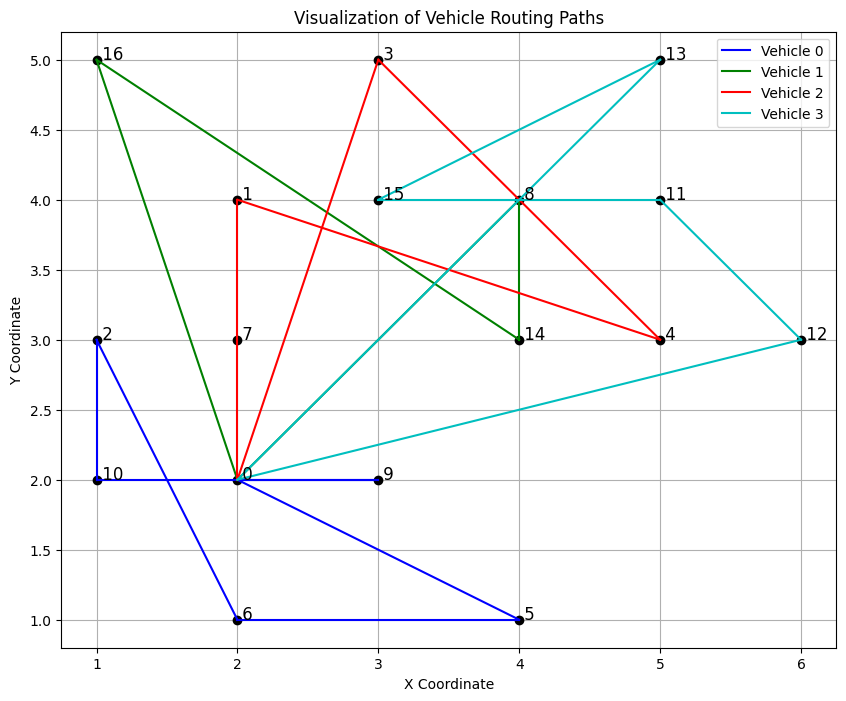

In [6]:
import matplotlib.pyplot as plt

# Define the coordinates for each location based on your setup
# These should be determined by the actual layout of your locations
coordinates = [
    (2, 2),   # Node 0
    (2, 4),   # Node 1
    (1, 3),   # Node 2
    (3, 5),   # Node 3
    (5, 3),   # Node 4
    (4, 1),   # Node 5
    (2, 1),   # Node 6
    (2, 3),   # Node 7
    (4, 4),   # Node 8
    (3, 2),   # Node 9
    (1, 2),   # Node 10
    (5, 4),   # Node 11
    (6, 3),   # Node 12
    (5, 5),   # Node 13
    (4, 3),   # Node 14
    (3, 4),   # Node 15
    (1, 5),   # Node 16
]

# Define the routes as given in your result
routes = [
    [0, 9, 10, 2, 6, 5, 0],
    [0, 16, 14, 8, 0],
    [0, 7, 1, 4, 3, 0],
    [0, 13, 15, 11, 12, 0]
]

colors = ['b', 'g', 'r', 'c']
labels = ['Vehicle 0', 'Vehicle 1', 'Vehicle 2', 'Vehicle 3']

def plot_routes(routes, coordinates):
    plt.figure(figsize=(10, 8))

    # Plotting each location node
    for i, (x, y) in enumerate(coordinates):
        plt.plot(x, y, 'ko')  # 'ko' for black circle
        plt.text(x, y, f' {i}', color='black', fontsize=12)

    # Plotting the routes
    for idx, route in enumerate(routes):
        for i in range(len(route) - 1):
            start_node = route[i]
            end_node = route[i + 1]
            plt.plot([coordinates[start_node][0], coordinates[end_node][0]],
                     [coordinates[start_node][1], coordinates[end_node][1]],
                     colors[idx] + '-', label=labels[idx] if i == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Visualization of Vehicle Routing Paths')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_routes(routes, coordinates)


### Add constraints 

Objective: 5174
Route for vehicle 0:
 0 ->  2 ->  32 ->  47 ->  77 ->  78 ->  79 ->  109 ->  108 ->  107 ->  106 ->  121 ->  122 ->  123 ->  124 ->  125 ->  126 ->  111 ->  112 ->  127 ->  128 ->  113 ->  110 ->  80 ->  33 ->  34 ->  35 ->  20 ->  21 ->  22 ->  23 ->  24 ->  25 ->  26 ->  27 ->  28 ->  29 ->  14 ->  13 ->  12 ->  11 ->  10 ->  9 ->  8 ->  7 ->  6 ->  5 ->  4 ->  19 ->  18 ->  3 -> 0
Distance of the route: 64m

Route for vehicle 1:
 0 ->  1 ->  16 ->  31 ->  46 ->  61 ->  62 ->  63 ->  64 ->  65 ->  66 ->  81 ->  82 ->  83 ->  84 ->  85 ->  86 ->  87 ->  88 ->  89 ->  74 ->  73 ->  72 ->  71 ->  70 ->  69 ->  68 ->  67 ->  52 ->  53 ->  54 ->  55 ->  56 ->  57 ->  58 ->  59 ->  44 ->  43 ->  42 ->  41 ->  40 ->  39 ->  38 ->  37 ->  36 ->  51 ->  50 ->  49 ->  48 ->  17 -> 0
Distance of the route: 54m

Route for vehicle 2:
 0 ->  15 ->  30 ->  45 ->  60 ->  75 ->  90 ->  105 ->  120 ->  135 ->  136 ->  137 ->  138 ->  139 ->  140 ->  141 ->  142 ->  143 ->  144 ->  145 

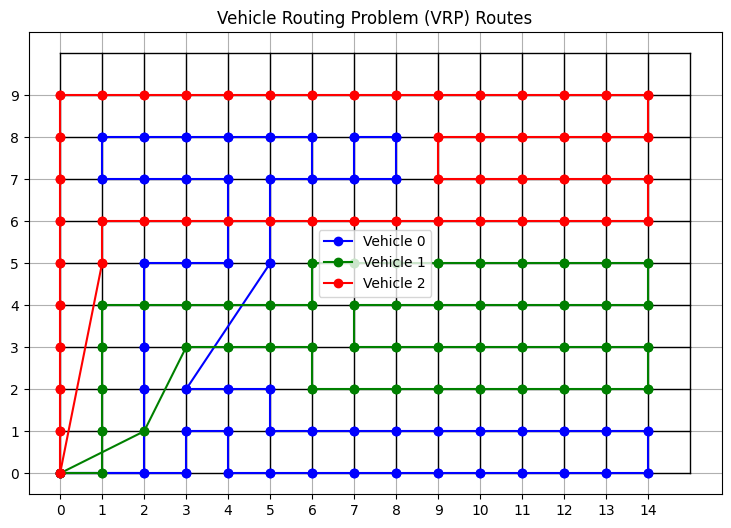

In [8]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    grid_width = 15
    grid_height = 10
    data['distance_matrix'] = create_distance_matrix(grid_width, grid_height)
    data['num_vehicles'] = 3
    data['depot'] = 0
    data['vehicle_capacities'] = [60, 50, 100 ] # Example battery capacity
    return data

def create_distance_matrix(width, height):
    # Create a distance matrix for the 10x15 grid
    num_locations = width * height
    distance_matrix = [[0] * num_locations for _ in range(num_locations)]
    for from_node in range(num_locations):
        for to_node in range(num_locations):
            from_x, from_y = from_node % width, from_node // width
            to_x, to_y = to_node % width, to_node // width
            distance_matrix[from_node][to_node] = abs(from_x - to_x) + abs(from_y - to_y)
    return distance_matrix

def add_capacity_constraints(routing, data, manager):
    """Add Capacity constraint."""
    def demand_callback(from_index):
        """Returns the demand of each node, here assumed to be the distance itself as 'cost'."""
        from_node = manager.IndexToNode(from_index)
        return 1  # Assume each point has a demand of 1, could be modified based on actual scenario

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Battery')

def add_balance_dimension(routing, manager, data):
    """Add Global Span cost to balance the workload evenly."""
    # Create callback to count the number of locations visited by each vehicle
    def count_callback(from_index):
        """Count each location as a visit."""
        from_node = manager.IndexToNode(from_index)
        return 1 if from_node != data['depot'] else 0

    count_callback_index = routing.RegisterUnaryTransitCallback(count_callback)

    # Add dimension to minimize the maximum route among all vehicles to balance the workload
    routing.AddDimension(
        count_callback_index,
        0,  # no slack
        70,  # maximum count of locations visited
        True,  # start cumul to zero
        'Load')

    load_dimension = routing.GetDimensionOrDie('Load')
    load_dimension.SetGlobalSpanCostCoefficient(100)

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    routes = []  # Initialize an empty list to hold all routes
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route = []  # List to store the current vehicle's route
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)  # Append current node to the route list
            plan_output += f" {node} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        route.append(manager.IndexToNode(index))  # Append the end node
        routes.append(route)  # Append the completed route to routes list
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")
    return routes  

def plot_routes(routes, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(10, 6))  # Set up the figure and axes
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for the vehicles

    # Plotting the grid
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plotting the routes
    for vehicle_id, route in enumerate(routes):
        for i in range(len(route) - 1):
            start_node = route[i]
            end_node = route[i + 1]
            start_x, start_y = start_node % grid_width, start_node // grid_width
            end_x, end_y = end_node % grid_width, end_node // grid_width
            ax.plot([start_x, end_x], [start_y, end_y], colors[vehicle_id % len(colors)]+'o-', label=f"Vehicle {vehicle_id}" if i == 0 else "")

    # Setting plot parameters
    ax.set_aspect('equal', adjustable='box')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title('Vehicle Routing Problem (VRP) Routes')
    plt.show()

def main():
    """Solve the VRP with capacity and balance constraints."""
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    # Distance callback
    distance_callback_index = routing.RegisterTransitCallback(lambda from_index, to_index: data['distance_matrix'][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)])
    routing.SetArcCostEvaluatorOfAllVehicles(distance_callback_index)

    # Add Capacity and Balance constraints
    add_capacity_constraints(routing, data, manager)
    add_balance_dimension(routing, manager, data)

    # Search Parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.FromSeconds(30)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        routes = print_solution(data, manager, routing, solution)
        plot_routes(routes, 15, 10)
    else:
        print('No solution found !')

if __name__ == '__main__':
    main()


### tvp sOLVER GOOGLE

Objective: 1840
Route for vehicle 0:
 0 ->  12 ->  18 ->  24 ->  30 ->  31 ->  32 ->  33 ->  34 ->  35 ->  29 ->  28 ->  27 ->  26 ->  25 ->  19 ->  20 ->  14 ->  13 -> 0
Distance of the route: 22m

Route for vehicle 1:
 0 ->  6 ->  7 ->  8 ->  9 ->  15 ->  21 ->  22 ->  23 ->  17 ->  16 ->  10 ->  11 ->  5 ->  4 ->  3 ->  2 ->  1 -> 0
Distance of the route: 18m

Maximum of the route distances: 22m


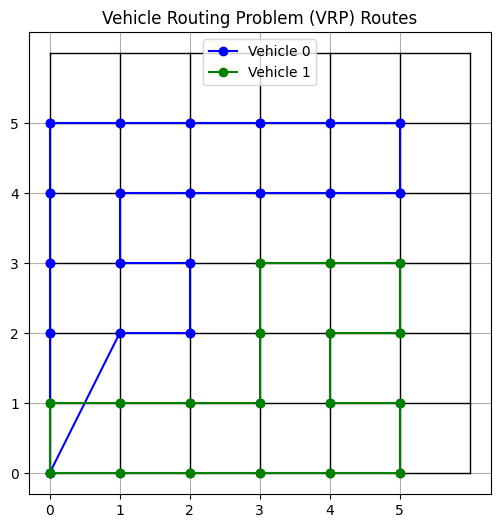

In [42]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    grid_width = 6
    grid_height = 6
    data['distance_matrix'] = create_distance_matrix(grid_width, grid_height)
    data['num_vehicles'] = 2
    data['depot'] = 0
    data['vehicle_capacities'] = [60, 50 ] # Example battery capacity
    return data

def create_distance_matrix(width, height):
    # Create a distance matrix for the 10x15 grid
    num_locations = width * height
    distance_matrix = [[0] * num_locations for _ in range(num_locations)]
    for from_node in range(num_locations):
        for to_node in range(num_locations):
            from_x, from_y = from_node % width, from_node // width
            to_x, to_y = to_node % width, to_node // width
            distance_matrix[from_node][to_node] = abs(from_x - to_x) + abs(from_y - to_y)
    return distance_matrix

def add_capacity_constraints(routing, data, manager):
    """Add Capacity constraint."""
    def demand_callback(from_index):
        """Returns the demand of each node, here assumed to be the distance itself as 'cost'."""
        from_node = manager.IndexToNode(from_index)
        return 1  # Assume each point has a demand of 1, could be modified based on actual scenario

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Battery')

def add_balance_dimension(routing, manager, data):
    """Add Global Span cost to balance the workload evenly."""
    # Create callback to count the number of locations visited by each vehicle
    def count_callback(from_index):
        """Count each location as a visit."""
        from_node = manager.IndexToNode(from_index)
        return 1 if from_node != data['depot'] else 0

    count_callback_index = routing.RegisterUnaryTransitCallback(count_callback)

    # Add dimension to minimize the maximum route among all vehicles to balance the workload
    routing.AddDimension(
        count_callback_index,
        0,  # no slack
        70,  # maximum count of locations visited
        True,  # start cumul to zero
        'Load')

    load_dimension = routing.GetDimensionOrDie('Load')
    load_dimension.SetGlobalSpanCostCoefficient(100)

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    routes = []  # Initialize an empty list to hold all routes
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route = []  # List to store the current vehicle's route
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)  # Append current node to the route list
            plan_output += f" {node} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        route.append(manager.IndexToNode(index))  # Append the end node
        routes.append(route)  # Append the completed route to routes list
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")
    return routes  

def plot_routes(routes, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(10, 6))  # Set up the figure and axes
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for the vehicles

    # Plotting the grid
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plotting the routes
    for vehicle_id, route in enumerate(routes):
        for i in range(len(route) - 1):
            start_node = route[i]
            end_node = route[i + 1]
            start_x, start_y = start_node % grid_width, start_node // grid_width
            end_x, end_y = end_node % grid_width, end_node // grid_width
            ax.plot([start_x, end_x], [start_y, end_y], colors[vehicle_id % len(colors)]+'o-', label=f"Vehicle {vehicle_id}" if i == 0 else "")

    # Setting plot parameters
    ax.set_aspect('equal', adjustable='box')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title('Vehicle Routing Problem (VRP) Routes')
    plt.show()

def main():
    """Solve the VRP with capacity and balance constraints."""
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    # Distance callback
    distance_callback_index = routing.RegisterTransitCallback(lambda from_index, to_index: data['distance_matrix'][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)])
    routing.SetArcCostEvaluatorOfAllVehicles(distance_callback_index)

    # Add Capacity and Balance constraints
    add_capacity_constraints(routing, data, manager)
    add_balance_dimension(routing, manager, data)

    # Search Parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.FromSeconds(30)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        routes = print_solution(data, manager, routing, solution)
        plot_routes(routes, 6, 6)
    else:
        print('No solution found !')

if __name__ == '__main__':
    main()


### No algo

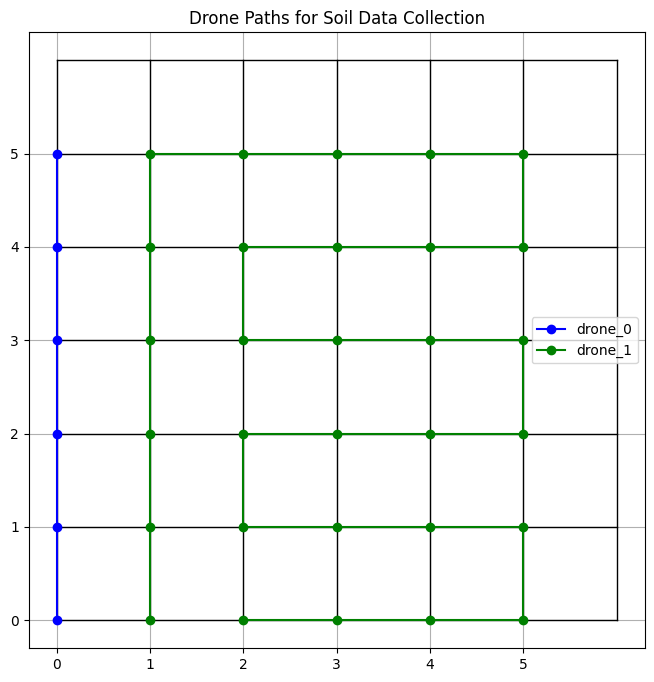

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([(1, 0)])}
visited.add(start_position)
visited.add((1, 0))
drone_paths = {"drone_0": [start_position], "drone_1": [(1, 0)]}

# Movement directions: up, right, down, left
directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def get_next_position(current_position, visited, drone_name):
    """Determine the next position based on the order up, right, down, left."""
    x, y = current_position
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    return None  # No unvisited adjacent cell

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)

simulate_drones()

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


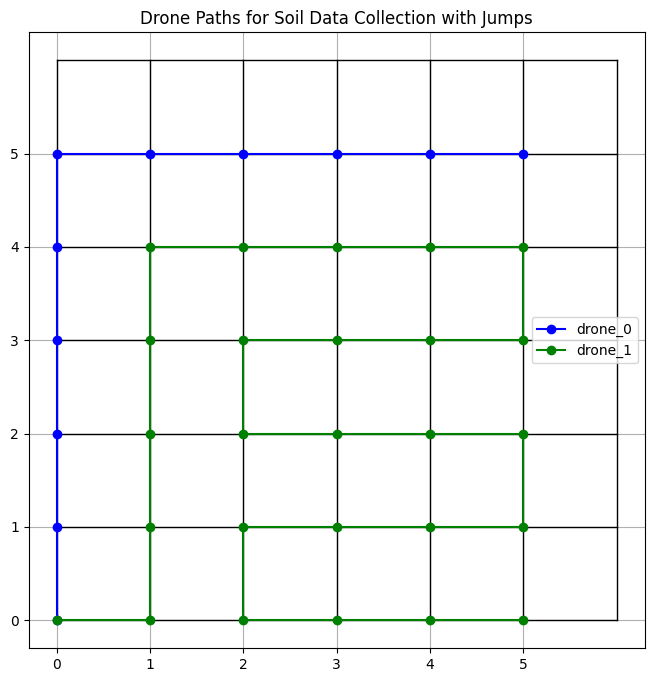

In [ ]:
import matplotlib.pyplot as plt
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}

# Movement directions: up, right, down, left
directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def get_next_position(current_position, visited, drone_name):
    """Determine the next position based on the order up, right, down, left. If all immediate neighbors are blocked, jump by 2 cells."""
    
    x, y = current_position
    for dx, dy in directions:
        # Check adjacent cell
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
        
    # If no immediate neighbors are available, try jumping by 2 cells
    for dx, dy in directions:
        nx, ny = x + 2 * dx, y + 2 * dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    
    return None  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)

simulate_drones()

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection with Jumps")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


### NN with distance

Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35 -> 0

Distance of the route: 10m

Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 21 -> 15 -> 14 -> 20 -> 26 -> 32 -> 31 -> 25 -> 19 -> 13 -> 12 -> 18 -> 24 -> 30 -> 0

Distance of the route: 25m

Maximum of the route distances: 25m



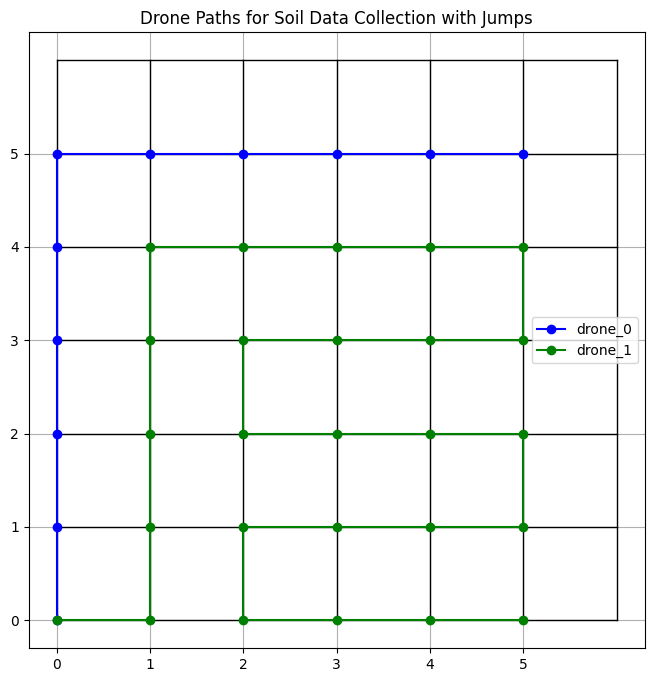

In [3]:
import matplotlib.pyplot as plt
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left
directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def get_next_position(current_position, visited, drone_name):
    """Determine the next position based on the order up, right, down, left. If all immediate neighbors are blocked, jump by 2 cells."""
    x, y = current_position
    for dx, dy in directions:
        # Check adjacent cell
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
        
    # If no immediate neighbors are available, try jumping by 2 cells
    for dx, dy in directions:
        nx, ny = x + 2 * dx, y + 2 * dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    
    return None  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += 1  # Count each move as 1 meter

simulate_drones()

def print_drone_routes_and_distances(drone_paths, drone_distances):
    """Prints each drone's route and the distance covered."""
    max_distance = 0
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x * grid_width + y}" for x, y in path])  # Convert (x, y) to cell index
        route_str += f" -> {path[0][0] * grid_width + path[0][1]}\n"  # Return to start
        distance_str = f"Distance of the route: {drone_distances[drone_name]}m\n"
        print(route_str)
        print(distance_str)
        max_distance = max(max_distance, drone_distances[drone_name])
    print(f"Maximum of the route distances: {max_distance}m\n")

# Print each drone's route and distance
print_drone_routes_and_distances(drone_paths, drone_distances)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection with Jumps")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


### THe best so far with no battery capacity

Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35 -> 21 -> 15 -> 14 -> 13 -> 12 -> 18 -> 24 -> 30 -> 0

Distance of the route: 18m

Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 26 -> 20 -> 19 -> 25 -> 31 -> 32 -> 0

Distance of the route: 17m

Maximum of the route distances: 18m



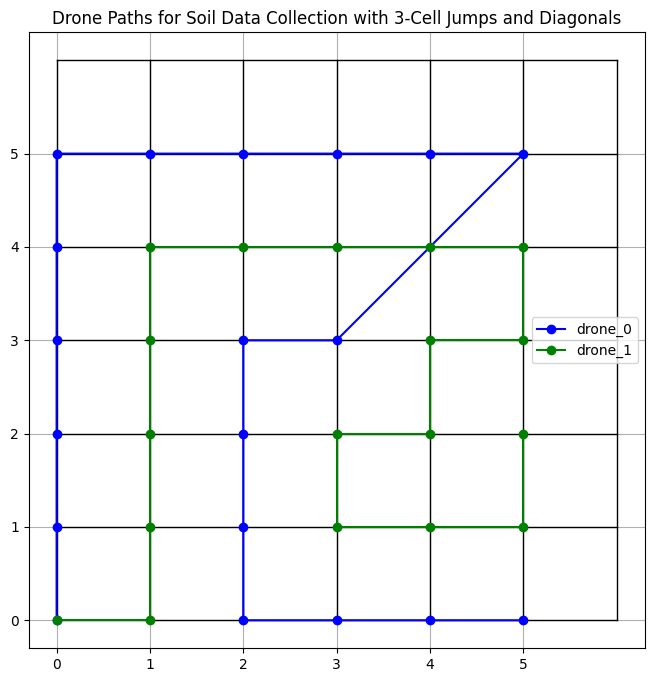

In [39]:
import matplotlib.pyplot as plt
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Adjacent directions
    (1, 1), (1, -1), (-1, -1),(-1, 1)   # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def get_next_position(current_position, visited, drone_name):
    """Determine the next position based on the order up, right, down, left.
    If all nearby cells are blocked, attempt to jump by 2 or 3 cells, including diagonals."""
    x, y = current_position
    
    # Check all adjacent cells
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    
    # If no adjacent cells are available, try jumping by 2 cells in each direction
    for dx, dy in directions:
        nx, ny = x + 2 * dx, y + 2 * dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    
    # If no 2-cell jumps are available, try jumping by 3 cells in each direction
    for dx, dy in directions:
        nx, ny = x + 3 * dx, y + 3 * dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    
    return None  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += 1  # Count each move as 1 meter

simulate_drones()

def print_drone_routes_and_distances(drone_paths, drone_distances):
    """Prints each drone's route and the distance covered."""
    max_distance = 0
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x * grid_width + y}" for x, y in path])  # Convert (x, y) to cell index
        route_str += f" -> {path[0][0] * grid_width + path[0][1]}\n"  # Return to start
        distance_str = f"Distance of the route: {drone_distances[drone_name]}m\n"
        print(route_str)
        print(distance_str)
        max_distance = max(max_distance, drone_distances[drone_name])
    print(f"Maximum of the route distances: {max_distance}m\n")

# Print each drone's route and distance
print_drone_routes_and_distances(drone_paths, drone_distances)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection with 3-Cell Jumps and Diagonals")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


### FINAL FINAL return home

Route for drone_0:
0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 3,3 -> 2,3 -> 2,2 -> 2,1 -> 2,0 -> 3,0 -> 4,0 -> 5,0 -> 0,0
Distance of the route: 37 meters including return to start.
Route for drone_1:
0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 2,4 -> 3,4 -> 4,4 -> 5,4 -> 5,3 -> 4,3 -> 4,2 -> 3,2 -> 3,1 -> 4,1 -> 5,1 -> 5,2 -> 0,0
Distance of the route: 35 meters including return to start.


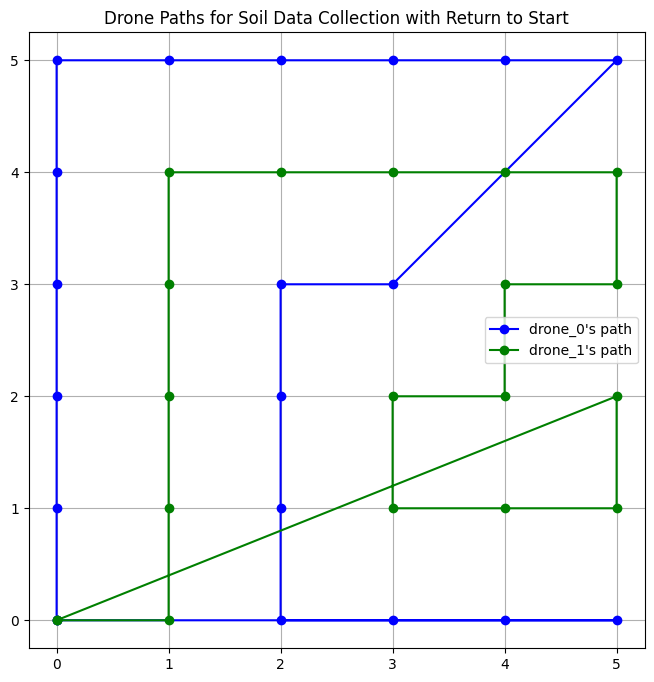

In [40]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from itertools import product

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def get_next_position(current_position, visited, drone_name):
    """Determine the next position based on the order up, right, down, left.
    If all nearby cells are blocked, attempt to jump by 2 or 3 cells, including diagonals."""
    x, y = current_position
    
    # Try adjacent cells first
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)
    
    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                visited.add((nx, ny))
                drone_paths[drone_name].append((nx, ny))
                return (nx, ny)
    
    return None  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones and return them to the starting point."""
    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += 1  # Count each move as 1 meter
    # Return drones to start position after exploration
    for drone_name, path in drone_paths.items():
        if path[-1] != start_position:
            path.append(start_position)
            drone_distances[drone_name] += len(path) - 1  # Roughly estimate the return path distance

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x},{y}" for x, y in path])
        distance_str = f"Distance of the route: {drone_distances[drone_name]} meters including return to start."
        print(route_str)
        print(distance_str)

simulate_drones()
print_drone_routes_and_distances()

def plot_drone_routes():
    """Plotting the routes for each drone."""
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}
    
    # Draw grid lines
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name] + 'o-', label=f"{drone_name}'s path")

    ax.set_aspect('equal')
    ax.legend()
    plt.title("Drone Paths for Soil Data Collection with Return to Start")
    plt.show()

plot_drone_routes()


### Add battery

Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35
Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 21 -> 15 -> 14 -> 20 -> 26 -> 32 -> 31 -> 25 -> 19 -> 13 -> 12 -> 18 -> 24 -> 30


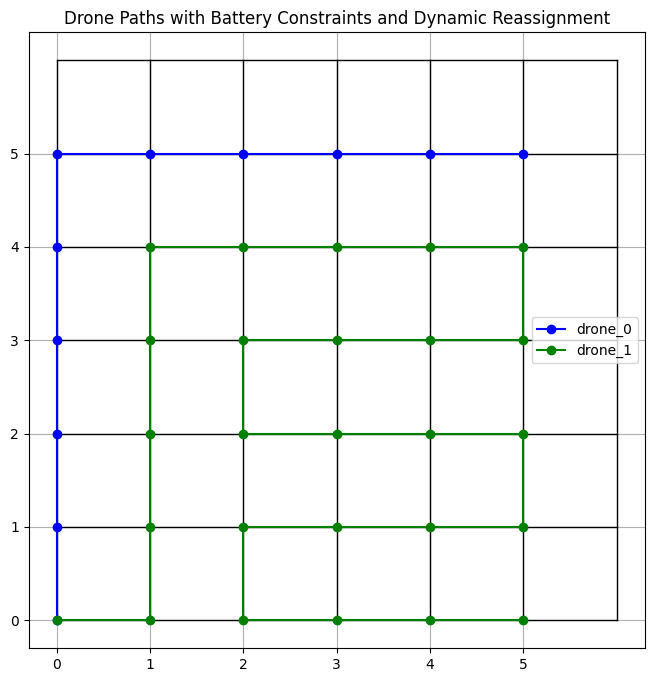

In [ ]:
import matplotlib.pyplot as plt
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
battery_capacity = 10  # Max cells a drone can visit before needing to recharge

# Drone setup
drones = {
    "drone_0": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity},
    "drone_1": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity}
}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Adjacent directions
    (-1, 1), (1, 1), (1, -1), (-1, -1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def distance_to_origin(position):
    """Calculate Manhattan distance to the origin (0, 0)."""
    x, y = position
    return abs(x) + abs(y)

def get_next_position(drone_name):
    """Determine the next position based on the available cells and battery."""
    drone = drones[drone_name]
    x, y = drone["position"]

    # Check all adjacent cells
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            # Check if battery level is enough to reach the origin from this cell
            if drone["battery"] - 1 >= distance_to_origin((nx, ny)):
                visited.add((nx, ny))
                drone_paths[drone_name].append((nx, ny))
                drone["battery"] -= 1
                return (nx, ny)
    
    # If no valid cell found, return None
    return None

def return_to_origin(drone_name):
    """Simulate the drone returning to origin for recharging."""
    drone = drones[drone_name]
    origin = start_position
    distance_to_reach = distance_to_origin(drone["position"])
    
    # Add steps back to origin for visualization
    while drone["position"] != origin:
        x, y = drone["position"]
        if x > 0:
            x -= 1
        elif x < 0:
            x += 1
        elif y > 0:
            y -= 1
        elif y < 0:
            y += 1
        drone_paths[drone_name].append((x, y))
        drone["position"] = (x, y)
        drone["battery"] -= 1  # Decrease battery as it moves back

    # Recharge the battery once at origin
    drone["battery"] = battery_capacity
    drone["path"].append(origin)

def simulate_drones():
    """Simulate the movement of both drones."""
    while any(drone["path"] for drone in drones.values()):
        for drone_name, drone in drones.items():
            if drone["battery"] <= distance_to_origin(drone["position"]):
                # If battery is low, return to origin for recharging
                return_to_origin(drone_name)
            else:
                # Get next position and update the path if possible
                next_position = get_next_position(drone_name)
                if next_position:
                    drone["position"] = next_position
                else:
                    # Reassign remaining tasks of this drone to the other if it has unvisited cells
                    for other_drone in drones:
                        if other_drone != drone_name:
                            other_drone_positions = drones[other_drone]["path"]
                            for pos in drone["path"]:
                                if pos not in visited and pos not in other_drone_positions:
                                    drones[other_drone]["path"].append(pos)
                    drone["path"].clear()  # Clear path as it's done for this drone

simulate_drones()

def print_drone_routes_and_distances(drone_paths):
    """Print each drone's route."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x * grid_width + y}" for x, y in path])
        print(route_str)

# Print each drone's route
print_drone_routes_and_distances(drone_paths)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths with Battery Constraints and Dynamic Reassignment")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35
Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 21 -> 15 -> 14 -> 20 -> 26 -> 32 -> 31 -> 25 -> 19 -> 13 -> 12 -> 18 -> 24 -> 30 -> 24 -> 18 -> 12 -> 6 -> 0


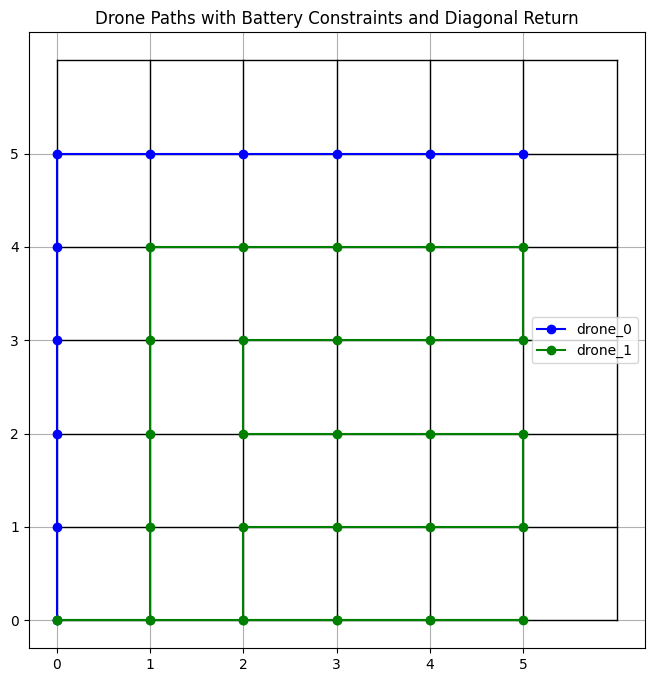

In [13]:
import matplotlib.pyplot as plt
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
battery_capacity = 30  # Max cells a drone can visit before needing to recharge

# Drone setup
drones = {
    "drone_0": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity},
    "drone_1": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity}
}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Adjacent directions
    (-1, 1), (1, 1), (1, -1), (-1, -1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def distance_to_origin(position):
    """Calculate Manhattan distance to the origin (0, 0)."""
    x, y = position
    return abs(x) + abs(y)

def get_next_position(drone_name):
    """Determine the next position based on the available cells and battery."""
    drone = drones[drone_name]
    x, y = drone["position"]

    # Check all adjacent cells
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            # Check if battery level is enough to reach the origin from this cell
            if drone["battery"] - 1 >= distance_to_origin((nx, ny)):
                visited.add((nx, ny))
                drone_paths[drone_name].append((nx, ny))
                drone["battery"] -= 1
                return (nx, ny)
    
    # If no valid cell found, return None
    return None

def return_to_origin(drone_name):
    """Simulate the drone returning to origin with diagonal movement for efficiency."""
    drone = drones[drone_name]
    origin = start_position
    
    # Move back to origin, using diagonal steps when possible
    while drone["position"] != origin:
        x, y = drone["position"]
        ox, oy = origin
        
        # Determine the next step towards the origin
        if x > ox and y > oy:       # Move diagonally up-left
            x, y = x - 1, y - 1
        elif x > ox and y < oy:     # Move diagonally up-right
            x, y = x - 1, y + 1
        elif x < ox and y > oy:     # Move diagonally down-left
            x, y = x + 1, y - 1
        elif x < ox and y < oy:     # Move diagonally down-right
            x, y = x + 1, y + 1
        elif x > ox:                # Move directly up
            x -= 1
        elif x < ox:                # Move directly down
            x += 1
        elif y > oy:                # Move directly left
            y -= 1
        elif y < oy:                # Move directly right
            y += 1
        
        # Update path and battery
        drone_paths[drone_name].append((x, y))
        drone["position"] = (x, y)
        drone["battery"] -= 1

    # Recharge the battery once at origin
    drone["battery"] = battery_capacity
    drone["path"].append(origin)

def simulate_drones():
    """Simulate the movement of both drones."""
    while any(drone["path"] for drone in drones.values()):
        for drone_name, drone in drones.items():
            if drone["battery"] <= distance_to_origin(drone["position"]):
                # If battery is low, return to origin for recharging
                return_to_origin(drone_name)
            else:
                # Get next position and update the path if possible
                next_position = get_next_position(drone_name)
                if next_position:
                    drone["position"] = next_position
                else:
                    # Reassign remaining tasks of this drone to the other if it has unvisited cells
                    for other_drone in drones:
                        if other_drone != drone_name:
                            other_drone_positions = drones[other_drone]["path"]
                            for pos in drone["path"]:
                                if pos not in visited and pos not in other_drone_positions:
                                    drones[other_drone]["path"].append(pos)
                    drone["path"].clear()  # Clear path as it's done for this drone

simulate_drones()

def print_drone_routes_and_distances(drone_paths):
    """Print each drone's route."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x * grid_width + y}" for x, y in path])
        print(route_str)

# Print each drone's route
print_drone_routes_and_distances(drone_paths)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths with Battery Constraints and Diagonal Return")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35
Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 21 -> 15 -> 14 -> 20 -> 26 -> 32 -> 31 -> 25 -> 19 -> 13 -> 12 -> 18 -> 24 -> 30
Total distance covered by drone_0: 0.00m
Total distance covered by drone_1: 0.00m


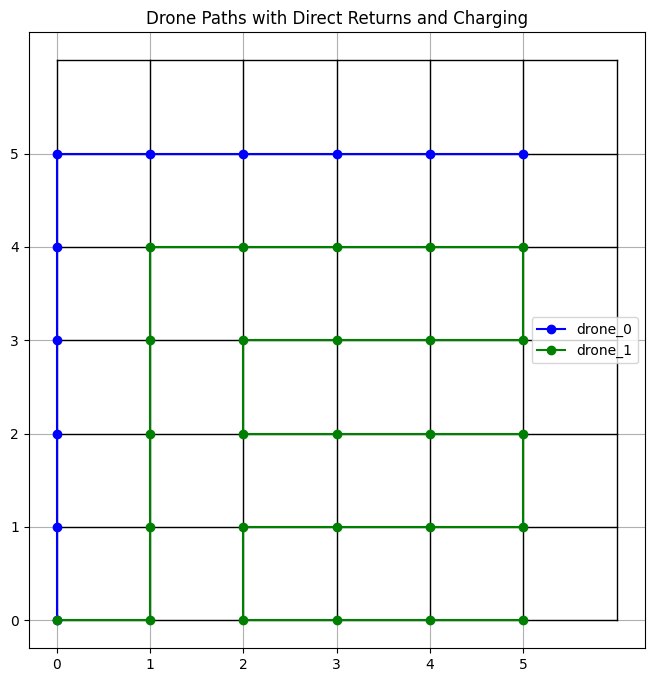

In [37]:
import matplotlib.pyplot as plt
from collections import deque
import math

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
battery_capacity = 50  # Max cells a drone can visit before needing to recharge
charging_steps = 3  # Time steps needed to recharge

# Drone setup
drones = {
    "drone_0": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity, "charging": 0},
    "drone_1": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity, "charging": 0}
}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Adjacent directions
    (-1, 1), (1, 1), (1, -1), (-1, -1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def distance_to_origin(position):
    """Calculate Euclidean distance to the origin (0, 0)."""
    x, y = position
    return math.sqrt(x**2 + y**2)

def get_next_position(drone_name):
    """Determine the next position based on the available cells and battery."""
    drone = drones[drone_name]
    x, y = drone["position"]

    # Check all adjacent cells
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            # Check if battery level is enough to reach the origin from this cell
            if drone["battery"] - 1 >= distance_to_origin((nx, ny)):
                visited.add((nx, ny))
                drone_paths[drone_name].append((nx, ny))
                drone["battery"] -= 1
                return (nx, ny)
    
    # If no valid cell found, return None
    return None

def return_to_origin(drone_name):
    """Simulate the drone returning to origin directly and recharging."""
    drone = drones[drone_name]
    origin = start_position
    dist = distance_to_origin(drone["position"])
    
    # Move back to origin directly and recharge
    drone["position"] = origin
    drone_paths[drone_name].append(origin)
    drone_distances[drone_name] += dist  # Add direct distance
    drone["charging"] = charging_steps  # Start charging

def simulate_drones():
    """Simulate the movement of both drones."""
    while any(drone["path"] for drone in drones.values()):
        for drone_name, drone in drones.items():
            if drone["charging"] > 0:
                # Reduce charging time and continue if still charging
                drone["charging"] -= 1
                continue

            if drone["battery"] <= distance_to_origin(drone["position"]):
                # If battery is low, return to origin for recharging
                return_to_origin(drone_name)
            else:
                # Get next position and update the path if possible
                next_position = get_next_position(drone_name)
                if next_position:
                    drone["position"] = next_position
                else:
                    # Clear path as it's done for this drone
                    drone["path"].clear()

simulate_drones()

def print_drone_routes_and_distances(drone_paths, drone_distances):
    """Print each drone's route and total distance."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x * grid_width + y}" for x, y in path])
        print(route_str)
    for drone_name, distance in drone_distances.items():
        print(f"Total distance covered by {drone_name}: {distance:.2f}m")

# Print each drone's route and total distance
print_drone_routes_and_distances(drone_paths, drone_distances)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths with Direct Returns and Charging")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


In [16]:
import matplotlib.pyplot as plt
from collections import deque
import math

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
battery_capacity = 20  # Max cells a drone can visit before needing to recharge
charging_steps = 3  # Time steps needed to recharge

# Drone setup
drones = {
    "drone_0": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity, "charging": 0},
    "drone_1": {"position": start_position, "path": deque([start_position]), "battery": battery_capacity, "charging": 0}
}
visited.add(start_position)
drone_paths = {"drone_0": [], "drone_1": []}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Adjacent directions
    (-1, 1), (1, 1), (1, -1), (-1, -1)  # Diagonal directions
]

def is_within_bounds(x, y):
    return 0 <= x < grid_width and 0 <= y < grid_height

def distance_between_points(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def move_drone(drone_name):
    drone = drones[drone_name]
    x, y = drone["position"]
    
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            next_position = (nx, ny)
            if drone["battery"] - 1 >= distance_between_points(start_position, next_position):
                visited.add(next_position)
                drone_paths[drone_name].append(next_position)
                drone["distance"] += distance_between_points((x, y), next_position)
                drone["position"] = next_position
                drone["battery"] -= 1
                return True
    return False

def simulate_drones():
    while any(drone["battery"] > 0 for drone in drones.values()):
        for drone_name in drones:
            drone = drones[drone_name]
            if not move_drone(drone_name) or drone["battery"] < distance_between_points(drone["position"], start_position):
                # Drone returns to origin
                drone["distance"] += distance_between_points(drone["position"], start_position)
                drone_paths[drone_name].append(start_position)
                drone["position"] = start_position
                drone["battery"] = battery_capacity  # Assume instant recharge for simplicity

simulate_drones()

def print_drone_routes_and_distances():
    for drone_name, path in drone_paths.items():
        print(f"Route for {drone_name}:")
        path_str = " -> ".join(f"{x * grid_width + y}" for x, y in path)
        print(path_str)
        print(f"Total distance covered by {drone_name}: {drones[drone_name]['distance']:.2f}m")

print_drone_routes_and_distances()

# Plotting function remains the same


KeyError: 'distance'

Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35 -> 0
Total distance covered by drone_0: 17.07m
Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 21 -> 15 -> 14 -> 20 -> 26 -> 32 -> 31 -> 25 -> 0
Total distance covered by drone_1: 23.12m


ValueError: 'blueo-' is not a valid format string (unrecognized character 'l')

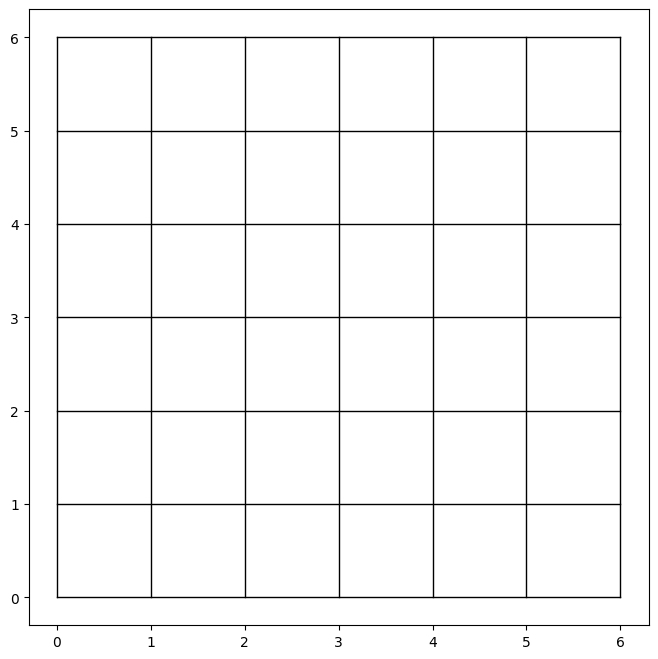

In [17]:
import matplotlib.pyplot as plt
import math
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
battery_capacity = 20  # Max cells a drone can visit before needing to recharge
charging_steps = 3  # Time steps needed to recharge

# Drone setup
drones = {
    "drone_0": {"position": start_position, "path": [start_position], "battery": battery_capacity, "distance": 0, "charging": 0},
    "drone_1": {"position": start_position, "path": [start_position], "battery": battery_capacity, "distance": 0, "charging": 0}
}
visited.add(start_position)

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Cardinal directions
    (-1, 1), (1, 1), (1, -1), (-1, -1)  # Diagonal directions
]

def is_within_bounds(x, y):
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def move_drone(drone_name):
    drone = drones[drone_name]
    x, y = drone["position"]

    if drone["charging"] > 0:  # Check if drone is currently charging
        drone["charging"] -= 1
        return False

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            if drone["battery"] > 1:  # Ensure there's enough battery to consider returning
                visited.add((nx, ny))
                drone["path"].append((nx, ny))
                move_distance = euclidean_distance((x, y), (nx, ny))
                drone["distance"] += move_distance
                drone["position"] = (nx, ny)
                drone["battery"] -= 1
                return True
    return False

def return_to_origin(drone_name):
    drone = drones[drone_name]
    if drone["position"] != start_position:
        move_distance = euclidean_distance(drone["position"], start_position)
        drone["distance"] += move_distance
        drone["path"].append(start_position)
        drone["position"] = start_position
        drone["battery"] = battery_capacity
        drone["charging"] = charging_steps

def simulate_drones():
    active = True
    while active:
        active = False
        for drone_name in drones:
            if drones[drone_name]["battery"] > 0 and drones[drone_name]["charging"] == 0:
                if not move_drone(drone_name):
                    return_to_origin(drone_name)
                active = True

simulate_drones()

def print_drone_routes_and_distances():
    for drone_name, drone_info in drones.items():
        print(f"Route for {drone_name}:")
        route_str = " -> ".join(f"{pos[0] * grid_width + pos[1]}" for pos in drone_info["path"])
        print(route_str)
        print(f"Total distance covered by {drone_name}: {drone_info['distance']:.2f}m")

print_drone_routes_and_distances()

def plot_drone_routes():
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'blue', 'drone_1': 'green'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's path
    for drone_name, drone_info in drones.items():
        x_points, y_points = zip(*drone_info["path"])
        ax.plot(x_points, y_points, colors[drone_name] + 'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.legend()
    plt.title("Drone Paths with Direct Returns and Charging")
    plt.show()

plot_drone_routes()


### Final

Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35 -> 0
Total distance covered by drone_0: 17.07m
Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 27 -> 21 -> 15 -> 14 -> 20 -> 26 -> 32 -> 31 -> 25 -> 19 -> 13 -> 12 -> 18 -> 24 -> 30 -> 0
Total distance covered by drone_1: 30.00m


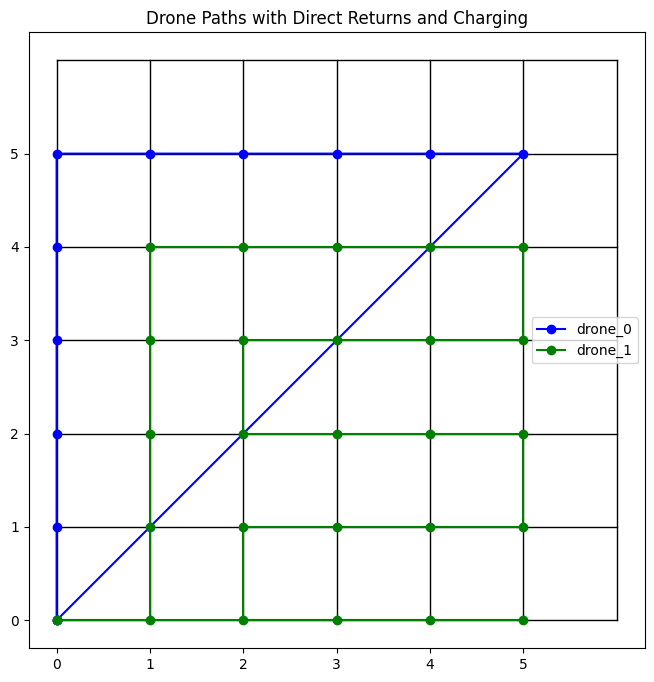

In [30]:
import matplotlib.pyplot as plt
import math
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
battery_capacity = 100  # Max distance a drone can travel before needing to recharge
charging_steps = 3  # Time steps needed to recharge

# Drone setup
drones = {
    "drone_0": {"position": start_position, "path": [start_position], "battery": battery_capacity, "distance": 0, "charging": 0},
    "drone_1": {"position": start_position, "path": [start_position], "battery": battery_capacity, "distance": 0, "charging": 0}
}
visited.add(start_position)

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),   # Cardinal directions
    (-1, 1), (1, 1), (1, -1), (-1, -1)  # Diagonal directions
]

def is_within_bounds(x, y):
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def can_move(drone, next_position):
    move_distance = euclidean_distance(drone["position"], next_position)
    return_to_base_distance = euclidean_distance(next_position, start_position)
    # Check if moving to the next position will allow enough battery to return to the base
    return drone["battery"] >= (move_distance + return_to_base_distance)

def move_drone(drone_name):
    drone = drones[drone_name]
    x, y = drone["position"]

    if drone["charging"] > 0:  # Check if drone is currently charging
        drone["charging"] -= 1
        return False

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        next_position = (nx, ny)
        if is_within_bounds(nx, ny) and next_position not in visited and can_move(drone, next_position):
            visited.add(next_position)
            drone["path"].append(next_position)
            move_distance = euclidean_distance((x, y), next_position)
            drone["distance"] += move_distance
            drone["position"] = next_position
            drone["battery"] -= move_distance
            return True
    return False

def return_to_origin(drone_name):
    drone = drones[drone_name]
    if drone["position"] != start_position:
        move_distance = euclidean_distance(drone["position"], start_position)
        drone["distance"] += move_distance
        drone["path"].append(start_position)
        drone["position"] = start_position
        drone["battery"] = battery_capacity
        drone["charging"] = charging_steps

def simulate_drones():
    active = True
    while active:
        active = False
        for drone_name in drones:
            drone = drones[drone_name]
            if drone["charging"] > 0:
                continue
            if not move_drone(drone_name):
                return_to_origin(drone_name)
            if drone["battery"] > 0:
                active = True

simulate_drones()

def print_drone_routes_and_distances():
    for drone_name, drone_info in drones.items():
        print(f"Route for {drone_name}:")
        route_str = " -> ".join(f"{pos[0] * grid_width + pos[1]}" for pos in drone_info["path"])
        print(route_str)
        print(f"Total distance covered by {drone_name}: {drone_info['distance']:.2f}m")

print_drone_routes_and_distances()

def plot_drone_routes():
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'blue', 'drone_1': 'green'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k-', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k-', lw=1)

    # Plot each drone's path
    for drone_name, drone_info in drones.items():
        x_points, y_points = zip(*drone_info["path"])
        ax.plot(x_points, y_points, 'o-', color=colors[drone_name], label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.legend()
    plt.title("Drone Paths with Direct Returns and Charging")
    plt.show()

plot_drone_routes()


### back from NN with distance

Route for drone_0:
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 11 -> 17 -> 23 -> 29 -> 35 -> 21 -> 15 -> 14 -> 13 -> 12 -> 18 -> 24 -> 24

Distance of the route: 18m

Route for drone_1:
0 -> 6 -> 7 -> 8 -> 9 -> 10 -> 16 -> 22 -> 28 -> 34 -> 33 -> 32 -> 26 -> 20 -> 19 -> 25 -> 31 -> 30 -> 30

Distance of the route: 17m

Maximum of the route distances: 18m



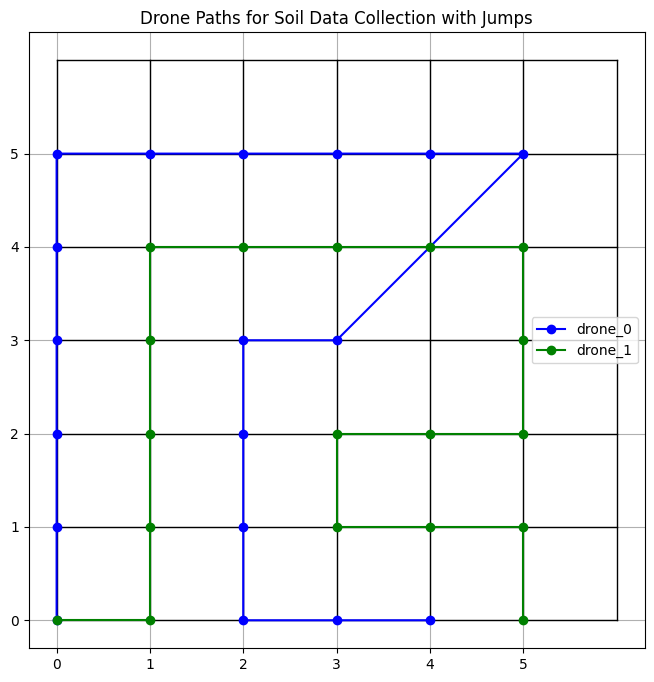

In [32]:
import matplotlib.pyplot as plt
from collections import deque

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left
directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def find_nearest_unvisited(current_position, visited):
    """Scan the grid to find the nearest unvisited cell."""
    min_distance = float('inf')
    nearest_position = None
    x0, y0 = current_position

    for x in range(grid_width):
        for y in range(grid_height):
            if (x, y) not in visited and is_within_bounds(x, y):
                distance = abs(x - x0) + abs(y - y0)  # Manhattan distance
                if distance < min_distance:
                    min_distance = distance
                    nearest_position = (x, y)

    if nearest_position:
        visited.add(nearest_position)
        return nearest_position
    return None

def get_next_position(current_position, visited, drone_name):
    """Determine the next position by first trying adjacent cells, then looking for the nearest unvisited cell."""
    x, y = current_position
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)

    # If no immediate neighbors are available, find the nearest unvisited cell
    return find_nearest_unvisited(current_position, visited)

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += 1  # Count each move as 1 meter

simulate_drones()

def print_drone_routes_and_distances(drone_paths, drone_distances):
    """Prints each drone's route and the distance covered."""
    max_distance = 0
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x * grid_width + y}" for x, y in path])  # Convert (x, y) to cell index
        route_str += f" -> {path[-1][0] * grid_width + path[-1][1]}\n"  # Return to last position
        distance_str = f"Distance of the route: {drone_distances[drone_name]}m\n"
        print(route_str)
        print(distance_str)
        max_distance = max(max_distance, drone_distances[drone_name])
    print(f"Maximum of the route distances: {max_distance}m\n")

# Print each drone's route and distance
print_drone_routes_and_distances(drone_paths, drone_distances)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection with Jumps")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


Route for drone_0:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (1, 5) -> (2, 5) -> (3, 5) -> (4, 5) -> (5, 5) -> (3, 3) -> (2, 3) -> (2, 2) -> (2, 1) -> (2, 0) -> (3, 0) -> (4, 0)
Distance of the route: 18m
Route for drone_1:
(0, 0) -> (1, 0) -> (1, 1) -> (1, 2) -> (1, 3) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (5, 3) -> (5, 2) -> (4, 2) -> (3, 2) -> (3, 1) -> (4, 1) -> (5, 1) -> (5, 0)
Distance of the route: 17m


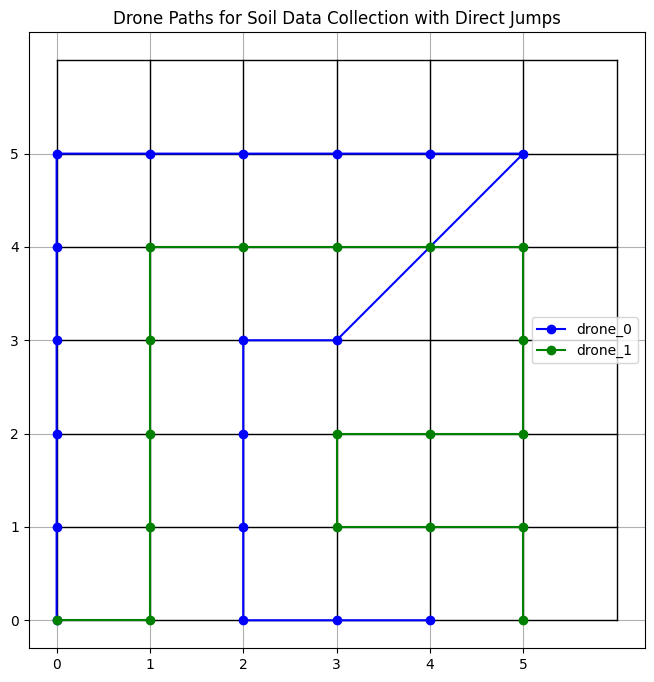

In [33]:
import matplotlib.pyplot as plt
from collections import deque
import math

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def find_nearest_unvisited(current_position, visited):
    """Scan the grid to find the nearest unvisited cell using Euclidean distance."""
    min_distance = float('inf')
    nearest_position = None
    x0, y0 = current_position

    for x in range(grid_width):
        for y in range(grid_height):
            if (x, y) not in visited and is_within_bounds(x, y):
                distance = math.sqrt((x - x0) ** 2 + (y - y0) ** 2)  # Euclidean distance
                if distance < min_distance:
                    min_distance = distance
                    nearest_position = (x, y)

    if nearest_position:
        visited.add(nearest_position)
        return nearest_position
    return None

def get_next_position(current_position, visited, drone_name):
    """Determine the next position by first trying adjacent cells, then looking for the nearest unvisited cell."""
    x, y = current_position
    # Movement directions include diagonals: up, right, down, left, and diagonals
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)

    # If no immediate neighbors are available, find the nearest unvisited cell
    return find_nearest_unvisited(current_position, visited)

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += 1  # Count each move as 1 meter

simulate_drones()

def print_drone_routes_and_distances(drone_paths, drone_distances):
    """Prints each drone's route and the distance covered."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"({x}, {y})" for x, y in path])
        distance_str = f"Distance of the route: {drone_distances[drone_name]}m"
        print(route_str)
        print(distance_str)

# Print each drone's route and distance
print_drone_routes_and_distances(drone_paths, drone_distances)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection with Direct Jumps")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


Route for drone_0:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (1, 5) -> (2, 5) -> (3, 5) -> (4, 5) -> (5, 5) -> (3, 3) -> (2, 3) -> (2, 2) -> (2, 1) -> (2, 0) -> (3, 0) -> (4, 0)
Distance of the route: 18m
Route for drone_1:
(0, 0) -> (1, 0) -> (1, 1) -> (1, 2) -> (1, 3) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (5, 3) -> (5, 2) -> (4, 2) -> (3, 2) -> (3, 1) -> (4, 1) -> (5, 1) -> (5, 0)
Distance of the route: 17m


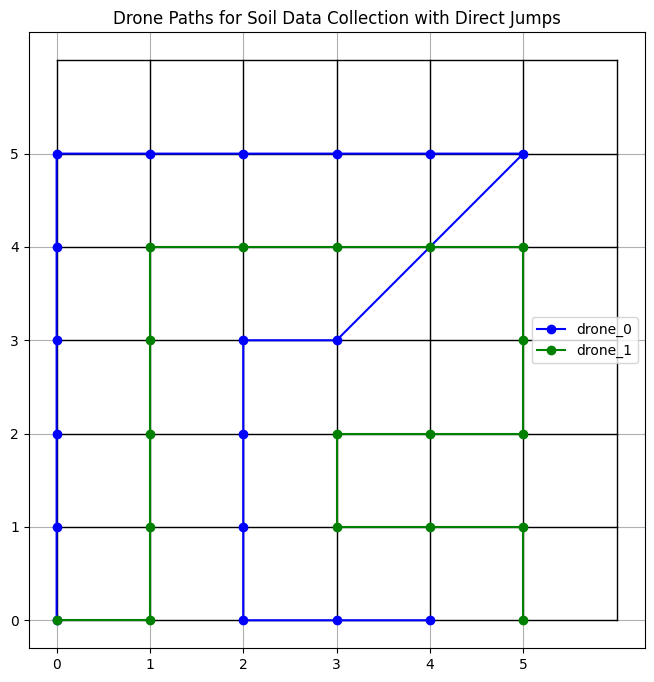

In [34]:
import matplotlib.pyplot as plt
from collections import deque
import math

# Parameters
grid_width = 6
grid_height = 6
start_position = (0, 0)
visited = set()
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
visited.add(start_position)
drone_paths = {"drone_0": [start_position], "drone_1": [start_position]}
drone_distances = {"drone_0": 0, "drone_1": 0}

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def find_nearest_unvisited(current_position, visited):
    """Scan the grid to find the nearest unvisited cell using Euclidean distance."""
    min_distance = float('inf')
    nearest_position = None
    x0, y0 = current_position

    for x in range(grid_width):
        for y in range(grid_height):
            if (x, y) not in visited and is_within_bounds(x, y):
                distance = math.sqrt((x - x0) ** 2 + (y - y0) ** 2)  # Euclidean distance
                if distance < min_distance:
                    min_distance = distance
                    nearest_position = (x, y)

    if nearest_position:
        visited.add(nearest_position)
        return nearest_position
    return None

def get_next_position(current_position, visited, drone_name):
    """Determine the next position by first trying adjacent cells, then looking for the nearest unvisited cell."""
    x, y = current_position
    # Movement directions include diagonals: up, right, down, left, and diagonals
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny)

    # If no immediate neighbors are available, find the nearest unvisited cell
    return find_nearest_unvisited(current_position, visited)

def simulate_drones():
    """Simulate the movement of both drones."""
    while drones["drone_0"] or drones["drone_1"]:
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += 1  # Count each move as 1 meter

simulate_drones()

def print_drone_routes_and_distances(drone_paths, drone_distances):
    """Prints each drone's route and the distance covered."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"({x}, {y})" for x, y in path])
        distance_str = f"Distance of the route: {drone_distances[drone_name]}m"
        print(route_str)
        print(distance_str)

# Print each drone's route and distance
print_drone_routes_and_distances(drone_paths, drone_distances)

# Plotting the routes for each drone
def plot_drone_routes(drone_paths, grid_width, grid_height):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}

    # Draw grid lines
    for x in range(grid_width + 1):
        ax.plot([x, x], [0, grid_height], 'k', lw=1)
    for y in range(grid_height + 1):
        ax.plot([0, grid_width], [y, y], 'k', lw=1)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name]+'o-', label=f"{drone_name}")

    ax.set_aspect('equal')
    plt.xticks(range(grid_width))
    plt.yticks(range(grid_height))
    plt.grid(True)
    plt.legend()
    plt.title("Drone Paths for Soil Data Collection with Direct Jumps")
    plt.show()

# Visualize the paths taken by each drone
plot_drone_routes(drone_paths, grid_width, grid_height)


### Revise final

Route for drone_0:
0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 4,6 -> 5,6 -> 6,6 -> 4,4 -> 3,4 -> 2,4 -> 2,3 -> 2,2 -> 2,1 -> 3,1 -> 4,1 -> 5,1 -> 6,1 -> 0,0
Distance of the route: 46 meters including return to start.
Route for drone_1:
0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 6,5 -> 6,4 -> 5,4 -> 5,3 -> 4,3 -> 3,3 -> 3,2 -> 4,2 -> 5,2 -> 6,2 -> 6,3 -> 6,0 -> 5,0 -> 4,0 -> 3,0 -> 2,0 -> 0,0
Distance of the route: 55 meters including return to start.


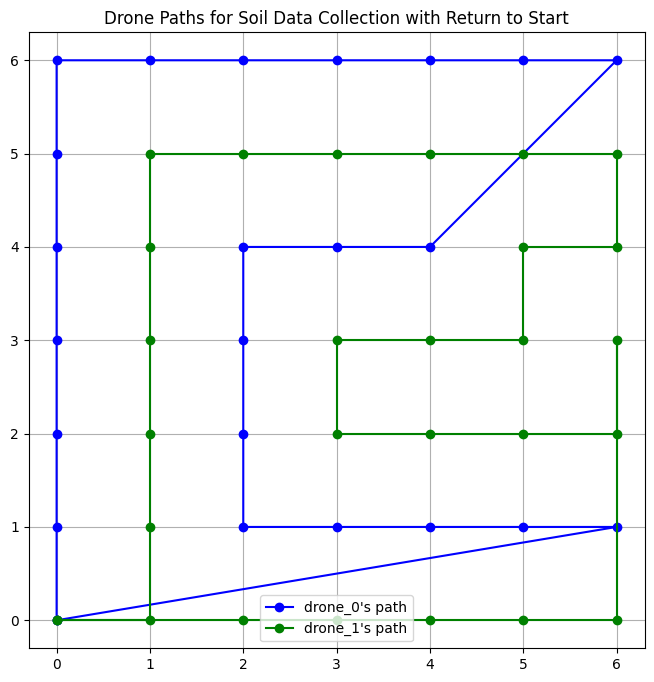

In [21]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from itertools import product

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0, "drone_1": 0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def get_next_position(current_position, visited, drone_name):
    """Determine the next position and move distance."""
    x, y = current_position
    
    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            return (nx, ny), 1  # Move of 1 meter
    
    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                visited.add((nx, ny))
                drone_paths[drone_name].append((nx, ny))
                return (nx, ny), step  # Jump of step meters
    
    return None, 0  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += move_distance  # Update distance based on move type
    # Estimate return path to start
    for drone_name, path in drone_paths.items():
        if path[-1] != start_position:
            path.append(start_position)
            # Adding the distance to return to the start as the length of the path (simplified)
            drone_distances[drone_name] += len(path) - 1

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x},{y}" for x, y in path])
        distance_str = f"Distance of the route: {drone_distances[drone_name]} meters including return to start."
        print(route_str)
        print(distance_str)

simulate_drones()
print_drone_routes_and_distances()

def plot_drone_routes():
    """Plotting the routes for each drone."""
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}
    
    # Draw grid lines
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)

    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name] + 'o-', label=f"{drone_name}'s path")

    ax.set_aspect('equal')
    ax.legend()
    plt.title("Drone Paths for Soil Data Collection with Return to Start")
    plt.show()

plot_drone_routes()

### corrected distance

Route for drone_0:
0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 4,6 -> 5,6 -> 6,6 -> 4,4 -> 3,4 -> 2,4 -> 2,3 -> 2,2 -> 2,1 -> 3,1 -> 4,1 -> 5,1 -> 6,1 -> 0,0
Distance of the route: 29.91 meters including return to start.
Route for drone_1:
0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 6,5 -> 6,4 -> 5,4 -> 5,3 -> 4,3 -> 3,3 -> 3,2 -> 4,2 -> 5,2 -> 6,2 -> 6,3 -> 6,0 -> 5,0 -> 4,0 -> 3,0 -> 2,0 -> 0,0
Distance of the route: 30.00 meters including return to start.


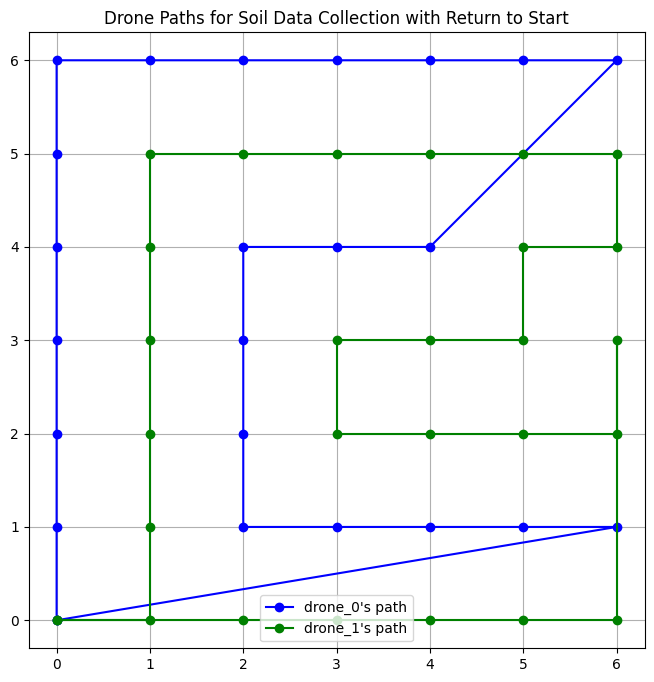

In [33]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def get_next_position(current_position, visited, drone_name):
    """Determine the next position and move distance."""
    x, y = current_position
    
    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            visited.add((nx, ny))
            drone_paths[drone_name].append((nx, ny))
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance
        
    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                visited.add((nx, ny))
                drone_paths[drone_name].append((nx, ny))
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance
        
    return None, 0  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited, drone_name)
                if next_position:
                    queue.append(next_position)
                    drone_distances[drone_name] += move_distance  # Update distance based on move type
    # Estimate return path to start
    for drone_name, path in drone_paths.items():
        if path[-1] != start_position:
            return_distance = euclidean_distance(path[-1], start_position)
            drone_distances[drone_name] += return_distance
            path.append(start_position)
    
def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x},{y}" for x, y in path])
        distance_str = f"Distance of the route: {drone_distances[drone_name]:.2f} meters including return to start."
        print(route_str)
        print(distance_str)
    
simulate_drones()
print_drone_routes_and_distances()

def plot_drone_routes():
    """Plotting the routes for each drone."""
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}
    
    # Draw grid lines
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    
    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name] + 'o-', label=f"{drone_name}'s path")
    
    ax.set_aspect('equal')
    ax.legend()
    plt.title("Drone Paths for Soil Data Collection with Return to Start")
    plt.show()

plot_drone_routes()


In [35]:
# import matplotlib.pyplot as plt
# from collections import deque, defaultdict
# import math

# # Parameters
# grid_width = 7
# grid_height = 7
# start_position = (0, 0)
# visited = set([start_position])
# drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
# drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
# drone_distances = {"drone_0": 0.0, "drone_1": 0.0}

# # Movement directions: up, right, down, left, and diagonals
# directions = [
#     (0, 1), (1, 0), (0, -1), (-1, 0),   # Adjacent directions
#     (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
# ]

# def is_within_bounds(x, y):
#     """Check if the position is within the grid bounds."""
#     return 0 <= x < grid_width and 0 <= y < grid_height

# def euclidean_distance(pos1, pos2):
#     """Calculate Euclidean distance between two points."""
#     x1, y1 = pos1
#     x2, y2 = pos2
#     return math.hypot(x2 - x1, y2 - y1)

# def get_next_position(current_position, visited, drone_name):
#     """Determine the next position and move distance."""
#     x, y = current_position
    
#     # Try adjacent cells first
#     for dx, dy in directions[:4]:  # Only the first four are adjacent moves
#         nx, ny = x + dx, y + dy
#         if is_within_bounds(nx, ny) and (nx, ny) not in visited:
#             visited.add((nx, ny))
#             drone_paths[drone_name].append((nx, ny))
#             move_distance = euclidean_distance(current_position, (nx, ny))
#             return (nx, ny), move_distance  # Move distance based on Euclidean distance
        
#     # If no adjacent cells are available, try jumping
#     for step in range(2, 4):  # Jump by 2 or 3 cells
#         for dx, dy in directions:
#             nx, ny = x + step * dx, y + step * dy
#             if is_within_bounds(nx, ny) and (nx, ny) not in visited:
#                 visited.add((nx, ny))
#                 drone_paths[drone_name].append((nx, ny))
#                 move_distance = euclidean_distance(current_position, (nx, ny))
#                 return (nx, ny), move_distance  # Move distance based on Euclidean distance
        
#     return None, 0  # No accessible cell found

# def simulate_drones():
#     """Simulate the movement of both drones and account for move distances."""
#     while any(drones.values()):
#         for drone_name, queue in drones.items():
#             if queue:
#                 current_position = queue.popleft()
#                 next_position, move_distance = get_next_position(current_position, visited, drone_name)
#                 if next_position:
#                     queue.append(next_position)
#                     drone_distances[drone_name] += move_distance  # Update distance based on move type
#     # Estimate return path to start
#     for drone_name, path in drone_paths.items():
#         if path[-1] != start_position:
#             return_distance = euclidean_distance(path[-1], start_position)
#             drone_distances[drone_name] += return_distance
#             path.append(start_position)
    
# def print_drone_routes_and_distances():
#     """Prints each drone's route and the distance covered."""
#     for drone_name, path in drone_paths.items():
#         route_str = f"Route for {drone_name}:\n"
#         route_str += " -> ".join([f"{x},{y}" for x, y in path])
#         distance_str = f"Distance of the route: {drone_distances[drone_name]:.2f} meters including return to start."
#         print(route_str)
#         print(distance_str)
    
# simulate_drones()
# print_drone_routes_and_distances()

# def plot_drone_routes():
#     """Plotting the routes for each drone."""
#     fig, ax = plt.subplots(figsize=(8, 8))
#     colors = {'drone_0': 'b', 'drone_1': 'g'}
    
#     # Draw grid lines
#     ax.set_xticks(range(grid_width + 1))
#     ax.set_yticks(range(grid_height + 1))
#     ax.grid(True)
    
#     # Plot each drone's route
#     for drone_name, path in drone_paths.items():
#         x_points, y_points = zip(*path)
#         ax.plot(x_points, y_points, colors[drone_name] + 'o-', label=f"{drone_name}'s path")
    
#     ax.set_aspect('equal')
#     ax.legend()
#     plt.title("Drone Paths for Soil Data Collection with Return to Start")
#     plt.show()

# plot_drone_routes()


Route for drone_0:
0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 4,6 -> 5,6 -> 6,6 -> 4,4 -> 3,4 -> 2,4 -> 2,3 -> 2,2 -> 0,0 -> 2,0 -> 2,1 -> 4,1 -> 4,2 -> 6,2 -> 6,3 -> 6,1 -> 0,0
Total distance covered: 38.74 meters including returns to start.
--------------------------------------------------
Route for drone_1:
0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 6,5 -> 6,4 -> 5,4 -> 5,3 -> 4,3 -> 3,3 -> 3,2 -> 0,0 -> 3,0 -> 3,1 -> 5,1 -> 5,2 -> 5,0 -> 4,0 -> 6,0 -> 0,0
Total distance covered: 38.61 meters including returns to start.
--------------------------------------------------


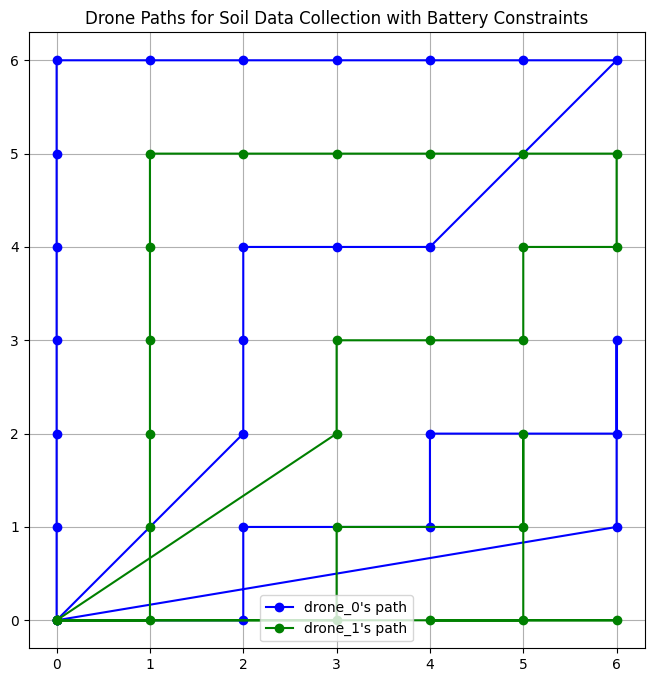

In [50]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 22  # Adjust this value as needed

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def get_next_position(current_position, visited, drone_name):
    """Determine the next position and move distance."""
    x, y = current_position
    
    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            move_distance = euclidean_distance(current_position, (nx, ny))
            # We only return the position here; battery check will be in simulate_drones()
            return (nx, ny), move_distance  # Move distance based on Euclidean distance
        
    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance
        
    return None, 0  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited, drone_name)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - drone_battery_consumed[drone_name]
                    return_distance = euclidean_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        drone_battery_consumed[drone_name] += move_distance
                        drone_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_distance = euclidean_distance(current_position, start_position)
                        if return_distance <= remaining_battery:
                            # Return to start
                            drone_distances[drone_name] += return_distance
                            drone_battery_consumed[drone_name] += return_distance
                            drone_paths[drone_name].append(start_position)
                            drone_battery_consumed[drone_name] = 0.0  # Reset battery consumption
                            # Start from start_position again
                            queue.append(start_position)
                        else:
                            # Can't return to start, battery depleted
                            print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")
                            queue.clear()
                else:
                    # No accessible cell found, need to return to start
                    remaining_battery = BATTERY_CAPACITY - drone_battery_consumed[drone_name]
                    return_distance = euclidean_distance(current_position, start_position)
                    if return_distance <= remaining_battery:
                        # Return to start
                        drone_distances[drone_name] += return_distance
                        drone_battery_consumed[drone_name] += return_distance
                        drone_paths[drone_name].append(start_position)
                        drone_battery_consumed[drone_name] = 0.0  # Reset battery consumption
                        queue.clear()
                    else:
                        # Can't return to start
                        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")
                        queue.clear()
    # After the loop, ensure drones are at start position
    for drone_name, path in drone_paths.items():
        if path[-1] != start_position:
            remaining_battery = BATTERY_CAPACITY - drone_battery_consumed[drone_name]
            return_distance = euclidean_distance(path[-1], start_position)
            if return_distance <= remaining_battery:
                drone_distances[drone_name] += return_distance
                drone_battery_consumed[drone_name] += return_distance
                path.append(start_position)
                drone_battery_consumed[drone_name] = 0.0  # Reset battery consumption
            else:
                print(f"{drone_name} cannot return to start from position {path[-1]} at the end. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    for drone_name, path in drone_paths.items():
        route_str = f"Route for {drone_name}:\n"
        route_str += " -> ".join([f"{x},{y}" for x, y in path])
        distance_str = f"Total distance covered: {drone_distances[drone_name]:.2f} meters including returns to start."
        print(route_str)
        print(distance_str)
        print("-" * 50)

simulate_drones()
print_drone_routes_and_distances()

def plot_drone_routes():
    """Plotting the routes for each drone."""
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'drone_0': 'b', 'drone_1': 'g'}
    
    # Draw grid lines
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    
    # Plot each drone's route
    for drone_name, path in drone_paths.items():
        x_points, y_points = zip(*path)
        ax.plot(x_points, y_points, colors[drone_name] + 'o-', label=f"{drone_name}'s path")
    
    ax.set_aspect('equal')
    ax.legend()
    plt.title("Drone Paths for Soil Data Collection with Battery Constraints")
    plt.show()

plot_drone_routes()


### Seperate graph

Routes for drone_0:
  Trip 1: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 4,6 -> 5,6 -> 6,6 -> 4,4 -> 3,4 -> 2,4 -> 2,3 -> 2,2 -> 2,1 -> 3,1 -> 0,0
    Distance for Trip 1: 23.99 meters
  Trip 2: 0,0 -> 3,0 -> 5,0 -> 5,1 -> 5,2 -> 0,0
    Distance for Trip 2: 12.39 meters
Total distance covered by drone_0: 36.38 meters
--------------------------------------------------
Routes for drone_1:
  Trip 1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 6,5 -> 6,4 -> 5,4 -> 5,3 -> 4,3 -> 3,3 -> 3,2 -> 4,2 -> 0,0
    Distance for Trip 1: 22.47 meters
  Trip 2: 0,0 -> 2,0 -> 4,0 -> 4,1 -> 6,1 -> 6,2 -> 6,3 -> 6,0 -> 0,0
    Distance for Trip 2: 18.00 meters
Total distance covered by drone_1: 40.47 meters
--------------------------------------------------


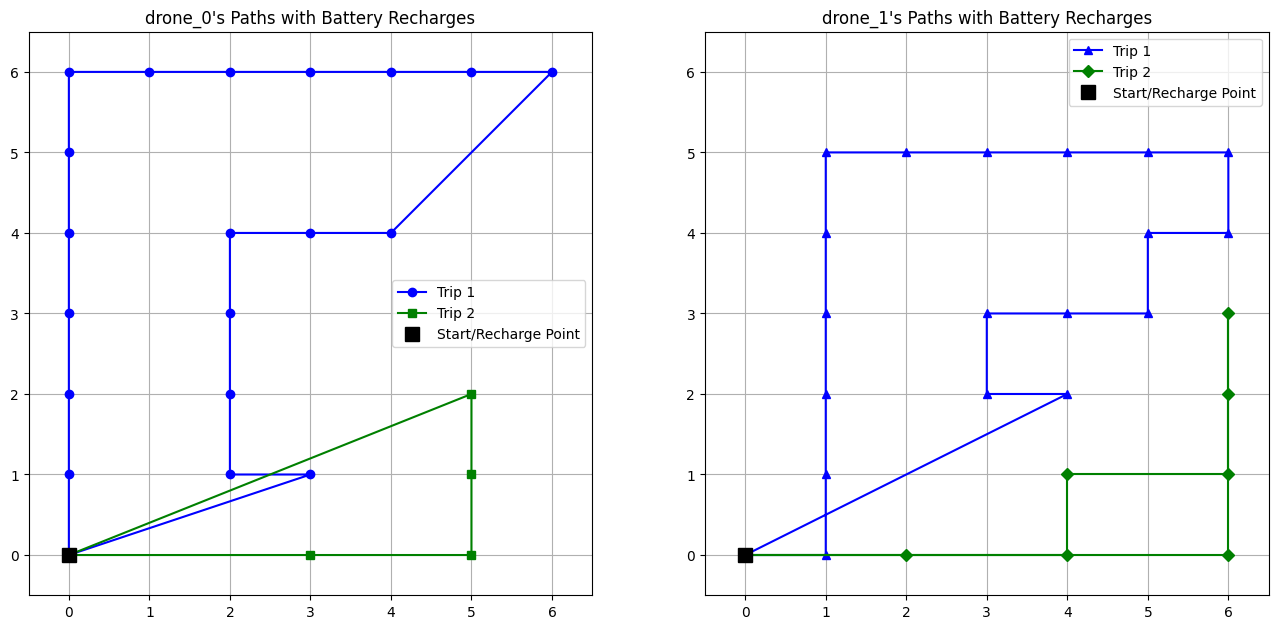

In [51]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import itertools

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}
drone_trips = {"drone_0": [], "drone_1": []}  # Stores segments between recharges

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 24.0  # Adjust this value as needed

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def get_next_position(current_position, visited, drone_name):
    """Determine the next position and move distance."""
    x, y = current_position

    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance

    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance

    return None, 0  # No accessible cell found

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited, drone_name)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - drone_battery_consumed[drone_name]
                    return_distance = euclidean_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        drone_battery_consumed[drone_name] += move_distance
                        drone_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position)
                        # Start from start_position again
                        queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position)
                    queue.clear()
    # After the loop, ensure drones are at start position
    for drone_name, path in drone_paths.items():
        if path[-1] != start_position:
            return_to_start(drone_name, path[-1])

def return_to_start(drone_name, current_position):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - drone_battery_consumed[drone_name]
    return_distance = euclidean_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        drone_battery_consumed[drone_name] += return_distance
        drone_paths[drone_name].append(start_position)
        # Record this trip segment
        drone_trips[drone_name].append(drone_paths[drone_name][:])
        # Reset path for next trip
        drone_paths[drone_name] = [start_position]
        drone_battery_consumed[drone_name] = 0.0  # Reset battery consumption
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    for drone_name, trips in drone_trips.items():
        print(f"Routes for {drone_name}:")
        total_distance = 0.0
        for i, trip in enumerate(trips):
            route_str = f"  Trip {i+1}: " + " -> ".join([f"{x},{y}" for x, y in trip])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(trip[i], trip[i+1]) for i in range(len(trip)-1))
            total_distance += trip_distance
            print(f"    Distance for Trip {i+1}: {trip_distance:.2f} meters")
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")
        print("-" * 50)

simulate_drones()
print_drone_routes_and_distances()

def plot_drone_routes():
    """Plotting the routes for each drone, showing trips between recharges."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Colors and markers for plotting
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = itertools.cycle(('o-', 's-', '^-', 'D-', '*-', 'x-'))

    for idx, drone_name in enumerate(drones.keys()):
        ax = axes[idx]
        ax.set_title(f"{drone_name}'s Paths with Battery Recharges")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        for trip_idx, trip in enumerate(drone_trips[drone_name]):
            x_points, y_points = zip(*trip)
            color = colors[trip_idx % len(colors)]
            marker = next(markers)
            ax.plot(x_points, y_points, marker, color=color, label=f"Trip {trip_idx+1}")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()

    plt.show()

plot_drone_routes()


Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 4,6 -> 5,6 -> 6,6 -> 4,4 -> 3,4 -> 2,4 -> 2,3 -> 2,2 -> 0,0
    Distance for drone_0: 21.66 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 6,5 -> 6,4 -> 5,4 -> 5,3 -> 4,3 -> 3,3 -> 3,2 -> 0,0
    Distance for drone_1: 20.61 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 2,1 -> 4,1 -> 4,2 -> 6,2 -> 6,3 -> 6,1 -> 0,0
    Distance for drone_0: 17.08 meters
  drone_1: 0,0 -> 3,0 -> 3,1 -> 5,1 -> 5,2 -> 5,0 -> 4,0 -> 6,0 -> 0,0
    Distance for drone_1: 18.00 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------
Total distance covered by drone_0: 38.74 meters
Total distance covered by drone_1: 38.61 meters


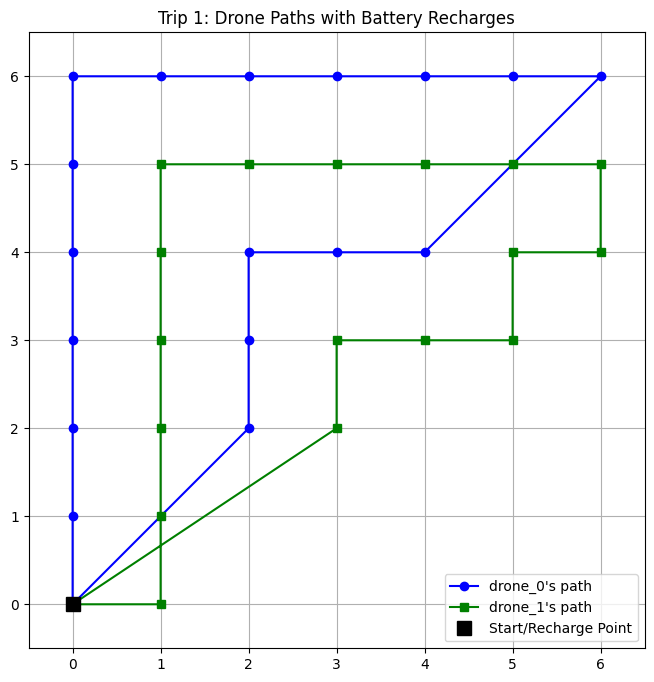

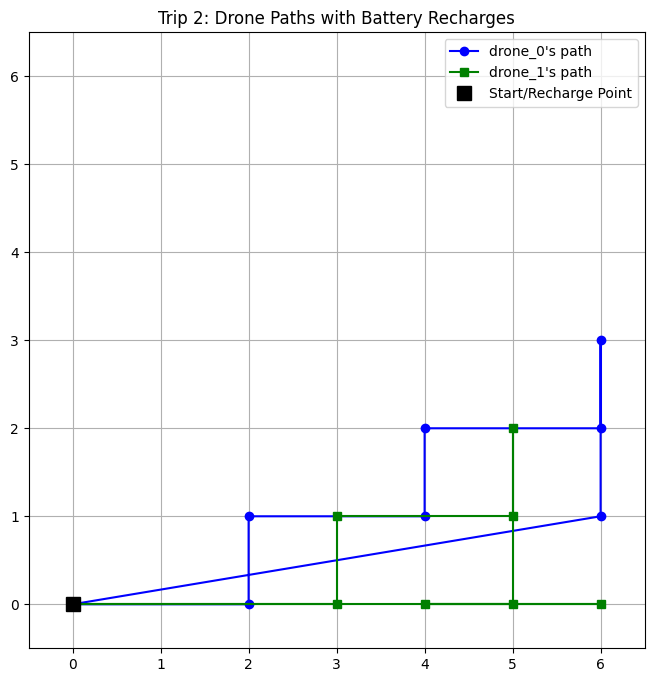

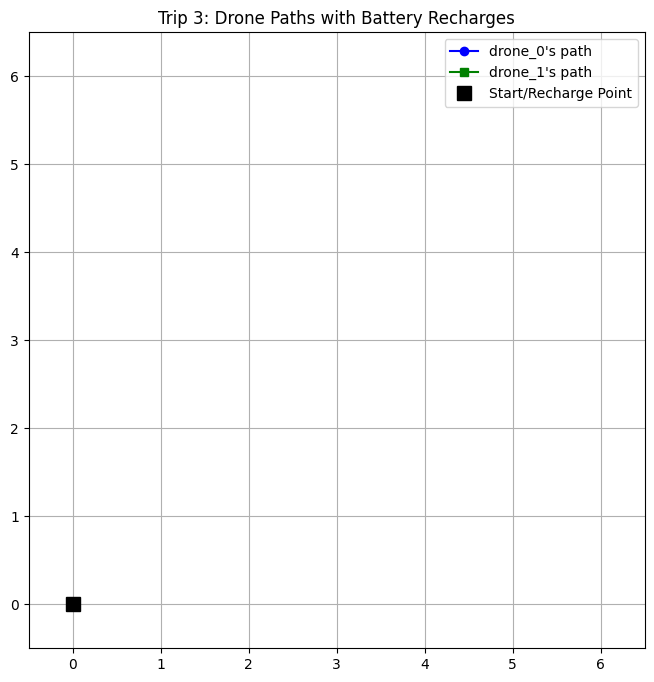

In [52]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import itertools

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 22  # Adjust this value as needed

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def get_next_position(current_position, visited):
    """Determine the next position and move distance."""
    x, y = current_position

    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance

    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance

    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    return_distance = euclidean_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again
                        queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = euclidean_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

simulate_drones()
print_drone_routes_and_distances()

def plot_trips():
    """Plot each trip separately, showing paths of both drones."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

plot_trips()

In [3]:
# dynamically route path when objects are there 
# return path should be free of obstacles
# visit points when returning
# convert any land to a square

### mamhattan

Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 0,7 -> 0,8 -> 0,9 -> 1,9 -> 2,9 -> 3,9 -> 4,9 -> 5,9 -> 6,9 -> 0,0
    Distance for drone_0: 25.82 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 1,6 -> 1,7 -> 1,8 -> 2,8 -> 3,8 -> 4,8 -> 5,8 -> 6,8 -> 7,8 -> 0,0
    Distance for drone_1: 25.63 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 2,1 -> 3,1 -> 3,2 -> 3,3 -> 3,4 -> 3,5 -> 3,6 -> 4,6 -> 5,6 -> 6,6 -> 7,6 -> 8,6 -> 9,6 -> 0,0
    Distance for drone_0: 25.82 meters
  drone_1: 0,0 -> 2,2 -> 2,3 -> 2,4 -> 2,5 -> 2,6 -> 2,7 -> 3,7 -> 4,7 -> 5,7 -> 6,7 -> 7,7 -> 8,7 -> 0,0
    Distance for drone_1: 24.46 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0 -> 3,0 -> 4,0 -> 4,1 -> 4,2 -> 4,3 -> 4,4 -> 4,5 -> 5,5 -> 6,5 -> 7,5 -> 8,5 -> 9,5 -> 9,4 -> 8,4 -> 7,4 -> 6,4 -> 5,4 -> 5,3 -> 6,3 -> 0,0
    Distance for drone_0: 27.71 meters
  drone_1: 0,0
    Distance for drone_1: 0.0

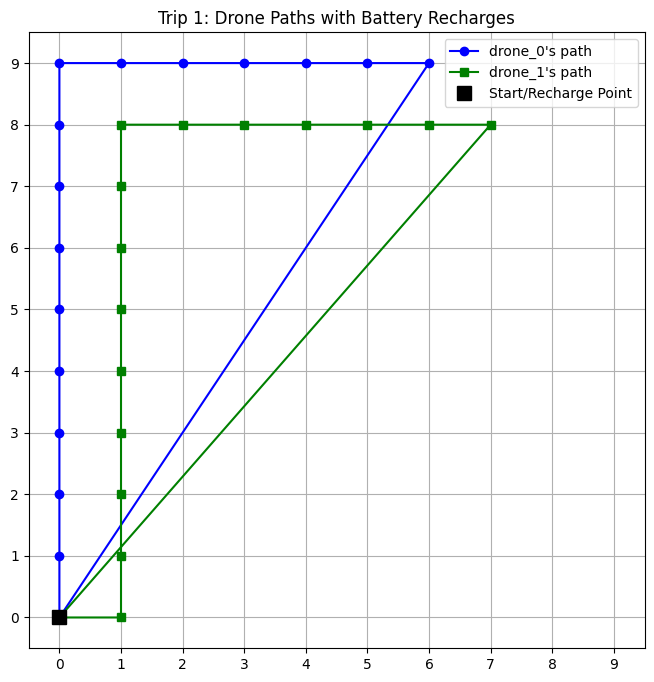

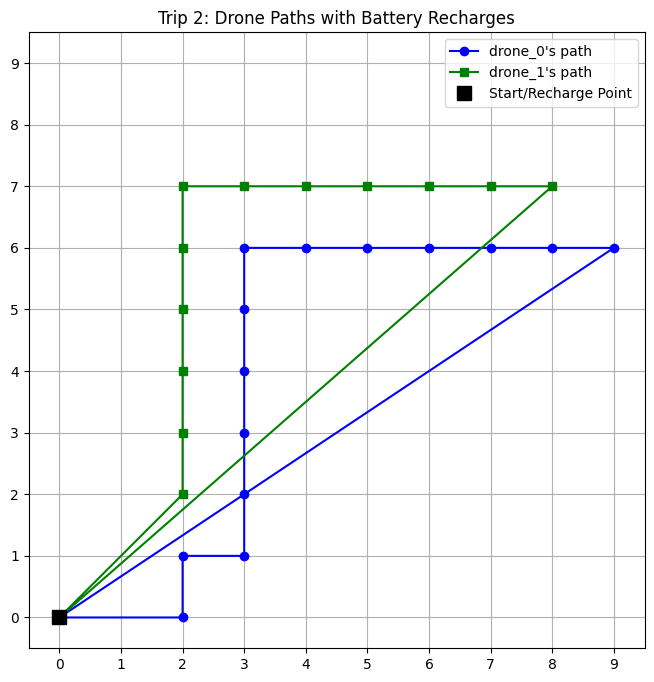

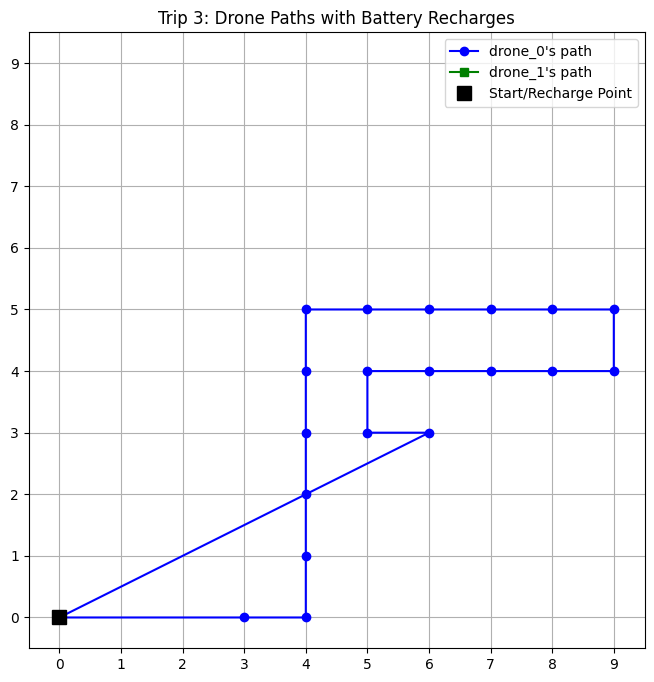

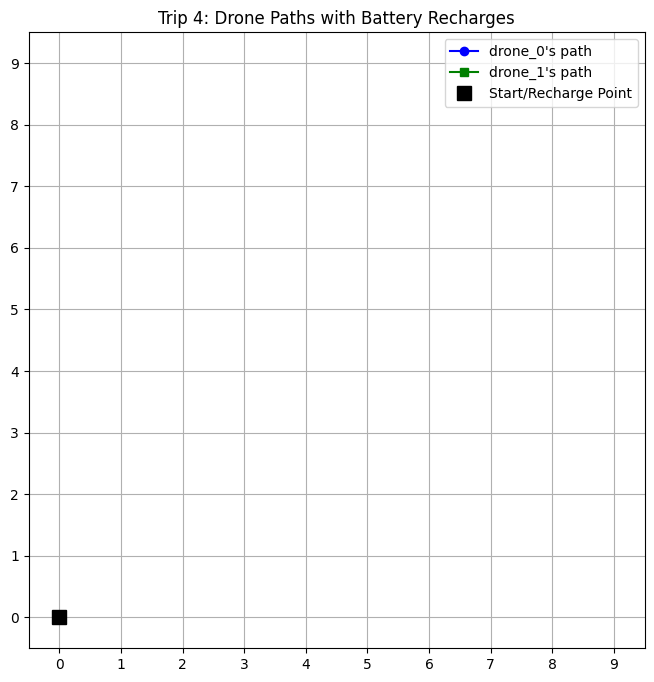

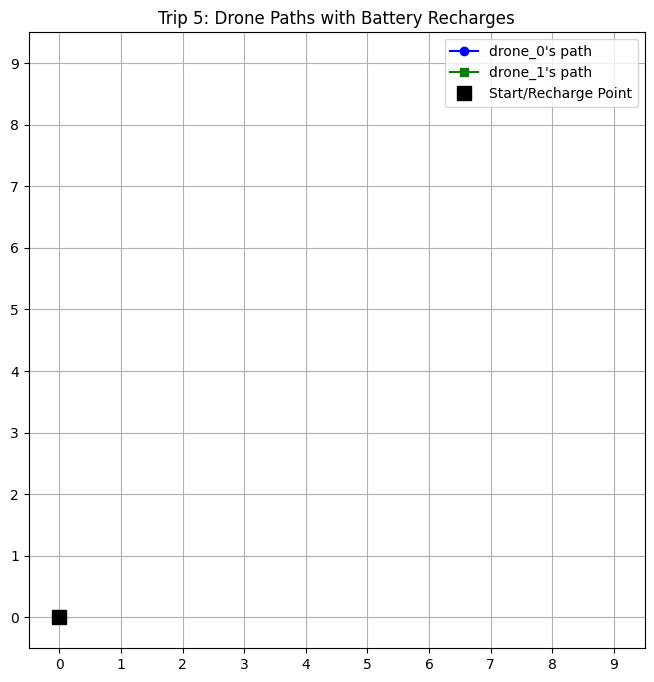

In [8]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import itertools

# Parameters
grid_width = 10
grid_height = 10
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 30  # Adjust this value as needed

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def get_next_position(current_position, visited):
    """Determine the next position and move distance."""
    x, y = current_position

    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance

    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance

    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again
                        queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

simulate_drones()
print_drone_routes_and_distances()

def plot_trips():
    """Plot each trip separately, showing paths of both drones."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

plot_trips()

### manhattan fix

Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 0,7 -> 0,8 -> 0,9 -> 1,9 -> 2,9 -> 3,9 -> 4,9 -> 5,9 -> 6,9 -> 0,0
    Distance for drone_0: 25.82 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 1,6 -> 1,7 -> 1,8 -> 2,8 -> 3,8 -> 4,8 -> 5,8 -> 6,8 -> 7,8 -> 0,0
    Distance for drone_1: 25.63 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------
Total distance covered by drone_0: 25.82 meters
Total distance covered by drone_1: 25.63 meters


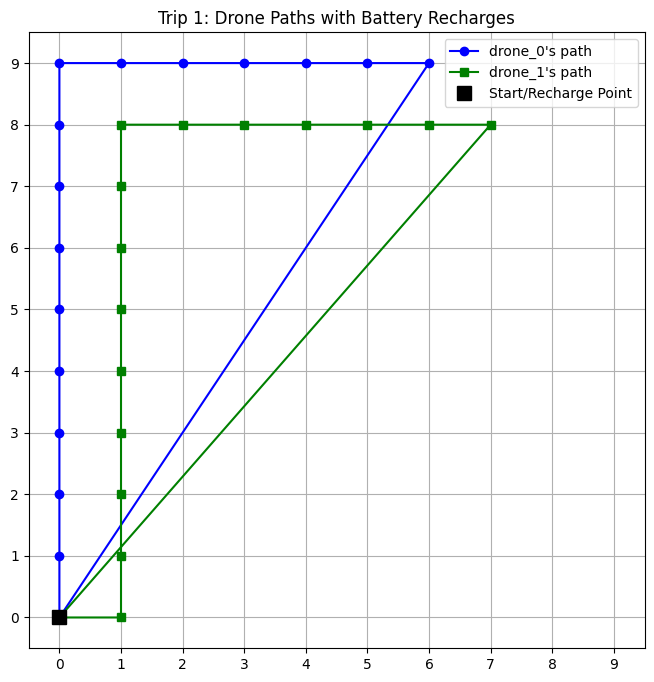

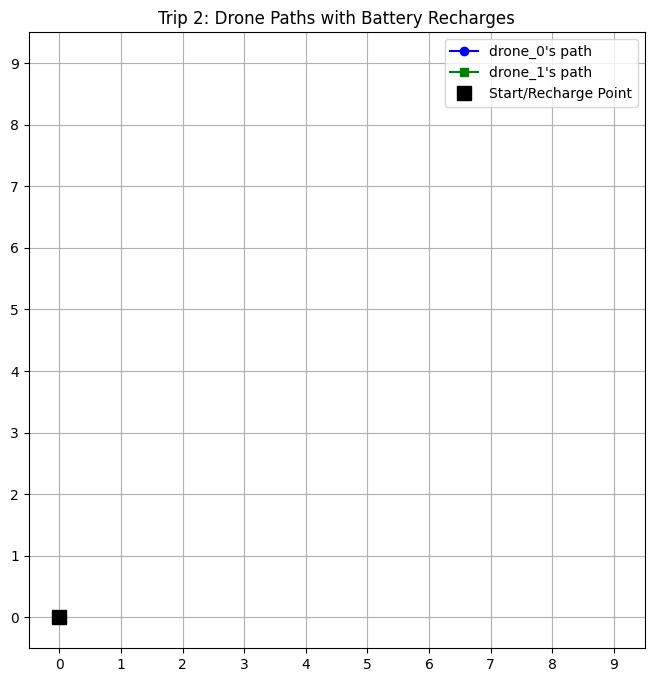

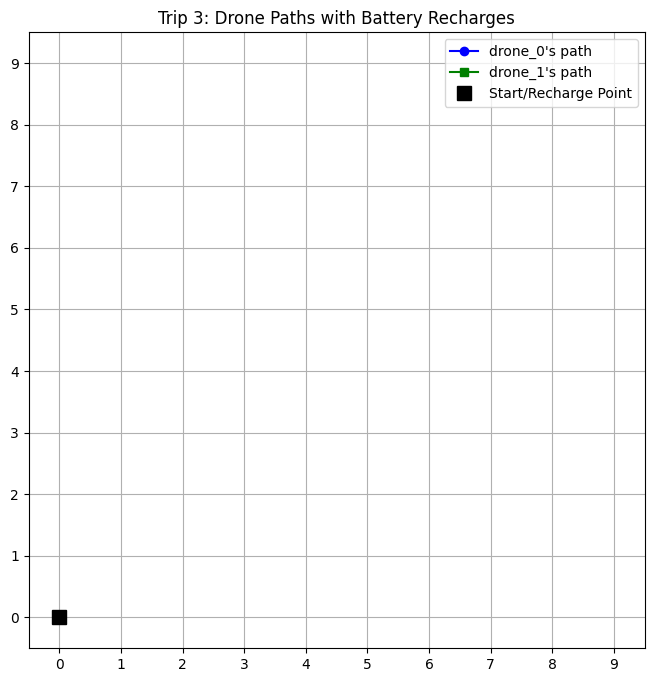

In [9]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math

# Parameters
grid_width = 10
grid_height = 10
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 30  # Adjust this value as needed

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def get_next_position(current_position, visited):
    """Determine the next position to move to."""
    x, y = current_position

    # Try adjacent cells first (4 directions only)
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance

    # No adjacent cell found, return None
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again
                        queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

simulate_drones()
print_drone_routes_and_distances()

def plot_trips():
    """Plot each trip separately, showing paths of both drones."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

plot_trips()


### new

Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 2,5 -> 2,4 -> 2,3 -> 2,2 -> 2,1 -> 2,0 -> 1,0 -> 0,0
    Distance for drone_0: 17.41 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 4,4 -> 3,4 -> 3,3 -> 3,2 -> 3,1 -> 3,0 -> 2,0 -> 1,0 -> 0,0
    Distance for drone_1: 18.00 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------
Total distance covered by drone_0: 17.41 meters
Total distance covered by drone_1: 18.00 meters


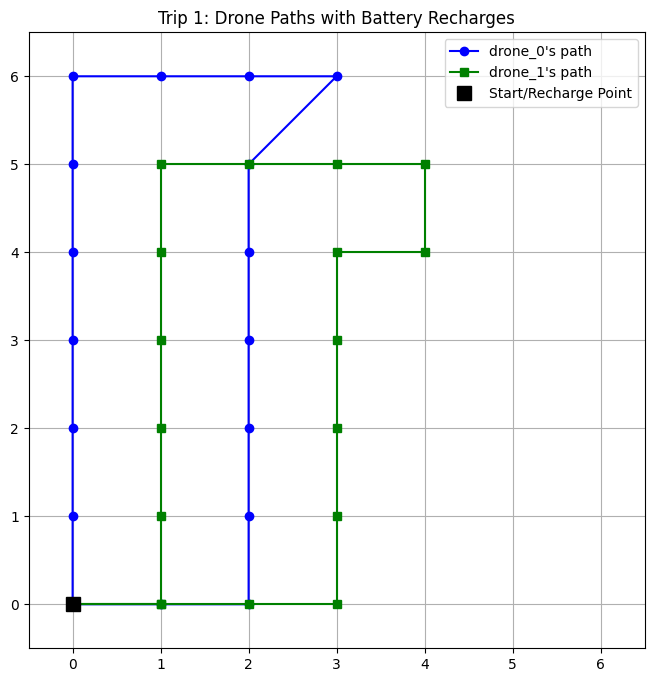

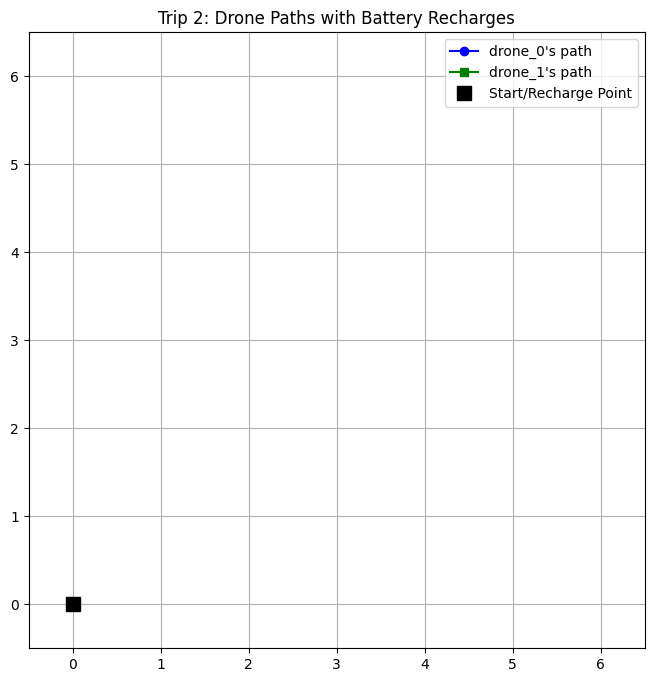

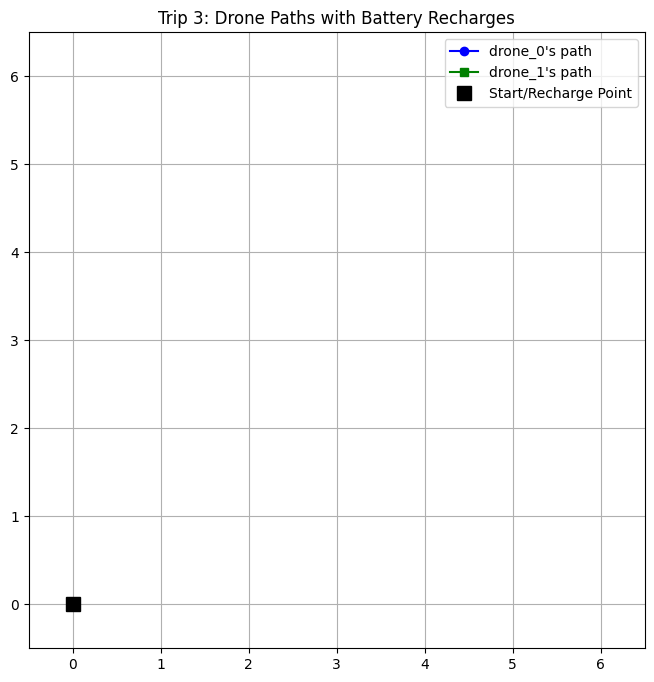

In [1]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 18  # Adjust this value as needed

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

# Return directions: towards start position (-x, -y)
return_directions = [
    (-1, 0),   # Left
    (0, -1),   # Down
    (-1, -1)   # Diagonal towards start
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def get_next_position(current_position, visited):
    """Determine the next position and move distance."""
    x, y = current_position

    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited:
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance

    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited:
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance

    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again
                        if len(visited) < grid_width * grid_height:
                            queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position, visiting accessible cells on the way."""
    while current_position != start_position:
        # Check if there is an accessible cell in the return directions
        found = False
        for dx, dy in return_directions:
            nx, ny = current_position[0] + dx, current_position[1] + dy
            next_position = (nx, ny)
            if is_within_bounds(nx, ny):
                move_distance = euclidean_distance(current_position, next_position)
                remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                required_battery = move_distance + manhattan_distance(next_position, start_position)
                if required_battery <= remaining_battery:
                    if next_position not in visited:
                        # Visit the accessible cell
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                        current_position = next_position
                        found = True
                        break
        if not found:
            # Move towards start position
            dx = -1 if current_position[0] > start_position[0] else 0
            dy = -1 if current_position[1] > start_position[1] else 0
            nx, ny = current_position[0] + dx, current_position[1] + dy
            next_position = (nx, ny)
            if is_within_bounds(nx, ny):
                move_distance = euclidean_distance(current_position, next_position)
                remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                required_battery = move_distance + manhattan_distance(next_position, start_position)
                if required_battery <= remaining_battery:
                    drone_distances[drone_name] += move_distance
                    current_trip_battery[drone_name] += move_distance
                    current_trip_paths[drone_name].append(next_position)
                    current_position = next_position
                else:
                    print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")
                    return
            else:
                # Cannot move further towards start
                print(f"{drone_name} cannot return to start from position {current_position}. Out of bounds.")
                return

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

simulate_drones()
print_drone_routes_and_distances()

def plot_trips():
    """Plot each trip separately, showing paths of both drones."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

plot_trips()


### newer


Total execution time: 493.00 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 4,6 -> 0,0
    Distance for drone_0: 17.21 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 5,5 -> 0,0
    Distance for drone_1: 17.07 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 2,1 -> 4,1 -> 4,2 -> 4,3 -> 4,4 -> 6,4 -> 0,0
    Distance for drone_0: 17.21 meters
  drone_1: 0,0 -> 3,0 -> 3,1 -> 3,2 -> 3,3 -> 3,4 -> 5,4 -> 5,3 -> 6,3 -> 6,2 -> 5,2 -> 5,1 -> 0,0
    Distance for drone_1: 19.10 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------
Trip 4:
  drone_0: 0,0
    Distance for drone_0: 0.00 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
--------------------------------------------------

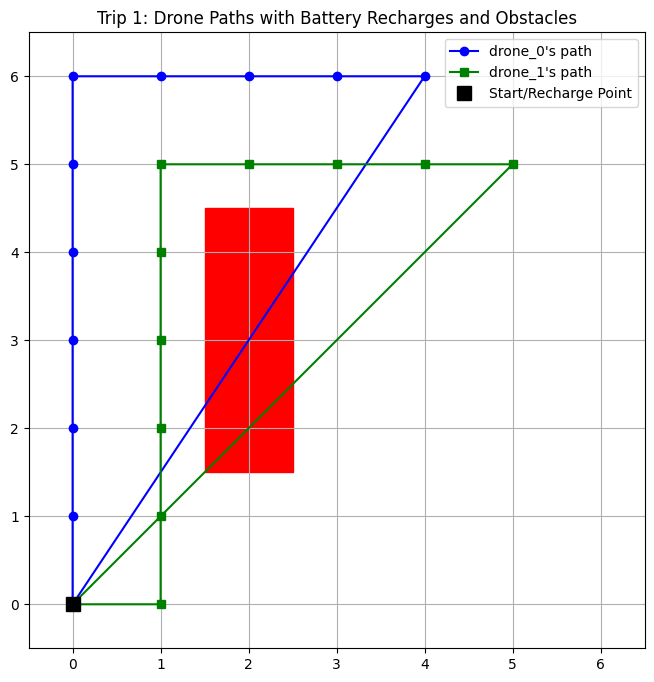

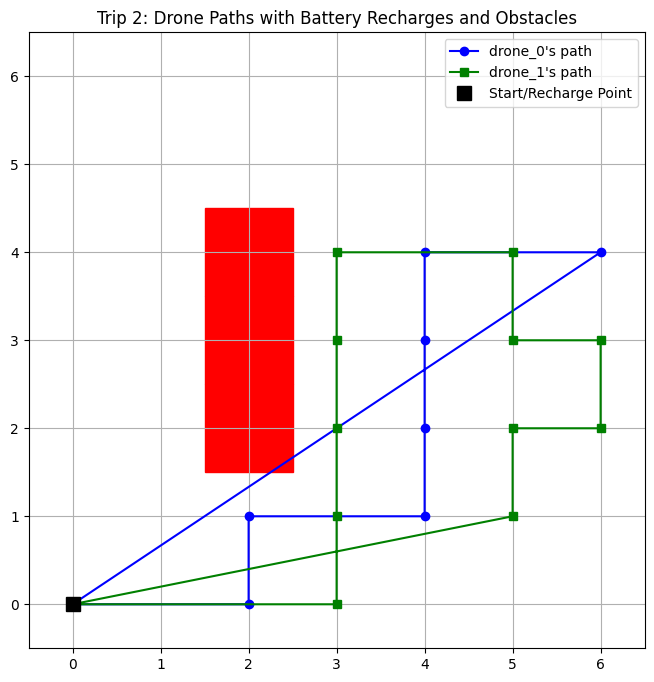

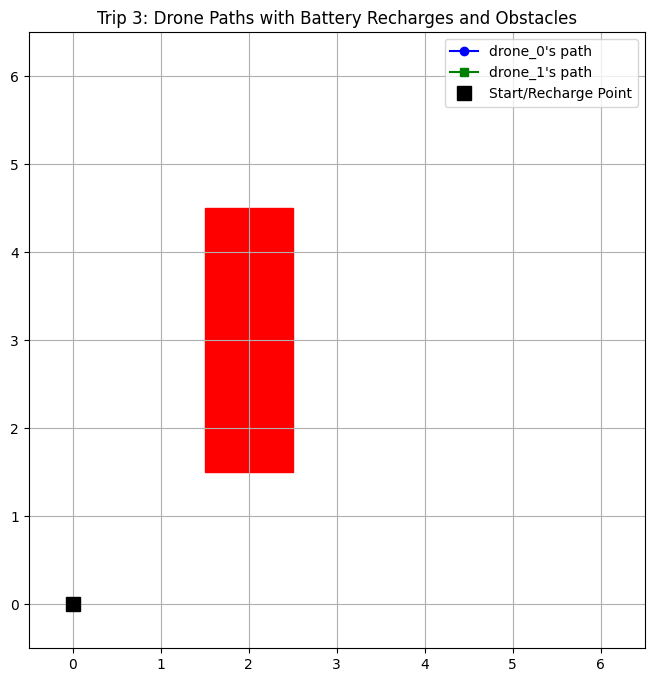

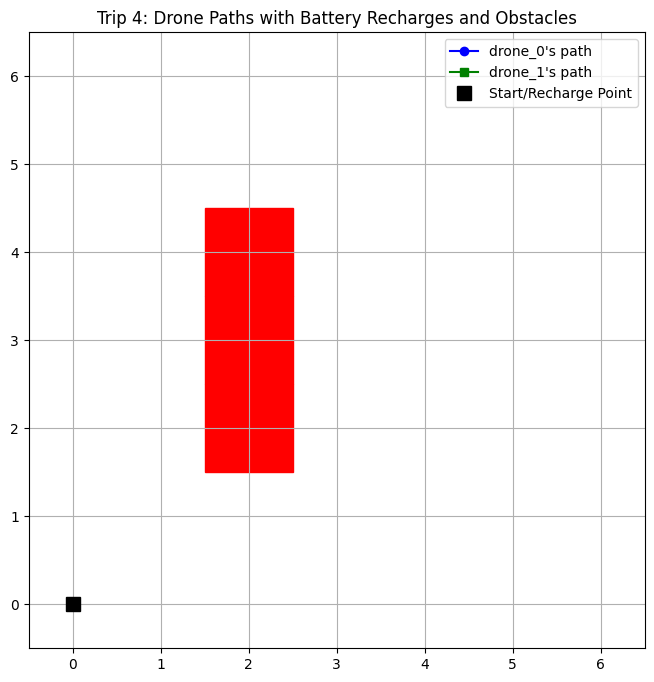

In [ ]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import itertools
import time

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 21  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {(2, 2), (2, 3), (2, 4)}  # You can add more obstacle positions here

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def get_next_position(current_position, visited):
    """Determine the next position and move distance."""
    x, y = current_position

    # Try adjacent cells first
    for dx, dy in directions[:4]:  # Only the first four are adjacent moves
        nx, ny = x + dx, y + dy
        if is_within_bounds(nx, ny) and (nx, ny) not in visited and (nx, ny) not in obstacles:
            move_distance = euclidean_distance(current_position, (nx, ny))
            return (nx, ny), move_distance  # Move distance based on Euclidean distance

    # If no adjacent cells are available, try jumping
    for step in range(2, 4):  # Jump by 2 or 3 cells
        for dx, dy in directions:
            nx, ny = x + step * dx, y + step * dy
            if is_within_bounds(nx, ny) and (nx, ny) not in visited and (nx, ny) not in obstacles:
                move_distance = euclidean_distance(current_position, (nx, ny))
                return (nx, ny), move_distance  # Move distance based on Euclidean distance

    return None, 0  


trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again
                        queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0]-0.5, obstacle[1]-0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()

### Fix


Total execution time: 90580.00 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 0,7 -> 0,8 -> 0,9 -> 0,10 -> 0,11 -> 0,12 -> 0,13 -> 0,14 -> 0,15 -> 0,16 -> 0,17 -> 0,18 -> 0,19 -> 0,20 -> 0,21 -> 0,22 -> 0,23 -> 0,24 -> 0,25 -> 0,26 -> 0,27 -> 0,28 -> 0,29 -> 0,30 -> 0,31 -> 0,32 -> 0,33 -> 0,34 -> 0,35 -> 0,36 -> 0,37 -> 0,38 -> 0,39 -> 1,39 -> 2,39 -> 3,39 -> 4,39 -> 5,39 -> 6,39 -> 7,39 -> 8,39 -> 9,39 -> 10,39 -> 11,39 -> 12,39 -> 13,39 -> 14,39 -> 15,39 -> 16,39 -> 17,39 -> 18,39 -> 19,39 -> 20,39 -> 21,39 -> 22,39 -> 23,39 -> 24,39 -> 25,39 -> 26,39 -> 27,39 -> 28,39 -> 29,39 -> 30,39 -> 31,39 -> 32,39 -> 33,39 -> 34,39 -> 35,39 -> 36,39 -> 37,39 -> 38,39 -> 39,39 -> 38,37 -> 37,37 -> 36,37 -> 35,37 -> 34,37 -> 33,37 -> 32,37 -> 31,37 -> 30,37 -> 29,37 -> 28,37 -> 27,37 -> 26,37 -> 25,37 -> 24,37 -> 23,37 -> 22,37 -> 21,37 -> 20,37 -> 19,37 -> 18,37 -> 17,37 -> 16,37 -> 15,37 -> 14,37 -> 13,37 -> 12,37 -> 11,37 -> 10,37 -> 9,37 -> 8,37 -> 7,37 ->

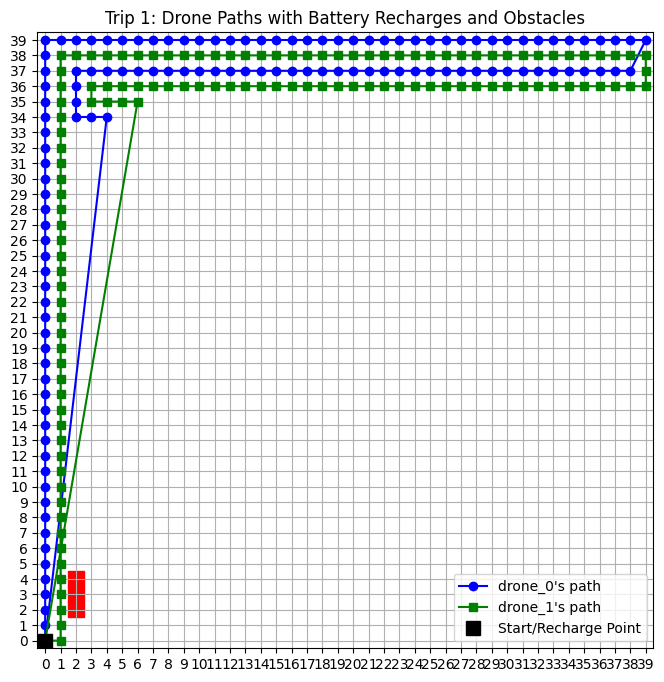

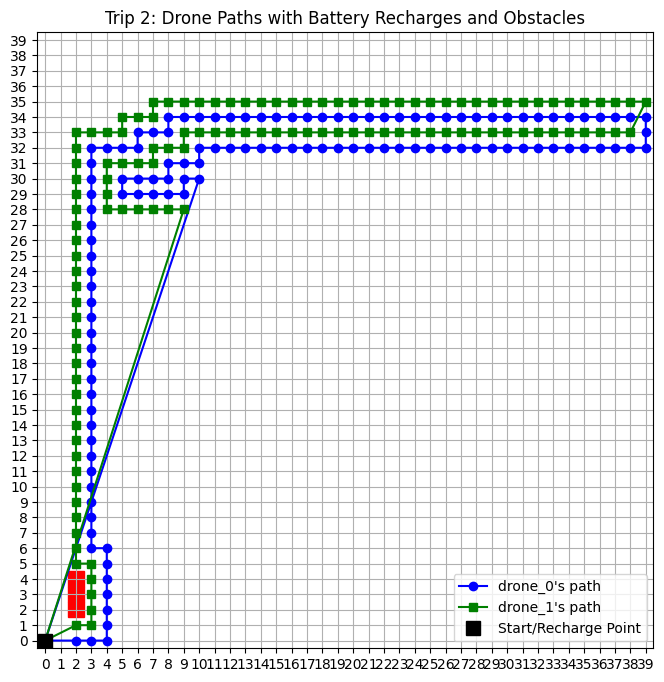

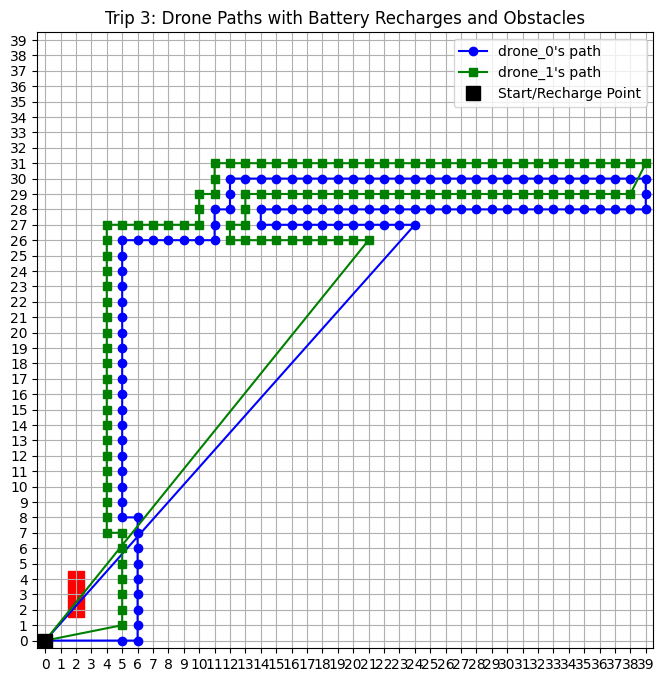

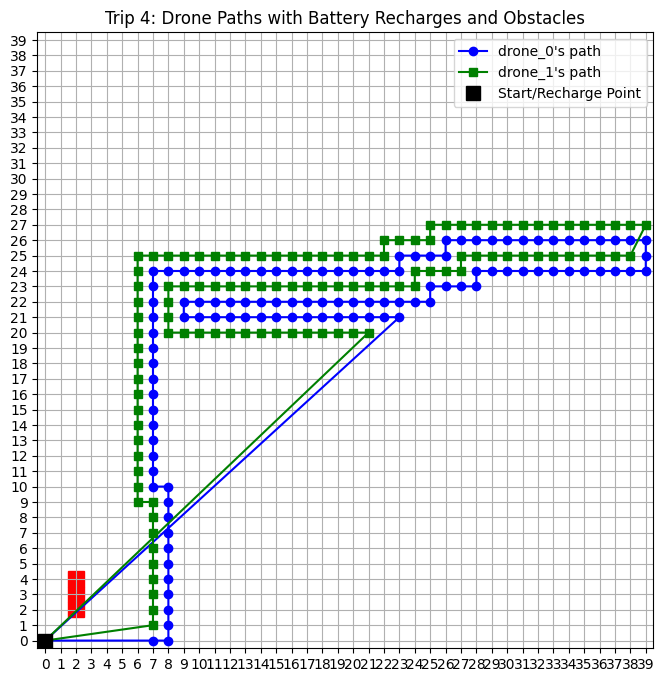

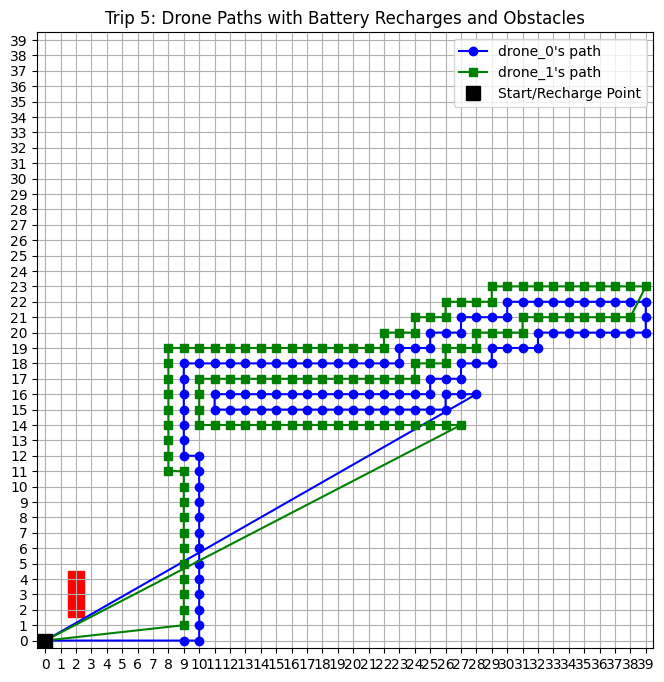

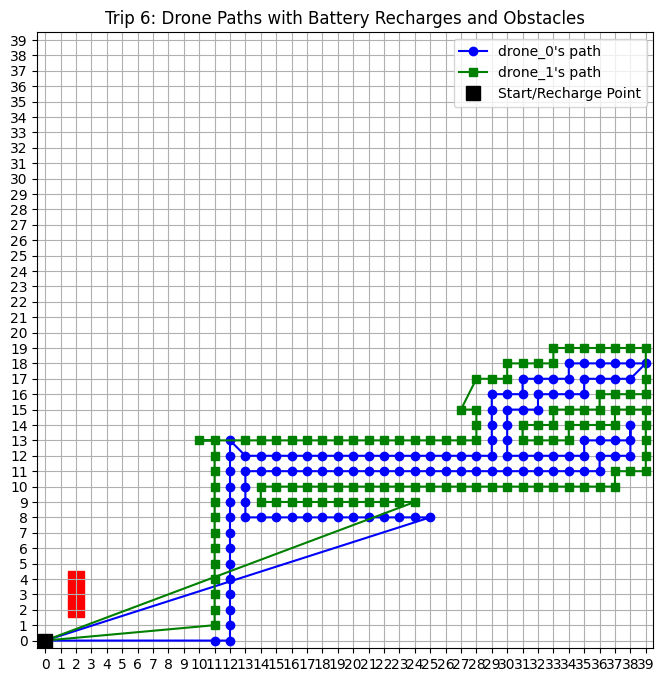

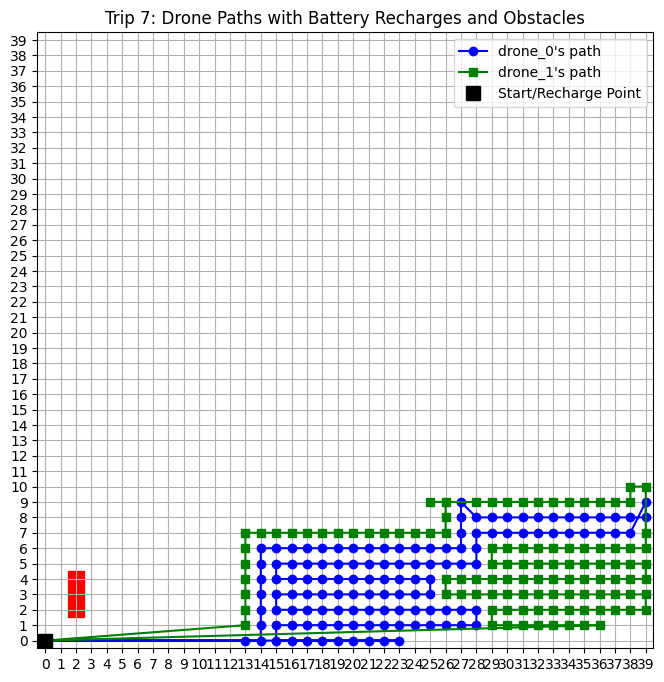

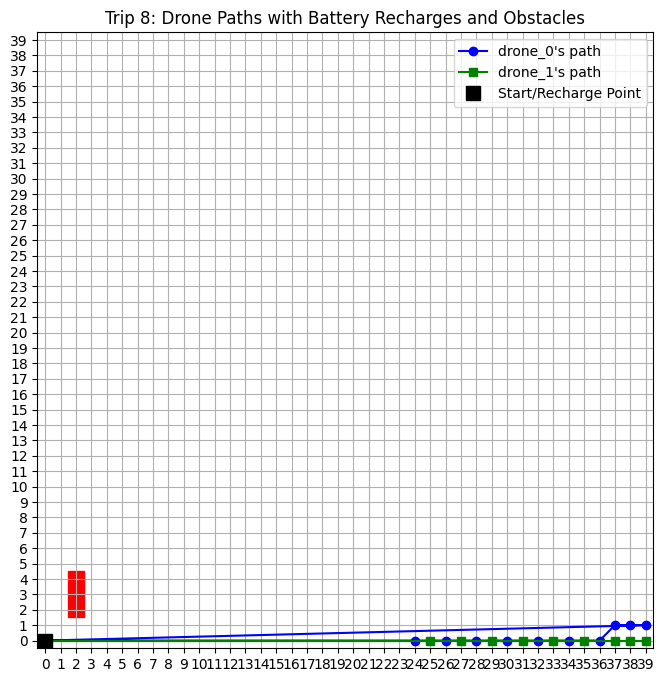

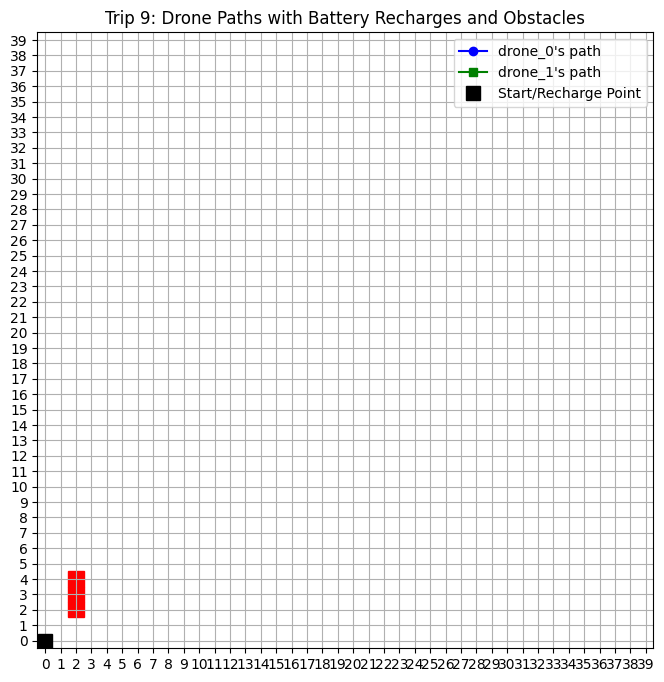

In [58]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time

# Parameters
grid_width = 40
grid_height = 40
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 160  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {(2, 2), (2, 3), (2, 4)}  # You can add more obstacle positions here

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    """Compute all positions reachable from the start without crossing obstacles."""
    from collections import deque
    reachable_positions = set()
    queue = deque([start_position])
    while queue:
        current = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            if is_within_bounds(nx, ny) and (nx, ny) not in obstacles and (nx, ny) not in reachable_positions:
                queue.append((nx, ny))
    return reachable_positions

def get_next_position(current_position, visited):
    """Determine the next position using BFS to find the nearest unvisited cell."""
    from collections import deque

    queue = deque()
    queue.append((current_position, 0))  # Include distance in the queue
    came_from = {current_position: None}
    while queue:
        (x, y), dist = queue.popleft()
        if (x, y) not in visited and (x, y) not in obstacles:
            # Reconstruct the path to the next position
            path = []
            current = (x, y)
            while current != current_position:
                path.append(current)
                current = came_from[current]
            path.append(current_position)
            path.reverse()
            move_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            return (x, y), move_distance
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            neighbor = (nx, ny)
            if is_within_bounds(nx, ny) and neighbor not in came_from and neighbor not in obstacles:
                queue.append((neighbor, dist + 1))
                came_from[neighbor] = (x, y)
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Compute reachable positions
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again
                        queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                # Check for accessible unvisited positions
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()  # No more positions to visit

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0]-0.5, obstacle[1]-0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  # Convert seconds to microseconds

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()

### less cap


Total execution time: 2805.50 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 0,0
    Distance for drone_0: 15.71 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 0,0
    Distance for drone_1: 15.40 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 3,0 -> 4,0 -> 4,1 -> 4,2 -> 4,3 -> 5,3 -> 6,3 -> 0,0
    Distance for drone_0: 15.71 meters
  drone_1: 0,0 -> 2,1 -> 3,1 -> 3,2 -> 3,3 -> 3,4 -> 4,4 -> 5,4 -> 0,0
    Distance for drone_1: 14.64 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0 -> 5,0 -> 6,0 -> 6,1 -> 0,0
    Distance for drone_0: 13.08 meters
  drone_1: 0,0 -> 5,1 -> 5,2 -> 6,2 -> 0,0
    Distance for drone_1: 13.42 meters
--------------------------------------------------
Trip 4:
  drone_0: 0,0 -> 6,4 -> 0,0
    Distance for drone_0: 14.42 meters
  drone_1: 0,0 -> 5,5 -> 0,0
    Distance for drone_1: 14.14 met

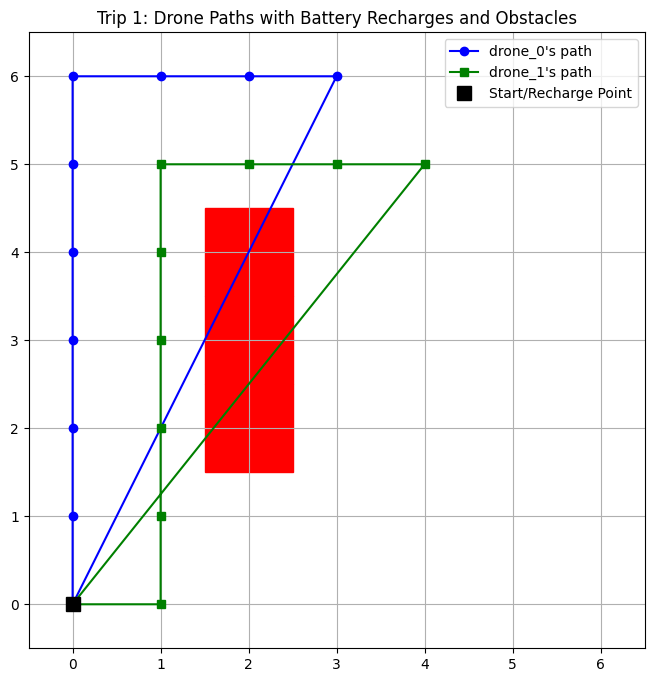

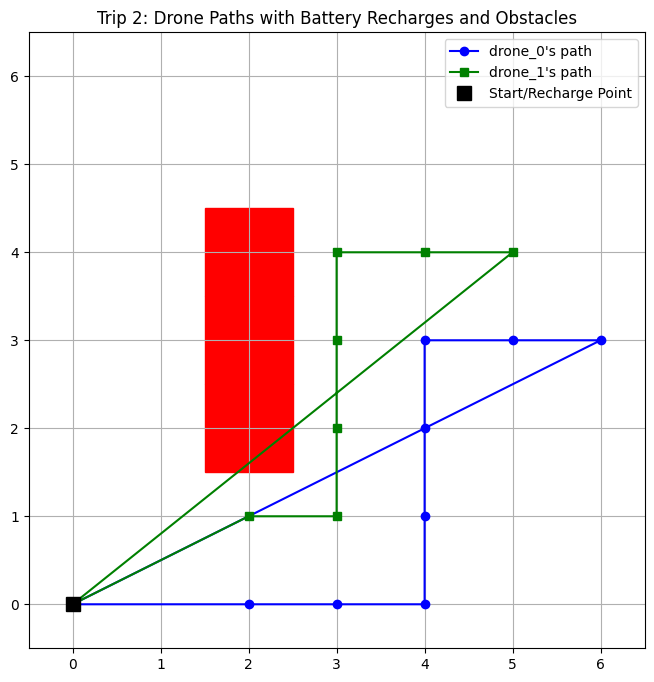

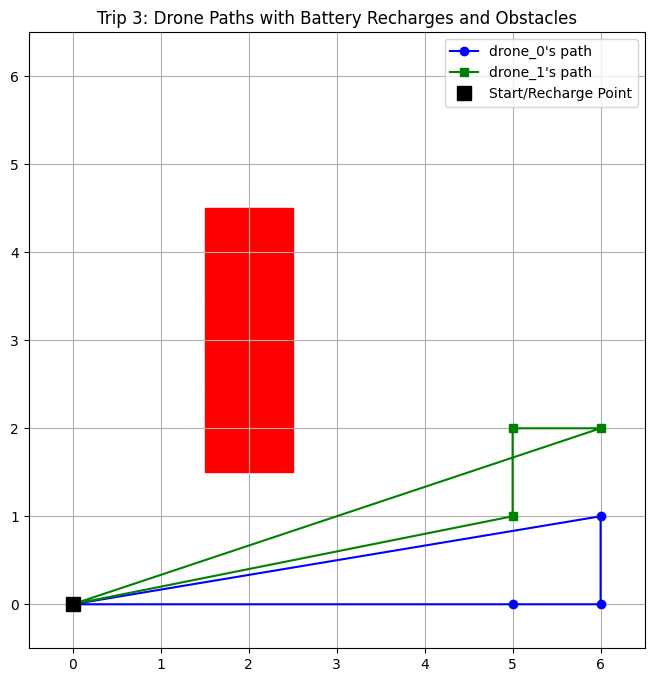

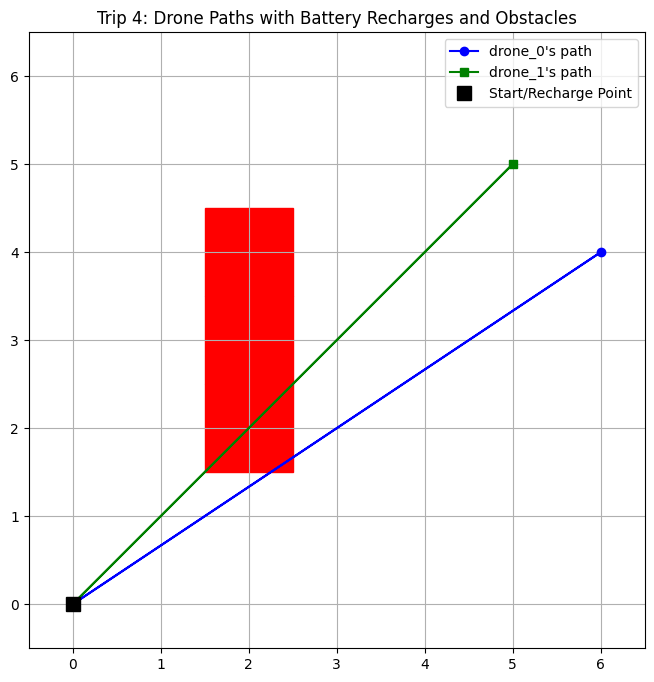

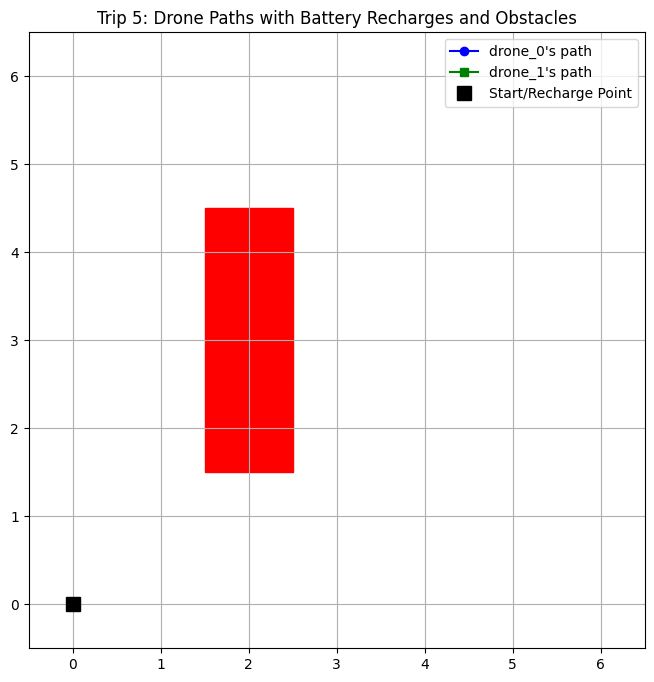

In [64]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 18  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {
    (2, 2), (2, 3), (2, 4),
    # Add more obstacle positions here if needed
}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    """Compute all positions reachable from the start within battery capacity."""
    from collections import deque
    reachable_positions = set()
    queue = deque()
    queue.append((start_position, 0.0))  # Position and distance from start
    while queue:
        current, distance = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            if is_within_bounds(nx, ny) and (nx, ny) not in obstacles:
                new_distance = distance + euclidean_distance(current, (nx, ny))
                return_distance = manhattan_distance((nx, ny), start_position)
                total_distance = new_distance + return_distance
                if total_distance <= BATTERY_CAPACITY:
                    queue.append(((nx, ny), new_distance))
    return reachable_positions

def get_next_position(current_position, visited):
    """Determine the next position using BFS to find the nearest unvisited cell."""
    from collections import deque

    queue = deque()
    queue.append((current_position, [current_position]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position in visited_local:
            continue
        visited_local.add(position)
        if position not in visited and position in reachable_positions:
            move_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            return position, move_distance
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if is_within_bounds(nx, ny) and neighbor not in obstacles and neighbor not in visited_local:
                queue.append((neighbor, path + [neighbor]))
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Compute reachable positions considering battery limitations
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    # Calculate return distance from next_position
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again if there are positions left
                        if len(reachable_positions - visited) > 0:
                            queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                # Check for accessible unvisited positions
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()  # No more positions to visit

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0]-0.5, obstacle[1]-0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'b', 'drone_1': 'g'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name], label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  # Convert seconds to microseconds

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()


### with unvistable


Total execution time: 4186.10 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 0,0
    Distance for drone_0: 15.71 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 0,0
    Distance for drone_1: 15.40 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 3,0 -> 4,0 -> 4,1 -> 4,2 -> 4,3 -> 5,3 -> 6,3 -> 0,0
    Distance for drone_0: 15.71 meters
  drone_1: 0,0 -> 2,1 -> 3,1 -> 3,2 -> 3,3 -> 3,4 -> 4,4 -> 5,4 -> 0,0
    Distance for drone_1: 14.64 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0 -> 5,0 -> 6,0 -> 6,1 -> 0,0
    Distance for drone_0: 13.08 meters
  drone_1: 0,0 -> 5,1 -> 5,2 -> 6,2 -> 0,0
    Distance for drone_1: 13.42 meters
--------------------------------------------------
Trip 4:
  drone_0: 0,0 -> 6,4 -> 0,0
    Distance for drone_0: 14.42 meters
  drone_1: 0,0 -> 5,5 -> 0,0
    Distance for drone_1: 14.14 met

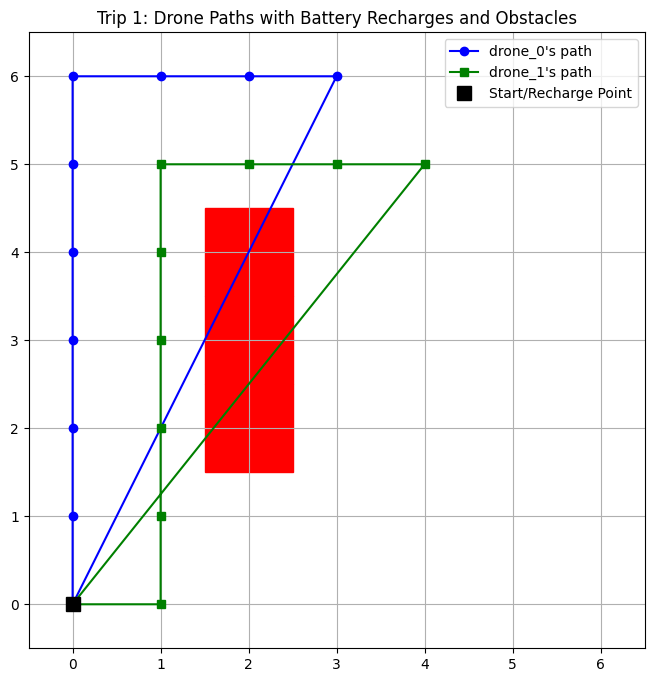

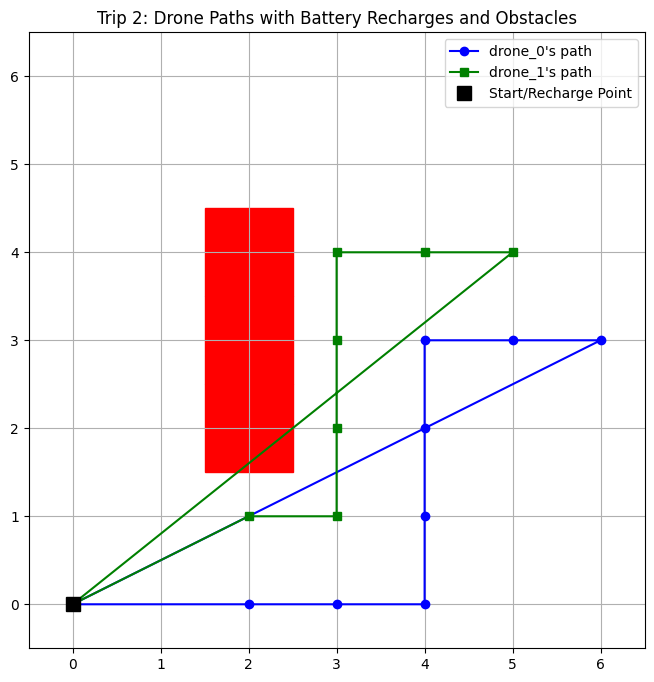

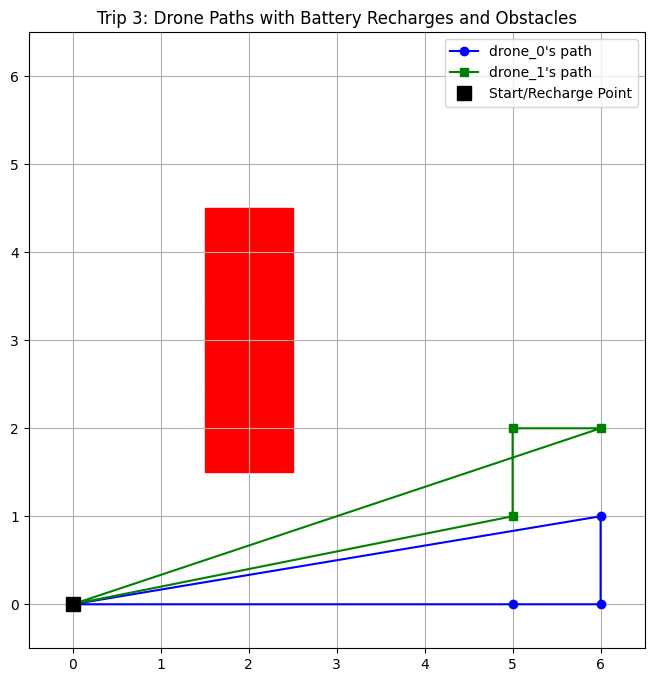

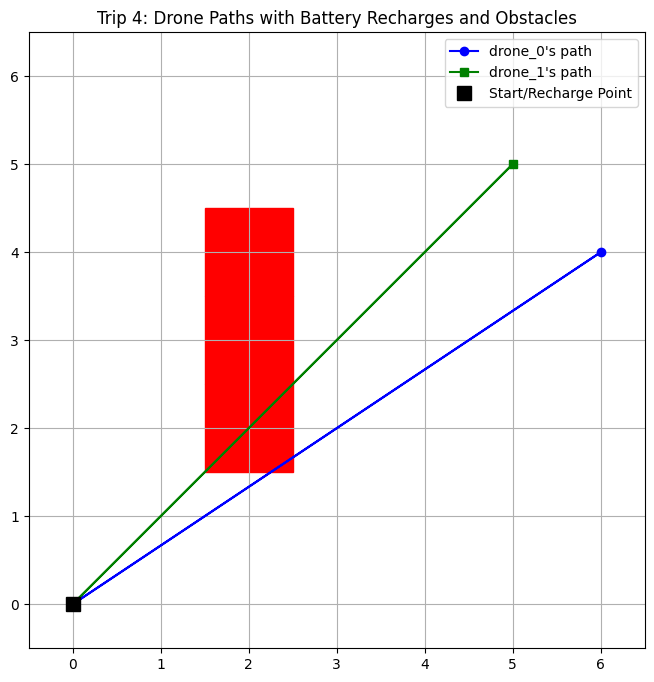

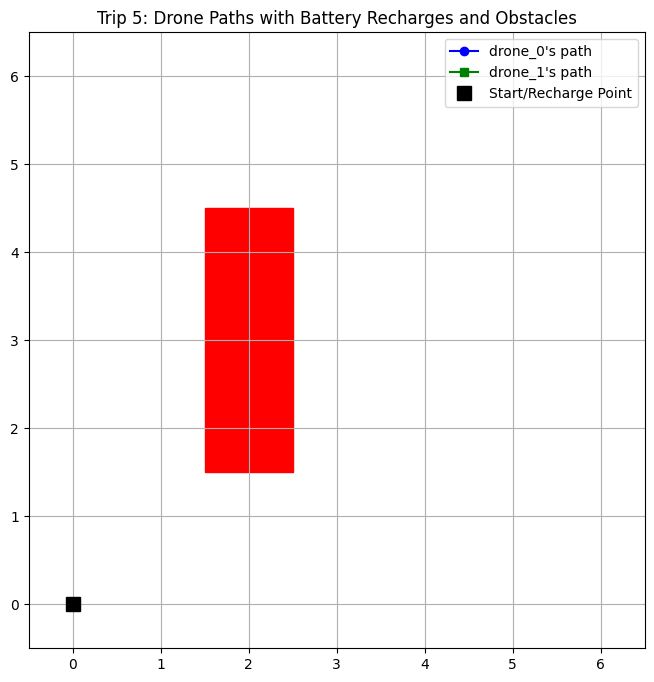

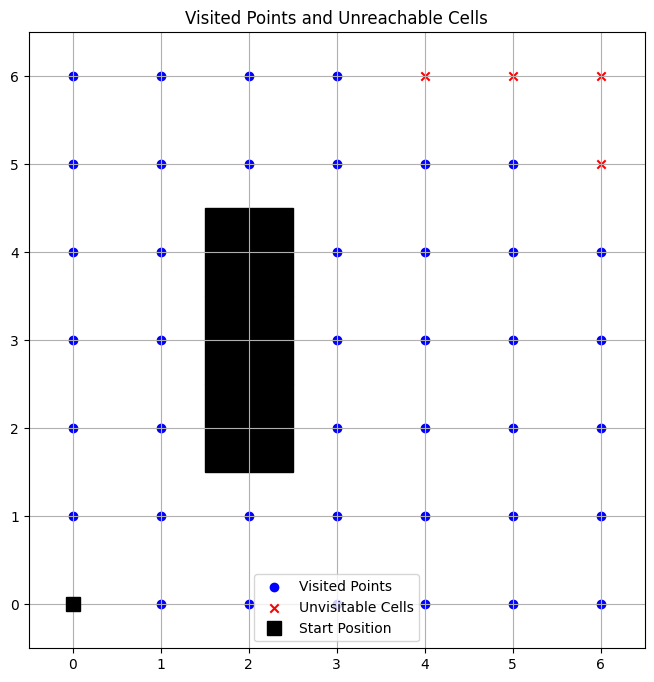

In [72]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 18  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {
    (2, 2), (2, 3), (2, 4),
    # Add more obstacle positions here if needed
}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (1, 1), (1, -1), (-1, -1), (-1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    """Compute all positions reachable from the start within battery capacity."""
    from collections import deque
    reachable_positions = set()
    queue = deque()
    queue.append((start_position, 0.0))  # Position and distance from start
    while queue:
        current, distance = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)
            if is_within_bounds(nx, ny) and neighbor not in obstacles:
                new_distance = distance + euclidean_distance(current, neighbor)
                return_distance = manhattan_distance(neighbor, start_position)
                total_distance = new_distance + return_distance
                if total_distance <= BATTERY_CAPACITY:
                    queue.append((neighbor, new_distance))
    return reachable_positions

def get_unreachable_positions(reachable_positions):
    """Compute all positions that are unreachable due to battery limitations."""
    all_positions = set(
        (x, y)
        for x in range(grid_width)
        for y in range(grid_height)
        if (x, y) not in obstacles
    )
    unreachable_positions = all_positions - reachable_positions
    return unreachable_positions

def get_next_position(current_position, visited):
    """Determine the next position using BFS to find the nearest unvisited cell."""
    from collections import deque

    queue = deque()
    queue.append((current_position, [current_position]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position in visited_local:
            continue
        visited_local.add(position)
        if position not in visited and position in reachable_positions:
            move_distance = sum(
                euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1)
            )
            return position, move_distance
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if (
                is_within_bounds(nx, ny)
                and neighbor not in obstacles
                and neighbor not in visited_local
            ):
                queue.append((neighbor, path + [neighbor]))
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Compute reachable positions considering battery limitations
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    # Compute unreachable positions
    global unreachable_positions
    unreachable_positions = get_unreachable_positions(reachable_positions)

    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    # Calculate return distance from next_position
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again if there are positions left
                        if len(reachable_positions - visited) > 0:
                            queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                # Check for accessible unvisited positions
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()  # No more positions to visit

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'blue', 'drone_1': 'green'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name],
                    label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

def plot_visited_and_unreachable():
    """Plot visited points and unvisitable cells separately at the end."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Visited Points and Unreachable Cells")
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    ax.set_xlim(-0.5, grid_width - 0.5)
    ax.set_ylim(-0.5, grid_height - 0.5)
    ax.set_aspect('equal')

    # Plot obstacles as black squares
    for obstacle in obstacles:
        rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='black')
        ax.add_patch(rect)

    # Plot visited positions as blue dots
    visited_x, visited_y = zip(*visited)
    ax.scatter(visited_x, visited_y, c='blue', marker='o', label='Visited Points')

    # Plot unreachable positions as red crosses
    unvisitable_positions = unreachable_positions - obstacles
    if unvisitable_positions:
        unvisitable_x, unvisitable_y = zip(*unvisitable_positions)
        ax.scatter(unvisitable_x, unvisitable_y, c='red', marker='x', label='Unvisitable Cells')

    # Mark the start position
    ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start Position")

    ax.legend()
    plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()
plot_visited_and_unreachable() 


### Around


Total execution time: 7137.30 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 1,6 -> 2,6 -> 3,6 -> 3,4 -> 3,3 -> 0,0
    Distance for drone_0: 16.24 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 2,5 -> 3,5 -> 4,5 -> 4,4 -> 0,0
    Distance for drone_1: 15.66 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 3,0 -> 4,0 -> 4,1 -> 5,1 -> 5,2 -> 6,2 -> 6,3 -> 0,0
    Distance for drone_0: 15.71 meters
  drone_1: 0,0 -> 2,1 -> 3,1 -> 3,2 -> 4,2 -> 4,3 -> 5,3 -> 5,4 -> 0,0
    Distance for drone_1: 14.64 meters
--------------------------------------------------
Trip 3:
  drone_0: 0,0 -> 5,0 -> 6,1 -> 0,0
    Distance for drone_0: 12.50 meters
  drone_1: 0,0 -> 6,0 -> 0,0
    Distance for drone_1: 12.00 meters
--------------------------------------------------
Trip 4:
  drone_0: 0,0 -> 6,4 -> 0,0
    Distance for drone_0: 14.42 meters
  drone_1: 0,0
    Distance for drone_1: 0.00 meters
-----------

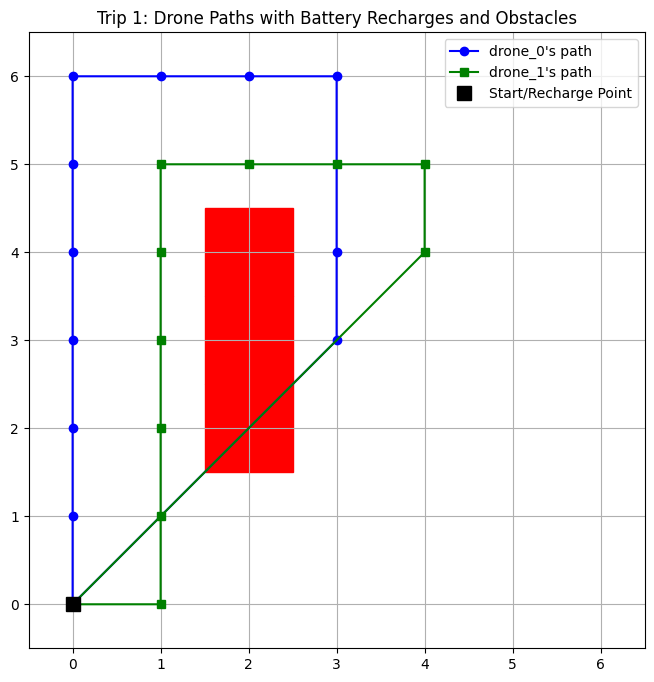

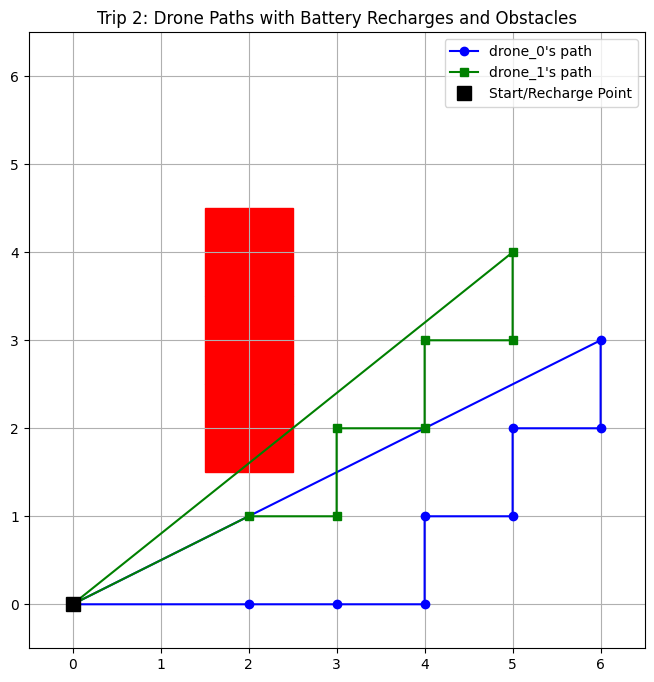

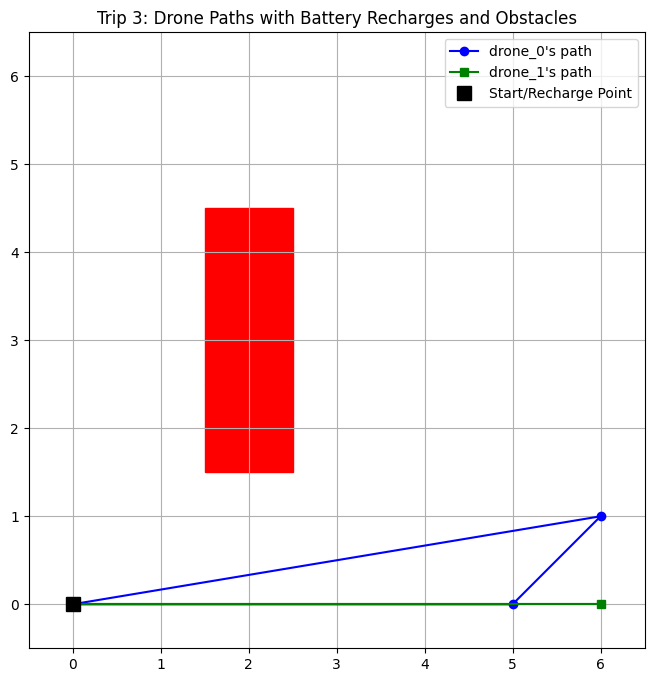

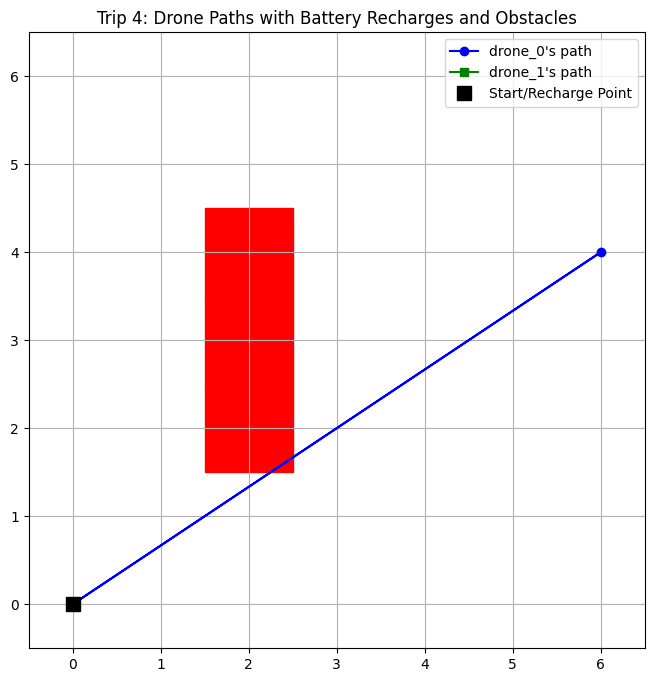

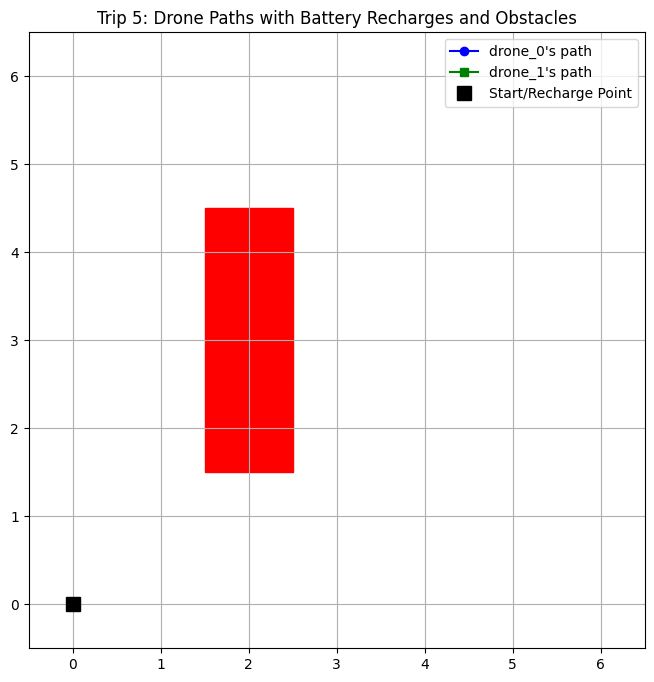

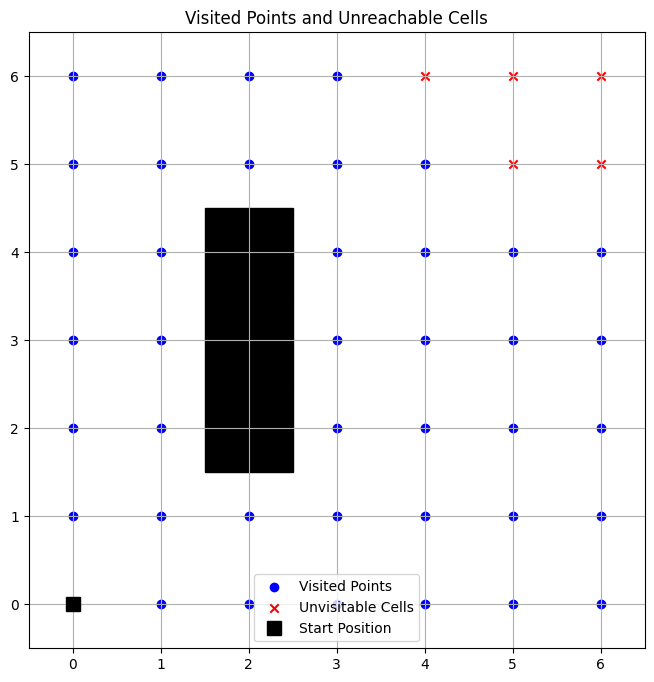

In [74]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time

# Parameters
grid_width = 7
grid_height = 7
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 18  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {
    (2, 2), (2, 3), (2, 4),
    # Add more obstacle positions here if needed
}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    """Compute all positions reachable from the start within battery capacity."""
    from collections import deque
    reachable_positions = set()
    queue = deque()
    queue.append((start_position, 0.0))  # Position and distance from start
    while queue:
        current, distance = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (current[0] + dx, current[1])
                neighbor2 = (current[0], current[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            new_distance = distance + euclidean_distance(current, neighbor)
            return_distance = manhattan_distance(neighbor, start_position)
            total_distance = new_distance + return_distance
            if total_distance <= BATTERY_CAPACITY:
                queue.append((neighbor, new_distance))
    return reachable_positions

def get_unreachable_positions(reachable_positions):
    """Compute all positions that are unreachable due to battery limitations."""
    all_positions = set(
        (x, y)
        for x in range(grid_width)
        for y in range(grid_height)
        if (x, y) not in obstacles
    )
    unreachable_positions = all_positions - reachable_positions
    return unreachable_positions

def get_next_position(current_position, visited):
    """Determine the next position using BFS to find the nearest unvisited cell."""
    from collections import deque

    queue = deque()
    queue.append((current_position, [current_position]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position in visited_local:
            continue
        visited_local.add(position)
        if position not in visited and position in reachable_positions:
            move_distance = sum(
                euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1)
            )
            return position, move_distance
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles or neighbor in visited_local:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (position[0] + dx, position[1])
                neighbor2 = (position[0], position[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            queue.append((neighbor, path + [neighbor]))
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Compute reachable positions considering battery limitations
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    # Compute unreachable positions
    global unreachable_positions
    unreachable_positions = get_unreachable_positions(reachable_positions)

    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    # Calculate return distance from next_position
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again if there are positions left
                        if len(reachable_positions - visited) > 0:
                            queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                # Check for accessible unvisited positions
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()  # No more positions to visit

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'blue', 'drone_1': 'green'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name],
                    label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

def plot_visited_and_unreachable():
    """Plot visited points and unvisitable cells separately at the end."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Visited Points and Unreachable Cells")
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    ax.set_xlim(-0.5, grid_width - 0.5)
    ax.set_ylim(-0.5, grid_height - 0.5)
    ax.set_aspect('equal')

    # Plot obstacles as black squares
    for obstacle in obstacles:
        rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='black')
        ax.add_patch(rect)

    # Plot visited positions as blue dots
    visited_x, visited_y = zip(*visited)
    ax.scatter(visited_x, visited_y, c='blue', marker='o', label='Visited Points')

    # Plot unreachable positions as red crosses
    unvisitable_positions = unreachable_positions - obstacles
    if unvisitable_positions:
        unvisitable_x, unvisitable_y = zip(*unvisitable_positions)
        ax.scatter(unvisitable_x, unvisitable_y, c='red', marker='x', label='Unvisitable Cells')

    # Mark the start position
    ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start Position")

    ax.legend()
    plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  # Convert seconds to microseconds

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()
plot_visited_and_unreachable()  # Plot at the end with visited points and unvisitable cells


### with return around


Total execution time: 198007.00 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 0,7 -> 0,8 -> 0,9 -> 0,10 -> 0,11 -> 0,12 -> 0,13 -> 0,14 -> 0,15 -> 0,16 -> 0,17 -> 0,18 -> 0,19 -> 1,19 -> 2,19 -> 3,19 -> 4,19 -> 5,19 -> 6,19 -> 0,0
    Distance for drone_0: 44.92 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 1,6 -> 1,7 -> 1,8 -> 1,9 -> 1,10 -> 1,11 -> 1,12 -> 1,13 -> 1,14 -> 1,15 -> 1,16 -> 1,17 -> 1,18 -> 2,18 -> 3,18 -> 4,18 -> 5,18 -> 6,18 -> 7,18 -> 0,0
    Distance for drone_1: 44.31 meters
--------------------------------------------------
Trip 2:
  drone_0: 0,0 -> 2,0 -> 3,0 -> 4,0 -> 4,1 -> 4,2 -> 4,3 -> 4,4 -> 4,5 -> 4,6 -> 3,6 -> 3,7 -> 3,8 -> 3,9 -> 3,10 -> 3,11 -> 3,12 -> 3,13 -> 3,14 -> 3,15 -> 3,16 -> 4,16 -> 5,16 -> 6,16 -> 7,16 -> 8,16 -> 0,0
    Distance for drone_0: 43.89 meters
  drone_1: 0,0 -> 2,1 -> 3,1 -> 3,2 -> 3,3 -> 3,4 -> 3,5 -> 2,5 -> 2,6 -> 2,7 -> 2,8 -> 2,9 -> 2,10 -> 2,11 -> 2,12 -> 2,13 -> 2,14 -> 2

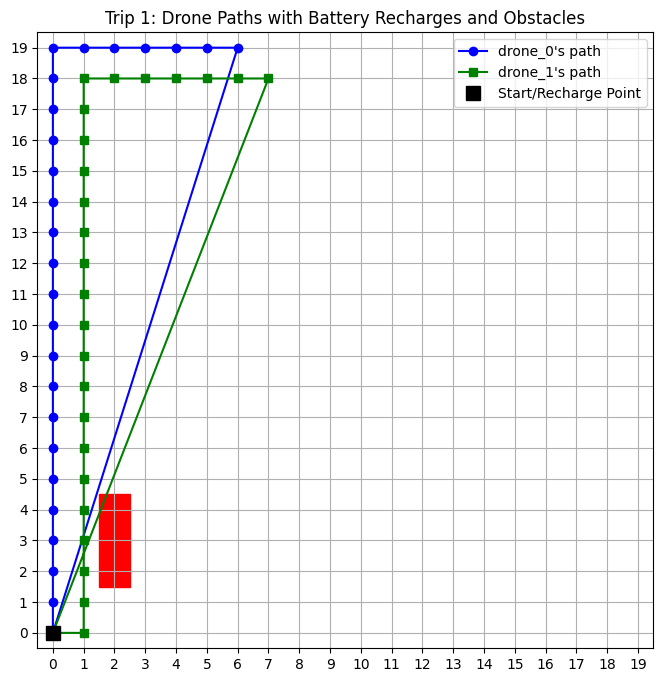

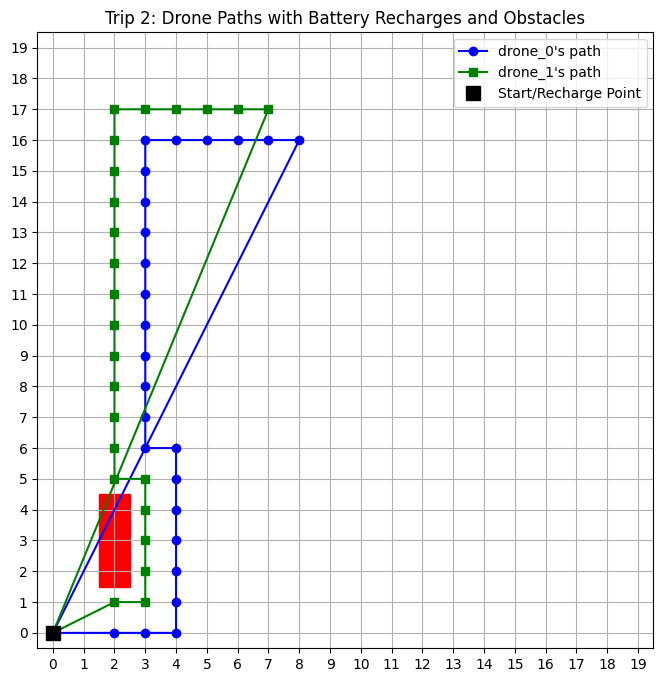

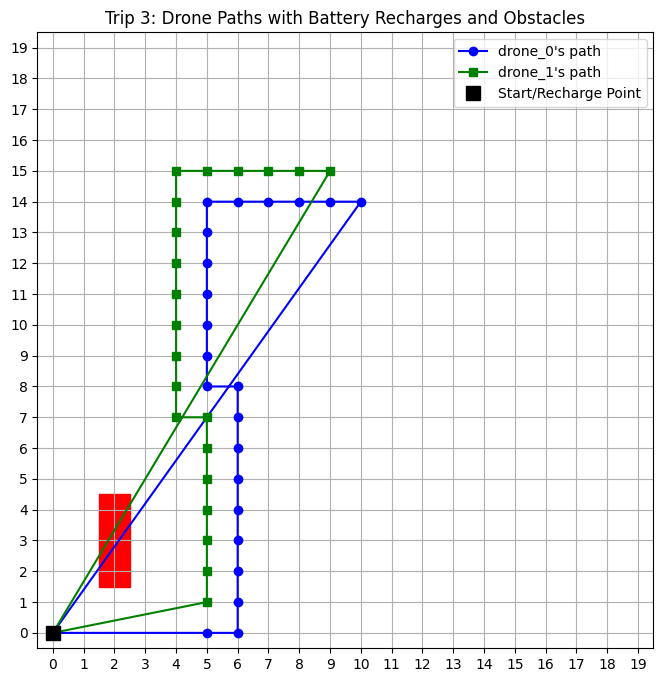

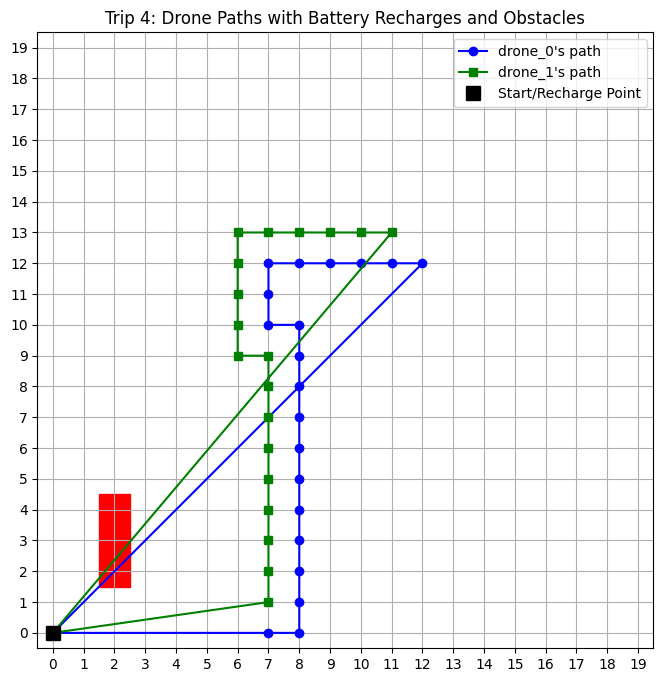

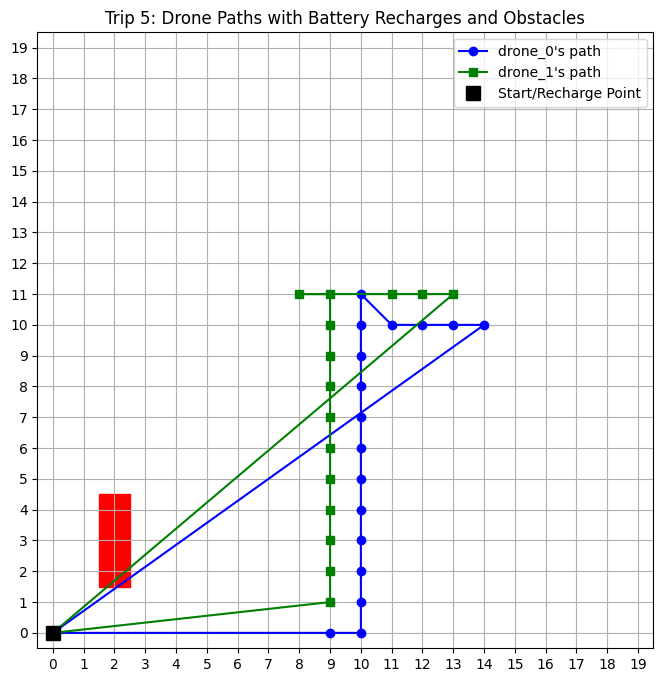

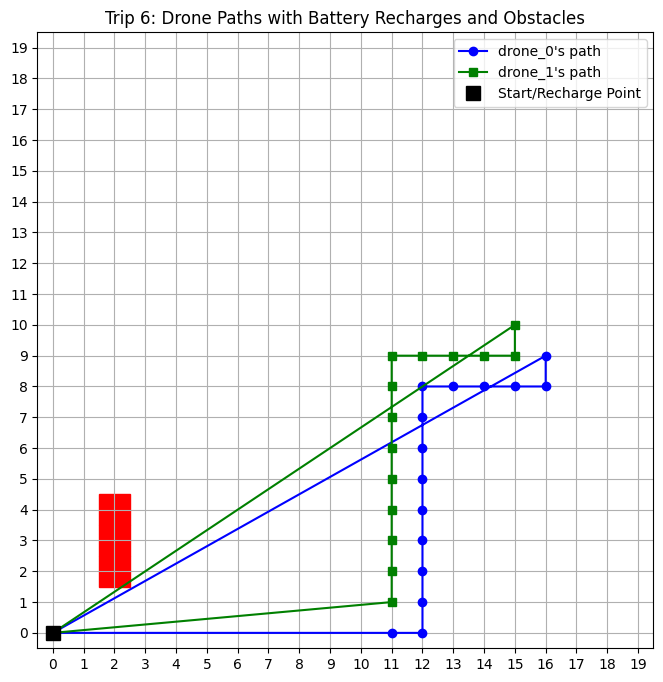

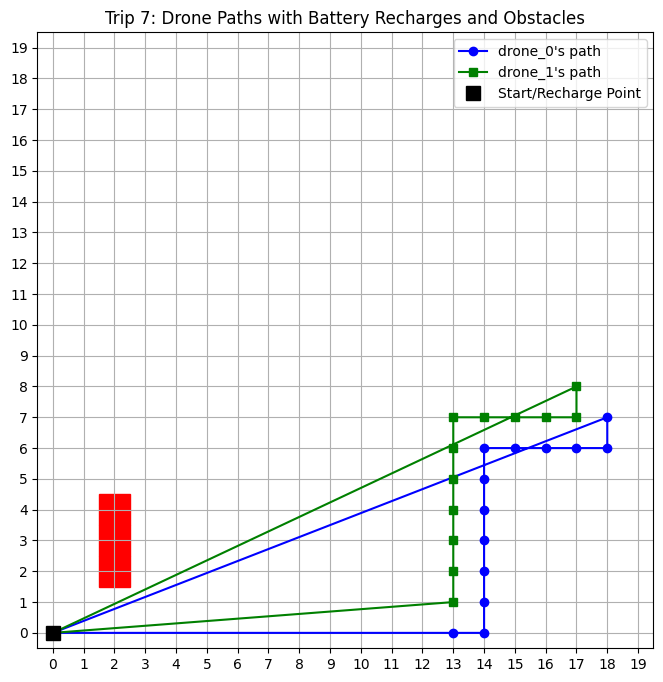

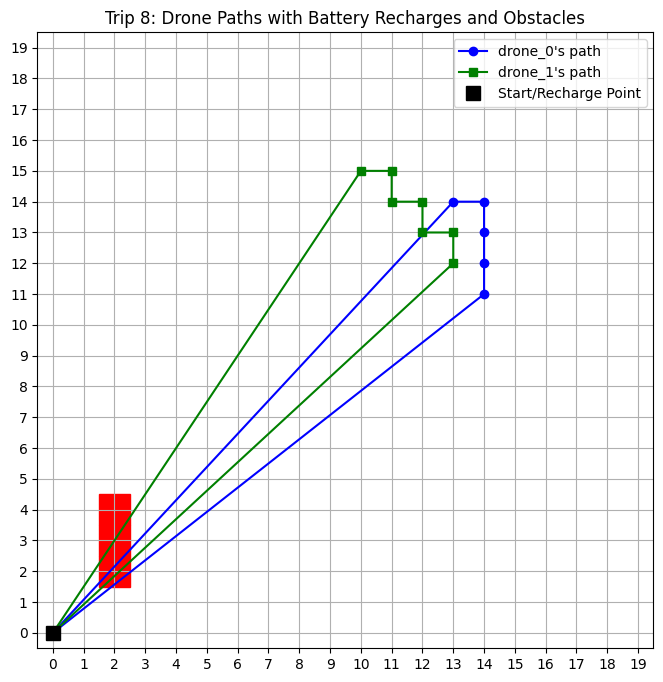

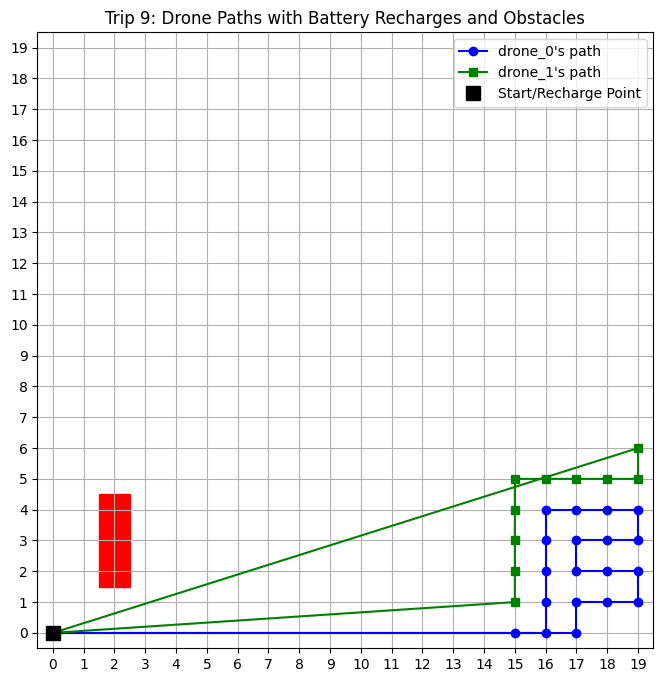

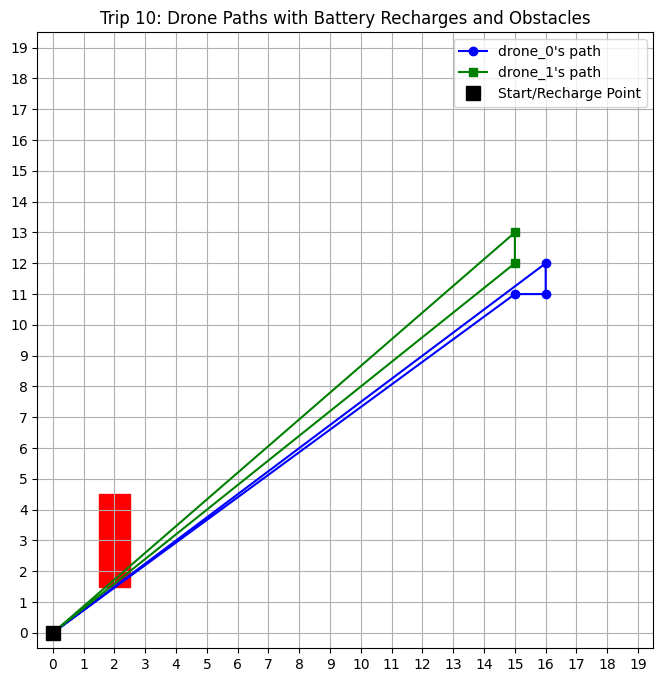

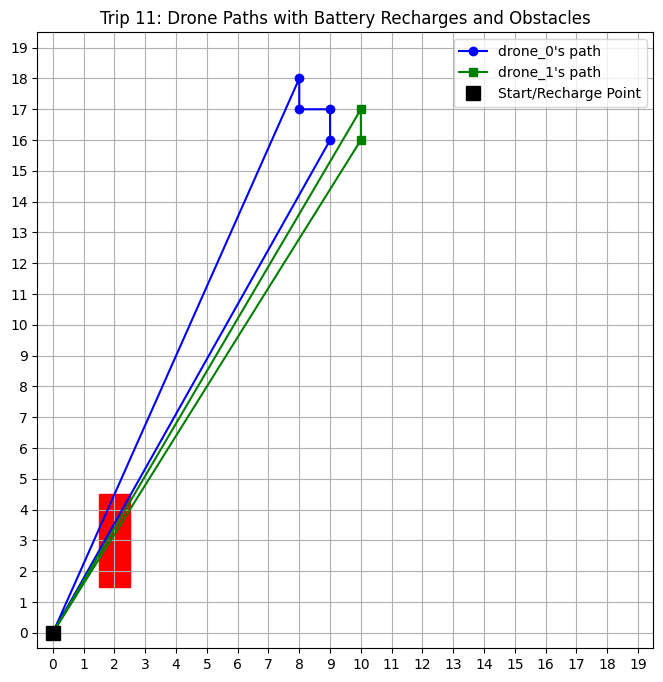

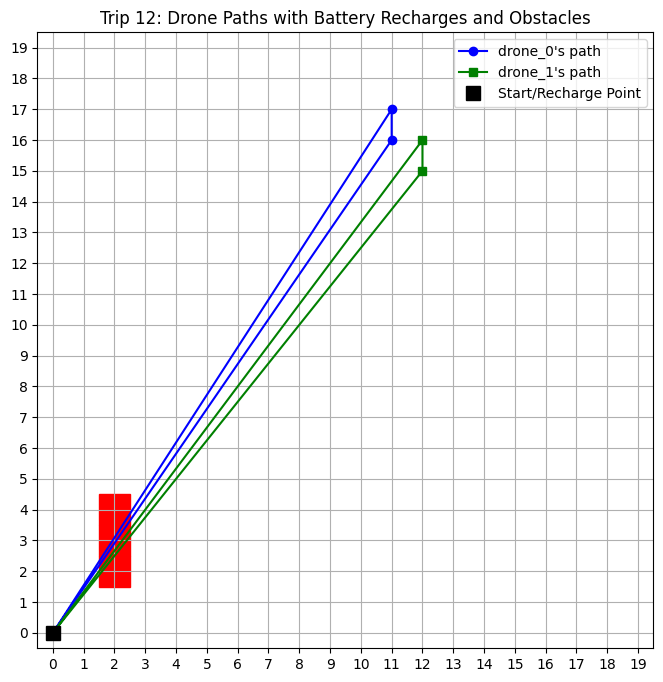

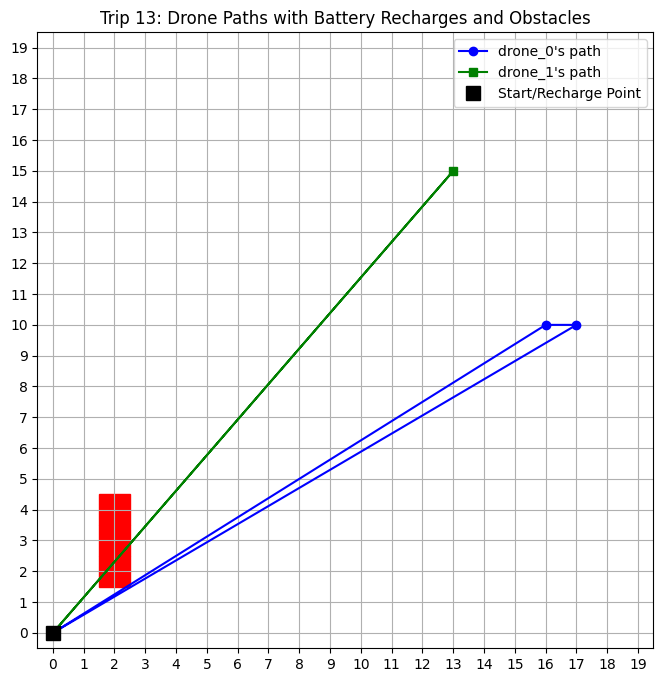

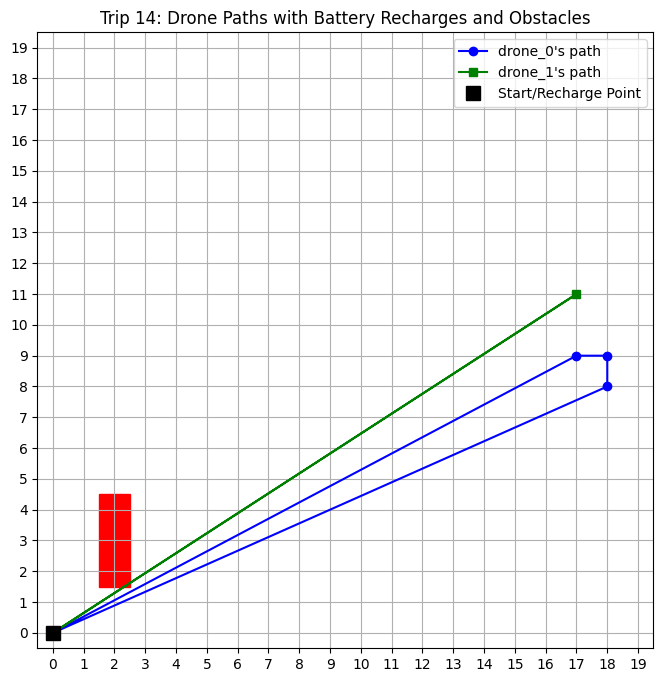

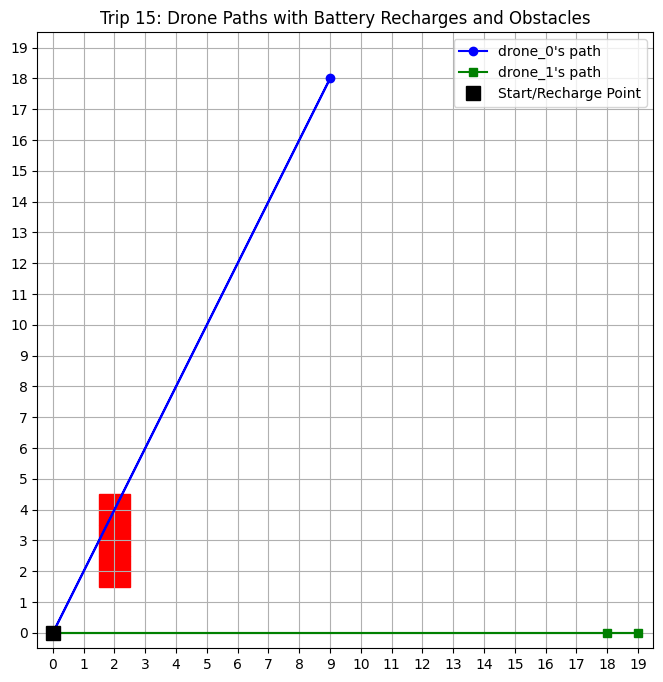

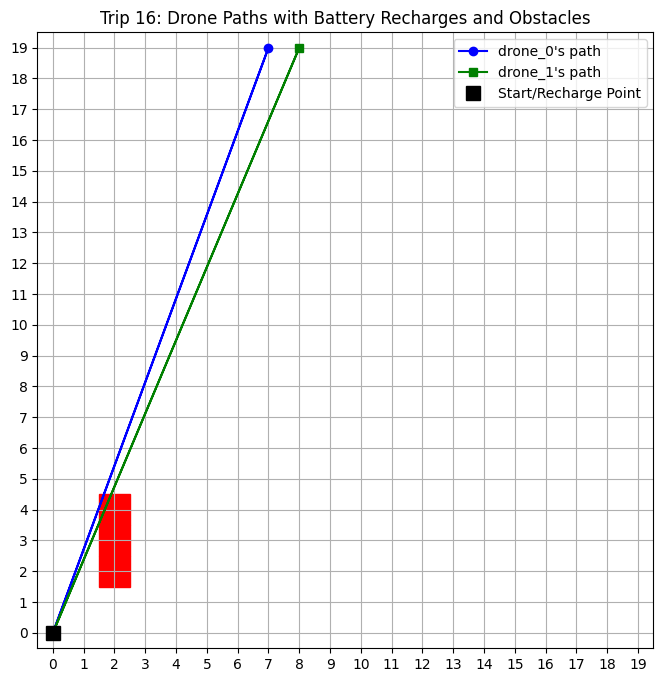

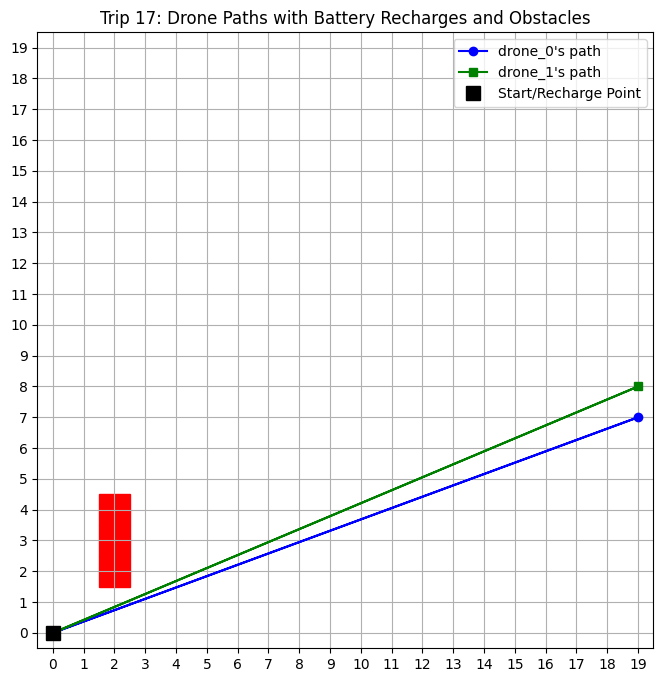

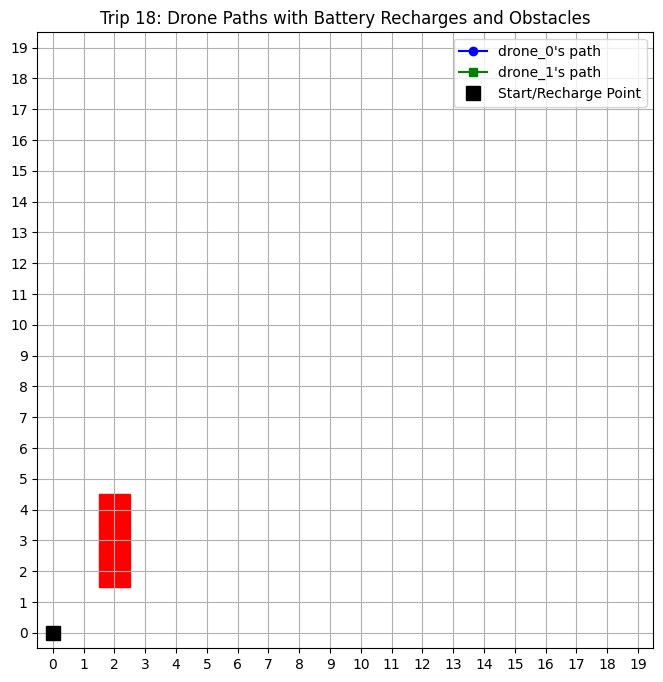

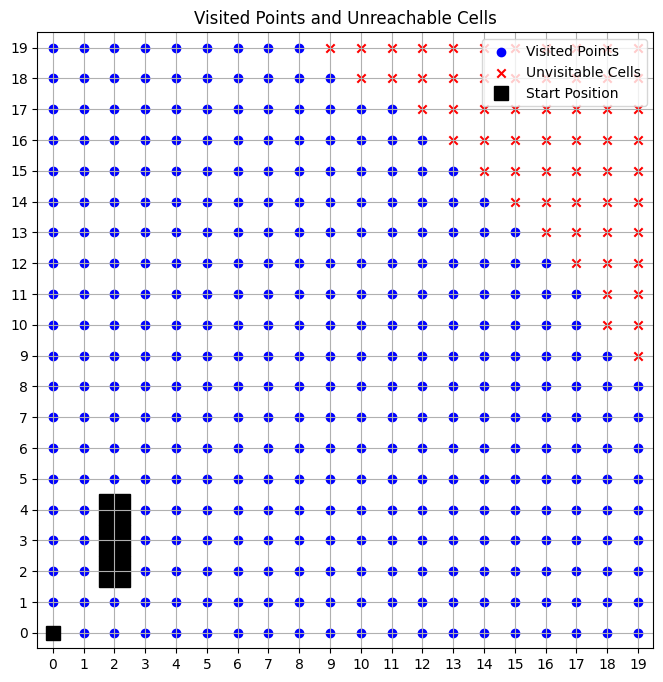

In [2]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time

# Parameters
grid_width = 20
grid_height = 20
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 50  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {
    (2, 2), (2, 3), (2, 4),
    # Add more obstacle positions here if needed
}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    """Compute all positions reachable from the start within battery capacity."""
    from collections import deque
    reachable_positions = set()
    queue = deque()
    queue.append((start_position, 0.0))  # Position and distance from start
    while queue:
        current, distance = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (current[0] + dx, current[1])
                neighbor2 = (current[0], current[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            new_distance = distance + euclidean_distance(current, neighbor)
            return_distance = manhattan_distance(neighbor, start_position)
            total_distance = new_distance + return_distance
            if total_distance <= BATTERY_CAPACITY:
                queue.append((neighbor, new_distance))
    return reachable_positions

def get_unreachable_positions(reachable_positions):
    """Compute all positions that are unreachable due to battery limitations."""
    all_positions = set(
        (x, y)
        for x in range(grid_width)
        for y in range(grid_height)
        if (x, y) not in obstacles
    )
    unreachable_positions = all_positions - reachable_positions
    return unreachable_positions

def get_next_position(current_position, visited):
    """Determine the next position using BFS to find the nearest unvisited cell."""
    from collections import deque

    queue = deque()
    queue.append((current_position, [current_position]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position in visited_local:
            continue
        visited_local.add(position)
        if position not in visited and position in reachable_positions:
            move_distance = sum(
                euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1)
            )
            return position, move_distance
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles or neighbor in visited_local:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (position[0] + dx, position[1])
                neighbor2 = (position[0], position[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            queue.append((neighbor, path + [neighbor]))
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Compute reachable positions considering battery limitations
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    # Compute unreachable positions
    global unreachable_positions
    unreachable_positions = get_unreachable_positions(reachable_positions)

    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    # Calculate return distance from next_position
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again if there are positions left
                        if len(reachable_positions - visited) > 0:
                            queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                # Check for accessible unvisited positions
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()  # No more positions to visit

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position."""
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    return_distance = manhattan_distance(current_position, start_position)
    if return_distance <= remaining_battery:
        # Return to start
        drone_distances[drone_name] += return_distance
        current_trip_battery[drone_name] += return_distance
        if current_position != start_position:
            current_trip_paths[drone_name].append(start_position)
    else:
        # Can't return to start
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'blue', 'drone_1': 'green'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name],
                    label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

def plot_visited_and_unreachable():
    """Plot visited points and unvisitable cells separately at the end."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Visited Points and Unreachable Cells")
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    ax.set_xlim(-0.5, grid_width - 0.5)
    ax.set_ylim(-0.5, grid_height - 0.5)
    ax.set_aspect('equal')

    # Plot obstacles as black squares
    for obstacle in obstacles:
        rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='black')
        ax.add_patch(rect)

    # Plot visited positions as blue dots
    visited_x, visited_y = zip(*visited)
    ax.scatter(visited_x, visited_y, c='blue', marker='o', label='Visited Points')

    # Plot unreachable positions as red crosses
    unvisitable_positions = unreachable_positions - obstacles
    if unvisitable_positions:
        unvisitable_x, unvisitable_y = zip(*unvisitable_positions)
        ax.scatter(unvisitable_x, unvisitable_y, c='red', marker='x', label='Unvisitable Cells')

    # Mark the start position
    ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start Position")

    ax.legend()
    plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  # Convert seconds to microseconds

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()
plot_visited_and_unreachable()  # Plot at the end with visited points and unvisitable cells



### fial


Total execution time: 43365.00 microseconds
Trip 1:
  drone_0: 0,0 -> 0,1 -> 0,2 -> 0,3 -> 0,4 -> 0,5 -> 0,6 -> 0,7 -> 0,8 -> 0,9 -> 0,10 -> 0,11 -> 0,12 -> 0,13 -> 0,14 -> 0,15 -> 0,16 -> 0,17 -> 0,18 -> 0,19 -> 1,19 -> 2,19 -> 3,19 -> 4,19 -> 5,19 -> 6,19 -> 7,19 -> 8,19 -> 9,19 -> 10,19 -> 11,19 -> 12,19 -> 13,19 -> 14,19 -> 15,19 -> 16,19 -> 17,19 -> 18,19 -> 19,19 -> 18,17 -> 17,17 -> 16,17 -> 15,17 -> 14,17 -> 13,17 -> 12,17 -> 11,17 -> 10,17 -> 9,17 -> 8,17 -> 7,17 -> 6,17 -> 5,17 -> 4,17 -> 3,17 -> 2,17 -> 2,16 -> 2,15 -> 2,14 -> 3,14 -> 4,14 -> 4,13 -> 4,12 -> 4,11 -> 4,10 -> 4,9 -> 4,8 -> 3,7 -> 2,6 -> 1,5 -> 1,4 -> 1,3 -> 1,2 -> 1,1 -> 0,0
    Distance for drone_0: 76.89 meters
  drone_1: 0,0 -> 1,0 -> 1,1 -> 1,2 -> 1,3 -> 1,4 -> 1,5 -> 1,6 -> 1,7 -> 1,8 -> 1,9 -> 1,10 -> 1,11 -> 1,12 -> 1,13 -> 1,14 -> 1,15 -> 1,16 -> 1,17 -> 1,18 -> 2,18 -> 3,18 -> 4,18 -> 5,18 -> 6,18 -> 7,18 -> 8,18 -> 9,18 -> 10,18 -> 11,18 -> 12,18 -> 13,18 -> 14,18 -> 15,18 -> 16,18 -> 17,18 -> 18,18

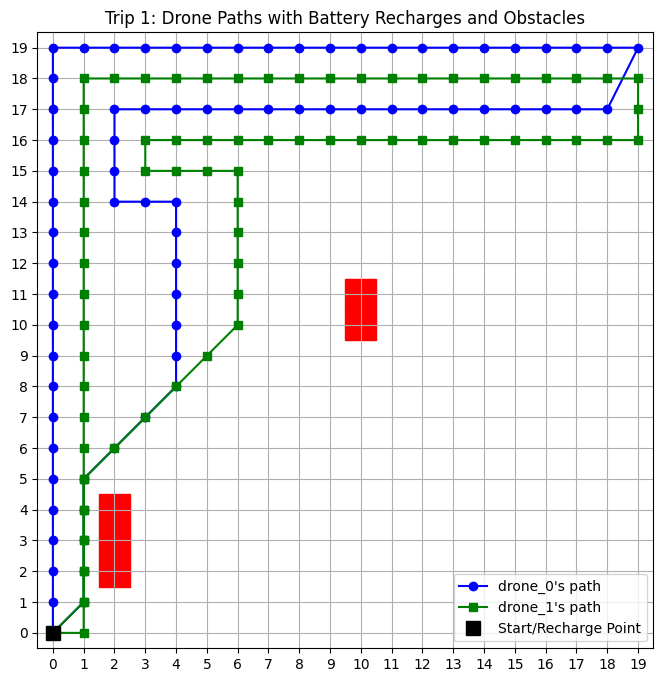

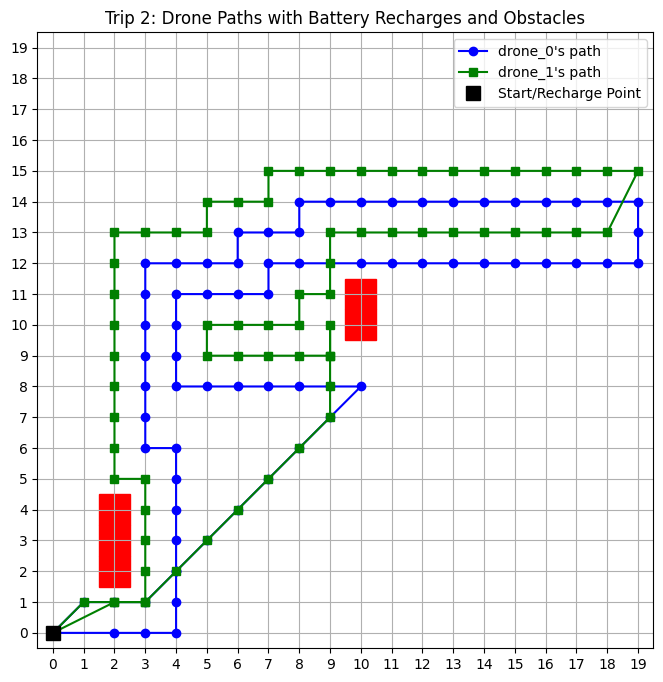

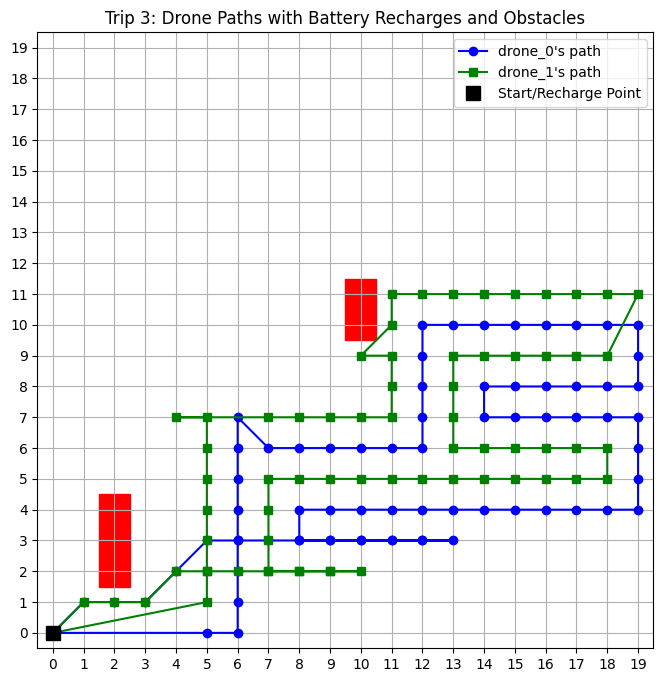

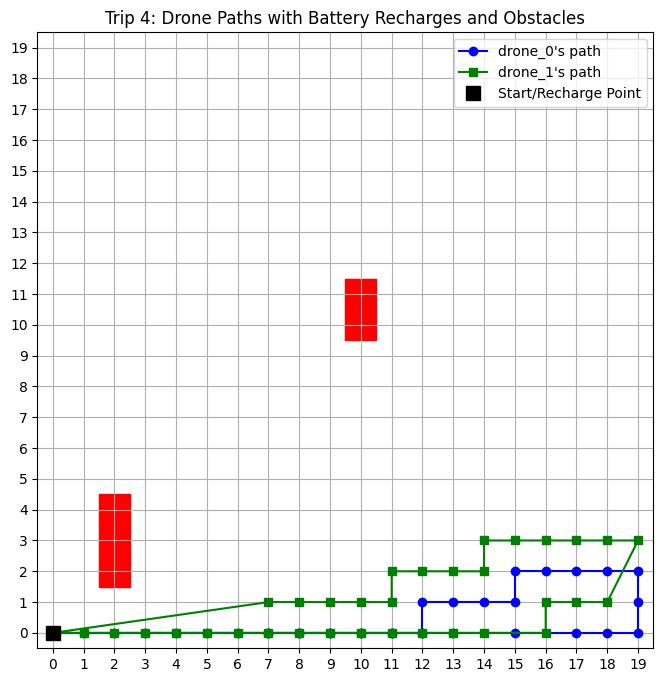

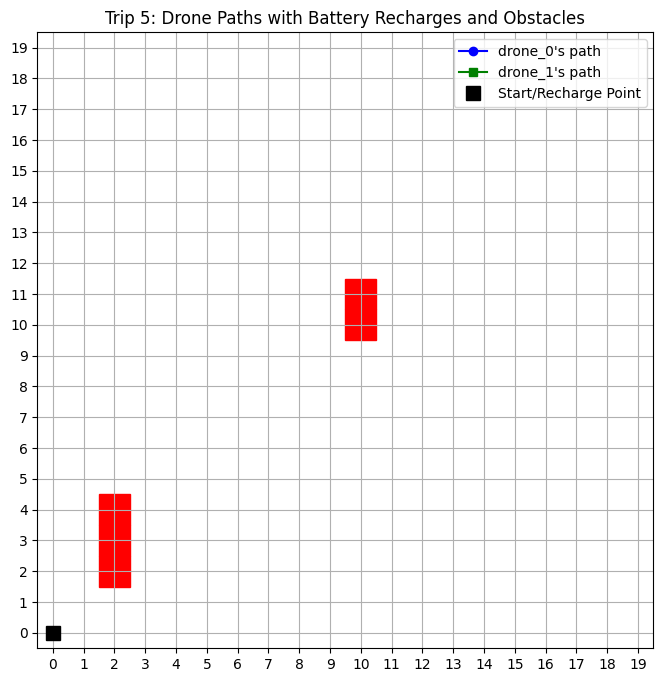

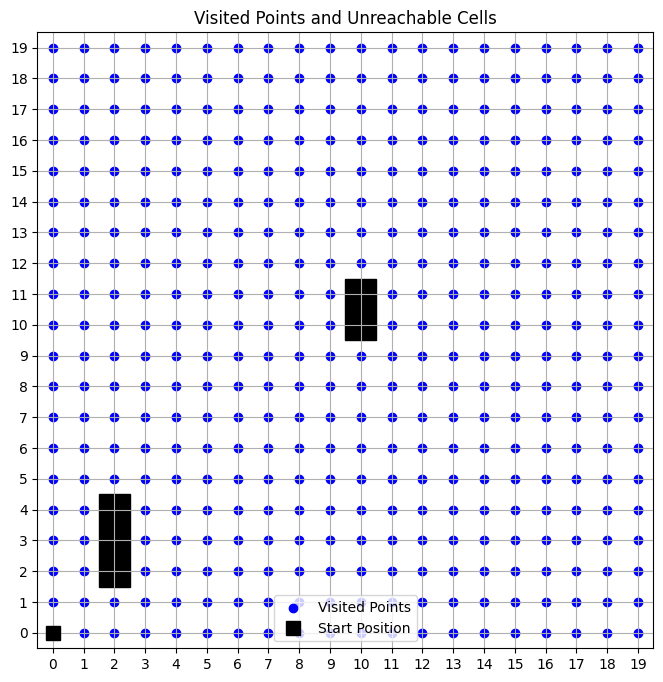

In [1]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time

# Parameters
grid_width = 20
grid_height = 20
start_position = (0, 0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([start_position])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

# Battery capacity (maximum distance on a single charge)
BATTERY_CAPACITY = 80  # Adjust this value as needed

# Obstacles (walls) defined as a set of grid positions
obstacles = {
    (2, 2), (2, 3), (2, 4), (10,10), (10,11)
    # Add more obstacle positions here if needed
}

# Movement directions: up, right, down, left, and diagonals
directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),  # Adjacent directions
    (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonal directions
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two points."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    """Compute all positions reachable from the start within battery capacity."""
    from collections import deque
    reachable_positions = set()
    queue = deque()
    queue.append((start_position, 0.0))  # Position and distance from start
    while queue:
        current, distance = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (current[0] + dx, current[1])
                neighbor2 = (current[0], current[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            new_distance = distance + euclidean_distance(current, neighbor)
            return_distance = manhattan_distance(neighbor, start_position)
            total_distance = new_distance + return_distance
            if total_distance <= BATTERY_CAPACITY:
                queue.append((neighbor, new_distance))
    return reachable_positions

def get_unreachable_positions(reachable_positions):
    """Compute all positions that are unreachable due to battery limitations."""
    all_positions = set(
        (x, y)
        for x in range(grid_width)
        for y in range(grid_height)
        if (x, y) not in obstacles
    )
    unreachable_positions = all_positions - reachable_positions
    return unreachable_positions

def get_next_position(current_position, visited):
    """Determine the next position using BFS to find the nearest unvisited cell."""
    from collections import deque

    queue = deque()
    queue.append((current_position, [current_position]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position in visited_local:
            continue
        visited_local.add(position)
        if position not in visited and position in reachable_positions:
            move_distance = sum(
                euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1)
            )
            return position, move_distance
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles or neighbor in visited_local:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (position[0] + dx, position[1])
                neighbor2 = (position[0], position[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            queue.append((neighbor, path + [neighbor]))
    return None, 0  # No accessible cell found

# New data structure to keep track of trips
trips = []

def simulate_drones():
    """Simulate the movement of both drones and account for move distances."""
    # Compute reachable positions considering battery limitations
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    # Compute unreachable positions
    global unreachable_positions
    unreachable_positions = get_unreachable_positions(reachable_positions)

    # Initialize current trip paths for both drones
    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance = get_next_position(current_position, visited)
                if next_position:
                    # Before proceeding, check if we have enough battery
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    # Calculate return distance from next_position
                    return_distance = manhattan_distance(next_position, start_position)
                    required_battery = move_distance + return_distance
                    if required_battery <= remaining_battery:
                        # Proceed to next position
                        queue.append(next_position)
                        drone_distances[drone_name] += move_distance
                        current_trip_battery[drone_name] += move_distance
                        current_trip_paths[drone_name].append(next_position)
                        visited.add(next_position)
                    else:
                        # Not enough battery to proceed, need to return to start
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        # Start from start_position again if there are positions left
                        if len(reachable_positions - visited) > 0:
                            queue.append(start_position)
                else:
                    # No accessible cell found, need to return to start
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        # Check if all drones are back at start position to record a trip
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            # Record the current trip
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            # Reset current trip paths and battery consumption
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                # Check for accessible unvisited positions
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()  # No more positions to visit

    # After the loop, ensure drones are at start position and record the last trip
    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    """Handles returning the drone to the start position avoiding obstacles."""
    # Find path back to start avoiding obstacles
    path = find_path(current_position, start_position)
    if path is None:
        print(f"{drone_name} cannot return to start from position {current_position}. No path found.")
        return

    move_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    if move_distance <= remaining_battery:
        # Update path and battery consumption
        current_trip_paths[drone_name].extend(path[1:])  # Exclude current_position as it's already in path
        current_trip_battery[drone_name] += move_distance
        drone_distances[drone_name] += move_distance
    else:
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def find_path(start, goal):
    """Find the shortest path from start to goal avoiding obstacles."""
    from collections import deque

    queue = deque()
    queue.append((start, [start]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position == goal:
            return path
        if position in visited_local:
            continue
        visited_local.add(position)
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles:
                continue

            # Diagonal movement collision detection
            if dx != 0 and dy != 0:
                neighbor1 = (position[0] + dx, position[1])
                neighbor2 = (position[0], position[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue  # Can't move diagonally if adjacent cells are blocked

            if neighbor not in visited_local:
                queue.append((neighbor, path + [neighbor]))
    return None  # No path found

def print_drone_routes_and_distances():
    """Prints each drone's route and the distance covered."""
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            # Calculate distance for this trip
            trip_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    # Print total distances
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    """Plot each trip separately, showing paths of both drones and obstacles."""
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        # Plot obstacles as red squares
        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='red')
            ax.add_patch(rect)

        # Colors and markers for plotting
        drone_colors = {'drone_0': 'blue', 'drone_1': 'green'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name],
                    label=f"{drone_name}'s path")

        # Mark the start position
        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

def plot_visited_and_unreachable():
    """Plot visited points and unvisitable cells separately at the end."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Visited Points and Unreachable Cells")
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    ax.set_xlim(-0.5, grid_width - 0.5)
    ax.set_ylim(-0.5, grid_height - 0.5)
    ax.set_aspect('equal')

    # Plot obstacles as black squares
    for obstacle in obstacles:
        rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='black')
        ax.add_patch(rect)

    # Plot visited positions as blue dots
    visited_x, visited_y = zip(*visited)
    ax.scatter(visited_x, visited_y, c='blue', marker='o', label='Visited Points')

    # Plot unreachable positions as red crosses
    unvisitable_positions = unreachable_positions - obstacles
    if unvisitable_positions:
        unvisitable_x, unvisitable_y = zip(*unvisitable_positions)
        ax.scatter(unvisitable_x, unvisitable_y, c='red', marker='x', label='Unvisitable Cells')

    # Mark the start position
    ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start Position")

    ax.legend()
    plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000  

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()
plot_visited_and_unreachable()  # Plot at the end with visited points and unvisitable cells


### another

In [3]:
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import time


grid_width = 20
grid_height = 20
start_position = (0,0)
visited = set([start_position])
drones = {"drone_0": deque([start_position]), "drone_1": deque([(0, 0)])}
drone_paths = defaultdict(list, {"drone_0": [start_position], "drone_1": [start_position]})
drone_distances = {"drone_0": 0.0, "drone_1": 0.0}
drone_battery_consumed = {"drone_0": 0.0, "drone_1": 0.0}

BATTERY_CAPACITY = 80  


obstacles = {
    (2, 2), (2, 3), (2, 4),
    (6,6), (6,7), (5,7)
}


directions = [
    (-1, 0), (0, 1), (1, 0), (0, -1),
    (-1, -1), (-1, 1), (1, -1), (1, 1)
]

def is_within_bounds(x, y):
    """Check if the position is within the grid bounds."""
    return 0 <= x < grid_width and 0 <= y < grid_height

def euclidean_distance(pos1, pos2):
    
    x1, y1 = pos1
    x2, y2 = pos2
    return math.hypot(x2 - x1, y2 - y1)

def manhattan_distance(pos1, pos2):
    
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)

def compute_reachable_positions():
    
    reachable_positions = set()
    queue = deque()
    queue.append((start_position, 0.0))
    while queue:
        current, distance = queue.popleft()
        if current in reachable_positions:
            continue
        reachable_positions.add(current)
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles:
                continue

            if dx != 0 and dy != 0:
                neighbor1 = (current[0] + dx, current[1])
                neighbor2 = (current[0], current[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue

            new_distance = distance + 0(current, neighbor)
            return_distance = manhattan_distance(neighbor, start_position)
            total_distance = new_distance + return_distance
            if total_distance <= BATTERY_CAPACITY:
                queue.append((neighbor, new_distance))
    return reachable_positions

def get_unreachable_positions(reachable_positions):
    
    all_positions = set(
        (x, y)
        for x in range(grid_width)
        for y in range(grid_height)
        if (x, y) not in obstacles
    )
    unreachable_positions = all_positions - reachable_positions
    return unreachable_positions

def get_next_position(current_position, visited):
    
    queue = deque()
    queue.append((current_position, [current_position]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position in visited_local:
            continue
        visited_local.add(position)
        if position not in visited and position in reachable_positions:
            move_distance = sum(
                euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1)
            )
            return position, move_distance, path
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles or neighbor in visited_local:
                continue

            if dx != 0 and dy != 0:
                neighbor1 = (position[0] + dx, position[1])
                neighbor2 = (position[0], position[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue

            queue.append((neighbor, path + [neighbor]))
    return None, 0, []

trips = []

def simulate_drones():
    
    global reachable_positions
    reachable_positions = compute_reachable_positions()

    global unreachable_positions
    unreachable_positions = get_unreachable_positions(reachable_positions)

    current_trip_paths = {"drone_0": [start_position], "drone_1": [start_position]}
    current_trip_battery = {"drone_0": 0.0, "drone_1": 0.0}

    while any(drones.values()):
        for drone_name, queue in drones.items():
            if queue:
                current_position = queue.popleft()
                next_position, move_distance, path_to_next = get_next_position(current_position, visited)
                if next_position:
                    
                    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
                    path_to_start = find_path(next_position, start_position)
                    if path_to_start is None:
                        next_position = None
                    else:
                        return_distance = sum(
                            euclidean_distance(path_to_start[i], path_to_start[i + 1])
                            for i in range(len(path_to_start) - 1)
                        )
                        required_battery = move_distance + return_distance
                        if required_battery <= remaining_battery:
                            queue.append(next_position)
                            drone_distances[drone_name] += move_distance
                            current_trip_battery[drone_name] += move_distance
                            if len(path_to_next) > 1:
                                current_trip_paths[drone_name].extend(path_to_next[1:])
                            visited.add(next_position)
                        else:
                            return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                            if len(reachable_positions - visited) > 0:
                                queue.append(start_position)
                    if not next_position:
                        return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                        queue.clear()
                else:
                    return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery)
                    queue.clear()
        
        all_at_start = all(paths[-1] == start_position for paths in current_trip_paths.values())
        if all_at_start:
            trips.append({drone: path[:] for drone, path in current_trip_paths.items()})
            for drone_name in drones.keys():
                current_trip_paths[drone_name] = [start_position]
                current_trip_battery[drone_name] = 0.0
                accessible_unvisited_positions_exist = len(reachable_positions - visited) > 0
                if accessible_unvisited_positions_exist:
                    drones[drone_name] = deque([start_position])
                else:
                    drones[drone_name] = deque()

    for drone_name in drones.keys():
        if current_trip_paths[drone_name][-1] != start_position:
            return_to_start(drone_name, current_trip_paths[drone_name][-1], current_trip_paths, current_trip_battery)
    trips.append({drone: path[:] for drone, path in current_trip_paths.items()})

def return_to_start(drone_name, current_position, current_trip_paths, current_trip_battery):
    
    path = find_path(current_position, start_position)
    if path is None:
        print(f"{drone_name} cannot return to start from position {current_position}. No path found.")
        return

    move_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
    remaining_battery = BATTERY_CAPACITY - current_trip_battery[drone_name]
    if move_distance <= remaining_battery:
        current_trip_paths[drone_name].extend(path[1:])
        current_trip_battery[drone_name] += move_distance
        drone_distances[drone_name] += move_distance
    else:
        print(f"{drone_name} cannot return to start from position {current_position}. Battery depleted.")

def find_path(start, goal):
    
    queue = deque()
    queue.append((start, [start]))
    visited_local = set()
    while queue:
        position, path = queue.popleft()
        if position == goal:
            return path
        if position in visited_local:
            continue
        visited_local.add(position)
        for dx, dy in directions:
            nx, ny = position[0] + dx, position[1] + dy
            neighbor = (nx, ny)
            if not is_within_bounds(nx, ny) or neighbor in obstacles:
                continue

            if dx != 0 and dy != 0:
                neighbor1 = (position[0] + dx, position[1])
                neighbor2 = (position[0], position[1] + dy)
                if neighbor1 in obstacles or neighbor2 in obstacles:
                    continue

            if neighbor not in visited_local:
                queue.append((neighbor, path + [neighbor]))
    return None

def print_drone_routes_and_distances():
    
    total_distances = {drone: 0.0 for drone in drones.keys()}
    for trip_idx, trip in enumerate(trips):
        print(f"Trip {trip_idx + 1}:")
        for drone_name, path in trip.items():
            route_str = f"  {drone_name}: " + " -> ".join([f"{x},{y}" for x, y in path])
            print(route_str)
            trip_distance = sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
            total_distances[drone_name] += trip_distance
            print(f"    Distance for {drone_name}: {trip_distance:.2f} meters")
        print("-" * 50)
    for drone_name, total_distance in total_distances.items():
        print(f"Total distance covered by {drone_name}: {total_distance:.2f} meters")

def plot_trips():
    
    for trip_idx, trip in enumerate(trips):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Trip {trip_idx + 1}: Drone Paths with Battery Recharges and Obstacles")
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True)
        ax.set_xlim(-0.5, grid_width - 0.5)
        ax.set_ylim(-0.5, grid_height - 0.5)
        ax.set_aspect('equal')

        for obstacle in obstacles:
            rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='red')
            ax.add_patch(rect)

        drone_colors = {'drone_0': 'blue', 'drone_1': 'green'}
        drone_markers = {'drone_0': 'o-', 'drone_1': 's-'}

        for drone_name, path in trip.items():
            x_points, y_points = zip(*path)
            ax.plot(x_points, y_points, drone_markers[drone_name], color=drone_colors[drone_name],
                    label=f"{drone_name}'s path")

        ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start/Recharge Point")

        ax.legend()
        plt.show()

def plot_visited_and_unreachable():
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Visited Points and Unreachable Cells")
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True)
    ax.set_xlim(-0.5, grid_width - 0.5)
    ax.set_ylim(-0.5, grid_height - 0.5)
    ax.set_aspect('equal')

    for obstacle in obstacles:
        rect = plt.Rectangle((obstacle[0] - 0.5, obstacle[1] - 0.5), 1, 1, color='black')
        ax.add_patch(rect)

    visited_x, visited_y = zip(*visited)
    ax.scatter(visited_x, visited_y, c='blue', marker='o', label='Visited Points')

    unvisitable_positions = unreachable_positions - obstacles
    if unvisitable_positions:
        unvisitable_x, unvisitable_y = zip(*unvisitable_positions)
        ax.scatter(unvisitable_x, unvisitable_y, c='red', marker='x', label='Unvisitable Cells')

    ax.plot(start_position[0], start_position[1], 'ks', markersize=10, label="Start Position")

    ax.legend()
    plt.show()

start_time = time.perf_counter()
simulate_drones()
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time
execution_time_microseconds = execution_time_seconds * 1_000_000

print(f"\nTotal execution time: {execution_time_microseconds:.2f} microseconds")

print_drone_routes_and_distances()
plot_trips()
plot_visited_and_unreachable()


<>:68: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:68: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\tmuth\AppData\Local\Temp\ipykernel_24620\3003887737.py:68: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  new_distance = distance + 0(current, neighbor)


TypeError: 'int' object is not callable